# Sentence Convergence w/ NLP

cosine similarity might be able to work best as the output metric to tell what idea is converging/diverging. Because it tracks the similarities between points of comparison.

But then checking the length of transcript for a particular person. Do we break it up by sentence. 
- What is considered that "smallest unit?"

# Setting up the files for analysis

## Idea 2 - Sentence Level Unit-ideas

(the main way how the excel file will be processed.)

Deletes the backchannel utterances (e.g. "okay", "yes", "right", "sounds good")

Splits up transcript by sentence by speaker

Couple of things done here:

1. Breaking the excel files' row into sentences

In the raw file, one "row" might be a short filler ("Yeah.") or a long paragraph with multiple ideas. That makes it hard to comapre ideas fairly. So we split each row into sentences. Now every chunk is about the same size, which makes our simililarity scores more meaningful.

2. Keeping the speaker

We always keep track of who said it. This way we can tell if an idea is picked up by someone-else (cross-speaker) or if the same person is just adding more details (same-speaker)

3. Tagging the type of sentence

We give each sentence a quick label like `Proposal/Offer`, `Acceptance`, `Question`, or `Inform/Report`. This is important because not every sentence is an "idea". For example, "Sounds good." is an acceptane, not a new idea. Tagging them stops these from messing up our idea similarity results, while still letting us track decisions.

4. Making the timeline cleans

Sometimes timestamps in the fiel go backwards or have ties. We fix this by nudging times forward by 0.001 seconds if needed. This tiny change doesn't affect the analysis, but it keeps our data in the right order.

### implementing co-similarity (SBERT)

Convergence is defined as:

At least K distinct speakers producing semantically similar content (SBERT cosine $\geq$ $\tau$ ) within W seconds of each other, and the window contains a codebook tag (decision/explanation/new idea) or lexical decision cues ('let's do...,' 'we'll go with...,', 'agreed').

all of this still tests the idea if Gemini is even capable of defining a convergence to solution, even if NLP topics are used within the transcript, based on all this code run?

In [ ]:
# === Fill missing sentence time estimates using JSON start/end times (authoritative) ===
import pandas as pd
import numpy as np
import json
from pathlib import Path

# --- CONFIG ---
sentences_path  = "/Users/maxchalekson/Projects/NICO-Research/NICO_human-gemini/Data/sentences_ABI_S15.csv"
utterances_path = "/Users/maxchalekson/Projects/NICO-Research/NICO_human-gemini/Data/utterance_data_ABI_S15_continuous_overwritten.csv"
json_path       = "/Users/maxchalekson/Projects/NICO-Research/NICO_human-gemini/Data/2021_05_21_ABI_S15.json"
out_path        = "/Users/maxchalekson/Projects/NICO-Research/NICO_human-gemini/Data/sentences_ABI_S15_filled.csv"

# --- Load ---
sents = pd.read_csv(sentences_path)
utts  = pd.read_csv(utterances_path)
with open(json_path, "r") as f:
    json_data = json.load(f)

# --- Helper: convert "MM:SS" or "HH:MM:SS" to seconds ---
def time_str_to_seconds(t_str: str) -> float:
    parts = [float(p) for p in str(t_str).split(":")]
    if len(parts) == 2:    # MM:SS
        return parts[0] * 60 + parts[1]
    elif len(parts) == 3:  # HH:MM:SS
        return parts[0] * 3600 + parts[1] * 60 + parts[2]
    else:
        raise ValueError(f"Unexpected time format: {t_str}")

# --- Build mapping from JSON index -> (start_sec, end_sec) using start_time/end_time ---
json_entries = json_data["all_data"]
json_times = {
    idx: (time_str_to_seconds(entry["start_time"]), time_str_to_seconds(entry["end_time"]))
    for idx, entry in enumerate(json_entries)
}

# --- Merge sentences with parent utterances (only index; avoid timestamp_x/y collisions) ---
utts = utts.copy()
utts["utter_row_idx"] = np.arange(len(utts), dtype=np.int64)

merged = sents.merge(
    utts[["utter_row_idx"]],  # minimal merge to group per-utterance
    left_on="source_row_index",
    right_on="utter_row_idx",
    how="left"
)

# --- Overwrite global start/end from JSON mapping (authoritative) ---
merged["global_start_sec_y"] = merged["source_row_index"].map(
    lambda i: json_times.get(int(i), (np.nan, np.nan))[0]
)
merged["global_end_sec_y"] = merged["source_row_index"].map(
    lambda i: json_times.get(int(i), (np.nan, np.nan))[1]
)

# --- Safe sentence-time imputation (prevents NaN dropouts) ---
for col in ["sent_start_sec_est", "sent_end_sec_est"]:
    if col not in df.columns:
        df[col] = pd.NA

if {"start_sec","end_sec"}.issubset(df.columns):
    df["sent_start_sec_est"] = df["sent_start_sec_est"].fillna(df["start_sec"])
    df["sent_end_sec_est"]   = df["sent_end_sec_est"].fillna(df["end_sec"])

# final fallback: if still missing, keep sentence inside its utterance window
mask = df["sent_start_sec_est"].isna() | df["sent_end_sec_est"].isna()
if mask.any() and {"start_sec","end_sec"}.issubset(df.columns):
    df.loc[mask, "sent_start_sec_est"] = df.loc[mask, "start_sec"]
    df.loc[mask, "sent_end_sec_est"]   = df.loc[mask, "end_sec"]


# --- Fill sentence start/end estimates evenly within each utterance's JSON span ---
def fill_group(g: pd.DataFrame) -> pd.DataFrame:
    start_parent = float(g["global_start_sec_y"].iloc[0])
    end_parent   = float(g["global_end_sec_y"].iloc[0])

    # Guard against missing or inverted spans
    if not np.isfinite(start_parent) or not np.isfinite(end_parent) or end_parent < start_parent:
        start_parent, end_parent = 0.0, 1e-6

    n = len(g)
    step = (end_parent - start_parent) / n if n > 0 else 0.0

    g = g.copy()
    g["sent_start_sec_est"] = [start_parent + i * step for i in range(n)]
    g["sent_end_sec_est"]   = [start_parent + (i + 1) * step for i in range(n)]
    return g

merged = merged.groupby("utter_row_idx", group_keys=False, dropna=False).apply(fill_group)

# --- Save ---
final = merged.drop(columns=["utter_row_idx"])
Path(out_path).parent.mkdir(parents=True, exist_ok=True)
final.to_csv(out_path, index=False)

print(f"Wrote: {out_path}")
print(f"Rows total: {len(final)}")
# Quick sanity peek
print(final[["source_row_index","global_start_sec_y","global_end_sec_y","sent_start_sec_est","sent_end_sec_est"]].head(8).to_string(index=False))


Wrote: /Users/maxchalekson/Projects/NICO-Research/NICO_human-gemini/Data/sentences_ABI_S15_filled.csv
Rows total: 497
 source_row_index  global_start_sec_y  global_end_sec_y  sent_start_sec_est  sent_end_sec_est
                0                 0.0              37.0               0.000             4.625
                0                 0.0              37.0               4.625             9.250
                0                 0.0              37.0               9.250            13.875
                0                 0.0              37.0              13.875            18.500
                0                 0.0              37.0              18.500            23.125
                0                 0.0              37.0              23.125            27.750
                0                 0.0              37.0              27.750            32.375
                0                 0.0              37.0              32.375            37.000


/var/folders/17/lphw45ds14n5t74zwjdfybx40000gn/T/ipykernel_2635/271513283.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  merged = merged.groupby("utter_row_idx", group_keys=False, dropna=False).apply(fill_group)


using the utterance_data_ABI_S15_continuous_overwritten.csv

The `global_start_sec` works correctly even though it ends on the 58th minute approximately.

But somehow that's only the last of the transcripts pulled out?

I had checked across the JSON file of transcripts and that's the last one from EV's GitHub so this is all I can do for this part right now.

### breaking down into sentence as the "smallest unit"

The file that is in use now is `sentences_ABI_S15_filled.csv`

So now just working on the cosine similarity idea with the global time stamp and the sentences as the "smallest unit" from this point and below.

In [21]:
# === SBERT Convergence Pipeline: all-in-one cell =========================================
# - Loads sentence-level CSV
# - Imputes sentence times safely
# - Filters trivial sentences
# - Encodes with SBERT and forms local time-windowed pairs
# - Adds per-session similarity z-scores
# - Detects high-similarity "bursts" (candidate convergence)
# - Loads utterance annotations and overlays labels
# - Scores bursts with blended metric (labels + abs/rel similarity + speaker participation)
# - Extracts readable snippets
# - Applies progressive gates and writes a shortlist CSV + diagnostics
# ========================================================================================

import os, re, math
from pathlib import Path
import numpy as np
import pandas as pd

# ----------------------------- CONFIG (EDIT PATHS IF NEEDED) -----------------------------
IN_SENT_PATH = "/Users/maxchalekson/Projects/NICO-Research/NICO_human-gemini/Data/sentences_ABI_S15_filled.csv"
UTT_PATH     = "/Users/maxchalekson/Projects/NICO-Research/NICO_human-gemini/Data/utterance_data_aligned_full.csv"
OUT_DIR      = "/Users/maxchalekson/Projects/NICO-Research/NICO_human-gemini/Outputs"

# Column names
SESSION_COL_PREFERRED = "session"          # will auto-resolve to 'global_session' if missing
SESSION_COL_ALT       = "global_session"
SPEAKER_COL           = "speaker"
TEXT_COL              = "sentence"
TIME_COL_START        = "sent_start_sec_est"
TIME_COL_END          = "sent_end_sec_est"

# SBERT model
SBERT_MODEL = "all-MiniLM-L6-v2"

# Pairing / burst params (lightly conservative defaults)
WINDOW_SEC          = 120.0   # time window to consider neighbor sentences for pairing (sec)
MIN_SIM_TO_KEEP     = 0.30    # drop very weak pairs
CONVERGE_SIM_HIGH   = 0.60    # threshold that feeds the burst detector
DIVERGE_SIM_LOW     = 0.40    # (kept for future use)
BURST_MERGE_GAP_SEC = 30.0    # merge adjacent strong pairs into a burst if centers within this gap
BURST_MIN_PAIRS     = 4
BURST_MIN_UNIQ_SPK  = 2
REQUIRE_CROSS_SPEAKER = True
LOOKAHEAD_SEC       = 90.0

# Trivial text filters
MIN_TOKENS = 3
MIN_CHARS  = 12
ALLOW_SHORT_IF_QUESTION = True
MIN_COMBINED_LEN_PAIR   = 20

# Progressive shortlist gates (strict -> relaxed)
GATES_LIST = [
    {"proxy_min": 0.20, "sim_min": 0.58, "pairs_min": 6, "spk_min": 3},  # strict
    {"proxy_min": 0.15, "sim_min": 0.55, "pairs_min": 5, "spk_min": 3},  # medium
    {"proxy_min": 0.10, "sim_min": 0.50, "pairs_min": 4, "spk_min": 2},  # lenient
    {"proxy_min": 0.00, "sim_min": 0.50, "pairs_min": 4, "spk_min": 2},  # fallback ignore label
]

# ----------------------------- HELPERS ---------------------------------------------------
def normalize_text(s: str) -> str:
    s = (s or "").strip()
    return re.sub(r"\s+", " ", s)

BACKCHANNELS = {
    "hi","hello","hey","ok","okay","yes","yeah","yep","no","right","cool","nice","thanks","thank you",
    "great","sure","uh-huh","mm-hmm","mhm","alright","k","yup","nope"
}
FILLER_START = re.compile(r"^(um|uh|erm|hmm|but|so|and|okay|ok)[\s,.;:!?-]*$", re.I)

def looks_trivial(s: str) -> bool:
    t = normalize_text(s)
    if not t:
        return True
    if len(t) < MIN_CHARS:
        if ALLOW_SHORT_IF_QUESTION and t.endswith("?"):
            return False
        toks = re.findall(r"\w+", t.lower())
        if len(toks) < MIN_TOKENS:
            return True
        if t.lower().strip("!?.:,;- ") in BACKCHANNELS:
            return True
        if FILLER_START.match(t.lower()):
            return True
    return False

def resolve_session_col(df, preferred=SESSION_COL_PREFERRED, alt=SESSION_COL_ALT, suffix=""):
    for c in (f"{preferred}{suffix}", f"{alt}{suffix}", preferred, alt):
        if c in df.columns:
            return c
    return None

def any_flag(row, cols):
    """OR across possible label columns that may be bool/0-1/strings."""
    vals = []
    for c in cols:
        if c in row and pd.notna(row[c]):
            v = row[c]
            if isinstance(v, (int, float, np.integer, np.floating)):
                vals.append(float(v) != 0.0)
            elif isinstance(v, str):
                vals.append(v.strip().lower() in {"true","1","yes","y"})
            else:
                vals.append(bool(v))
    return any(vals) if vals else False

def share(x):
    x = pd.Series(x).astype(bool)
    return float(x.mean()) if len(x) else 0.0

def normalize_speakers(u):  # 0..1 for 1..4+ speakers participating
    return float(np.clip((float(u) - 1.0) / 3.0, 0.0, 1.0))

# ----------------------------- LOAD SENTENCES + SAFE TIME IMPUTE -------------------------
sent = pd.read_csv(IN_SENT_PATH)
sess_col = resolve_session_col(sent)
if sess_col is None:
    raise ValueError("Could not resolve session column from sentences file.")

# Impute missing sentence times using utterance window if available
for col in [TIME_COL_START, TIME_COL_END]:
    if col not in sent.columns:
        sent[col] = pd.PandasArray([pd.NA] * len(sent))  # explicit NA col

# If utterance-level start/end exist, use them as fallback
if {"start_sec","end_sec"}.issubset(sent.columns):
    sent[TIME_COL_START] = pd.to_numeric(sent[TIME_COL_START], errors="coerce")
    sent[TIME_COL_END]   = pd.to_numeric(sent[TIME_COL_END], errors="coerce")
    sent[TIME_COL_START] = sent[TIME_COL_START].fillna(pd.to_numeric(sent["start_sec"], errors="coerce"))
    sent[TIME_COL_END]   = sent[TIME_COL_END].fillna(pd.to_numeric(sent["end_sec"], errors="coerce"))

# Final fallback: keep sentence inside utterance window if still NaN
mask_missing = sent[TIME_COL_START].isna() | sent[TIME_COL_END].isna()
if mask_missing.any() and {"start_sec","end_sec"}.issubset(sent.columns):
    sent.loc[mask_missing, TIME_COL_START] = pd.to_numeric(sent.loc[mask_missing, "start_sec"], errors="coerce")
    sent.loc[mask_missing, TIME_COL_END]   = pd.to_numeric(sent.loc[mask_missing, "end_sec"], errors="coerce")

# Compute midpoints and filter
sent = sent.copy()
sent["t_mid"] = (pd.to_numeric(sent[TIME_COL_START], errors="coerce").astype(float) +
                 pd.to_numeric(sent[TIME_COL_END],   errors="coerce").astype(float)) / 2.0
sent = sent[sent[TEXT_COL].astype(str).str.strip().ne("")]
sent = sent[np.isfinite(sent["t_mid"])].reset_index(drop=True)
sent["_rowid"] = np.arange(len(sent), dtype=np.int64)

# Trivial flags
sent["sentence_norm"] = sent[TEXT_COL].map(normalize_text)
sent["is_trivial"]    = sent["sentence_norm"].map(looks_trivial)

# Keep minimal copy for joins
sent_keep = sent[["_rowid", "source_row_index", sess_col, SPEAKER_COL, TEXT_COL, "t_mid", "is_trivial"]].copy()

print(f"Loaded sentences: {len(sent)} rows; session col = '{sess_col}'")

# ----------------------------- EMBEDDINGS (SBERT) ---------------------------------------
from sentence_transformers import SentenceTransformer
model = SentenceTransformer(SBERT_MODEL)
emb = model.encode(
    sent[TEXT_COL].tolist(), batch_size=64, show_progress_bar=True,
    convert_to_numpy=True, normalize_embeddings=True
)  # normalized => cosine = dot

# ----------------------------- BUILD PAIRS ----------------------------------------------
def compute_pairs_for_group(idx: np.ndarray) -> pd.DataFrame:
    times     = sent.loc[idx, "t_mid"].to_numpy()
    speakers  = sent.loc[idx, SPEAKER_COL].astype(str).to_numpy()
    trivial   = sent.loc[idx, "is_trivial"].to_numpy()
    lens      = sent.loc[idx, "sentence_norm"].str.len().to_numpy()
    E         = emb[idx]

    order = np.argsort(times)
    idx_sorted     = idx[order]
    times_sorted   = times[order]
    speakers_sorted= speakers[order]
    trivial_sorted = trivial[order]
    lens_sorted    = lens[order]
    E_sorted       = E[order]

    pairs = []
    n = len(idx_sorted)
    left = 0
    for right in range(n):
        t_r = times_sorted[right]
        while t_r - times_sorted[left] > WINDOW_SEC:
            left += 1
        lo = left
        hi = right + 1
        while hi < n and times_sorted[hi] - t_r <= WINDOW_SEC:
            hi += 1
        cand_idx = np.r_[np.arange(lo, right), np.arange(right + 1, hi)]
        if cand_idx.size == 0:
            continue

        sims = E_sorted[cand_idx].dot(E_sorted[right])
        keep_mask = sims >= MIN_SIM_TO_KEEP
        if not np.any(keep_mask):
            continue

        cand_idx = cand_idx[keep_mask]
        sims = sims[keep_mask]

        for k, jpos in enumerate(cand_idx):
            sp_i = speakers_sorted[right]; sp_j = speakers_sorted[jpos]
            if REQUIRE_CROSS_SPEAKER and (sp_i == sp_j):
                continue
            # skip trivial↔trivial and tiny content pairs
            if trivial_sorted[right] and trivial_sorted[jpos]:
                continue
            if (lens_sorted[right] + lens_sorted[jpos]) < MIN_COMBINED_LEN_PAIR:
                continue

            i_rowid = int(sent.loc[idx_sorted[right], "_rowid"])
            j_rowid = int(sent.loc[idx_sorted[jpos], "_rowid"])
            t_i = float(times_sorted[right]); t_j = float(times_sorted[jpos])
            t_c = 0.5 * (t_i + t_j)
            pairs.append((i_rowid, j_rowid, t_i, t_j, float(sims[k]), sp_i, sp_j, t_c))

    if not pairs:
        return pd.DataFrame(columns=["i_rowid","j_rowid","t_i","t_j","sim","speaker_i","speaker_j","t_center"])
    return pd.DataFrame(pairs, columns=["i_rowid","j_rowid","t_i","t_j","sim","speaker_i","speaker_j","t_center"])

pairs_dfs = []
for sess, g in sent.groupby(sess_col, sort=False):
    pg = compute_pairs_for_group(g.index.to_numpy())
    if len(pg):
        pg[sess_col] = sess
        pairs_dfs.append(pg)

pairs_df = pd.concat(pairs_dfs, axis=0, ignore_index=True) if pairs_dfs else pd.DataFrame(
    columns=["i_rowid","j_rowid","t_i","t_j","sim","speaker_i","speaker_j","t_center", sess_col]
)

# Dedup mirrored
if len(pairs_df):
    key = pairs_df.apply(lambda r: tuple(sorted((int(r["i_rowid"]), int(r["j_rowid"])))), axis=1)
    pairs_df = pairs_df[~key.duplicated()].reset_index(drop=True)

# Per-session similarity z-score
if len(pairs_df):
    pairs_df["sim_z"] = pairs_df.groupby(sess_col)["sim"].transform(
        lambda s: (s - s.mean()) / (s.std(ddof=0) + 1e-6)
    )
else:
    pairs_df["sim_z"] = np.nan

# ----------------------------- DETECT BURSTS --------------------------------------------
def detect_bursts(pairs_df: pd.DataFrame) -> pd.DataFrame:
    cols_out = [sess_col, "t_start", "t_end", "n_pairs", "uniq_speakers", "sim_max", "sim_mean", "example_pair"]
    if pairs_df is None or len(pairs_df) == 0:
        return pd.DataFrame(columns=cols_out)
    out = []
    for sess, g in pairs_df.groupby(sess_col, sort=False):
        g = g.sort_values("t_center").reset_index(drop=True)
        strong = g[g["sim"] >= CONVERGE_SIM_HIGH]
        if strong.empty:
            continue
        recs = strong[["t_center","sim","speaker_i","speaker_j","i_rowid","j_rowid"]].to_dict("records")
        cluster = [recs[0]]
        for rec in recs[1:]:
            if (float(rec["t_center"]) - float(cluster[-1]["t_center"])) <= BURST_MERGE_GAP_SEC:
                cluster.append(rec)
            else:
                if cluster:
                    dfc = pd.DataFrame(cluster)
                    uniq_spk = set(dfc["speaker_i"]).union(set(dfc["speaker_j"]))
                    if len(dfc) >= BURST_MIN_PAIRS and len(uniq_spk) >= BURST_MIN_UNIQ_SPK:
                        out.append({
                            sess_col: sess,
                            "t_start": float(dfc["t_center"].min()),
                            "t_end":   float(dfc["t_center"].max()),
                            "n_pairs": int(len(dfc)),
                            "uniq_speakers": int(len(uniq_spk)),
                            "sim_max": float(dfc["sim"].max()),
                            "sim_mean": float(dfc["sim"].mean()),
                            "example_pair": (
                                f'{sent.loc[int(dfc["i_rowid"].iloc[0]), TEXT_COL][:80]} … || '
                                f'{sent.loc[int(dfc["j_rowid"].iloc[0]), TEXT_COL][:80]} …'
                            ),
                        })
                cluster = [rec]
        if cluster:
            dfc = pd.DataFrame(cluster)
            uniq_spk = set(dfc["speaker_i"]).union(set(dfc["speaker_j"]))
            if len(dfc) >= BURST_MIN_PAIRS and len(uniq_spk) >= BURST_MIN_UNIQ_SPK:
                out.append({
                    sess_col: sess,
                    "t_start": float(dfc["t_center"].min()),
                    "t_end":   float(dfc["t_center"].max()),
                    "n_pairs": int(len(dfc)),
                    "uniq_speakers": int(len(uniq_spk)),
                    "sim_max": float(dfc["sim"].max()),
                    "sim_mean": float(dfc["sim"].mean()),
                    "example_pair": (
                        f'{sent.loc[int(dfc["i_rowid"].iloc[0]), TEXT_COL][:80]} … || '
                        f'{sent.loc[int(dfc["j_rowid"].iloc[0]), TEXT_COL][:80]} …'
                    ),
                })
    return pd.DataFrame(out, columns=cols_out).sort_values([sess_col, "t_start"]).reset_index(drop=True)

bursts_df = detect_bursts(pairs_df)

# ----------------------------- LOAD UTT ANNOTATIONS & OVERLAY ---------------------------
utts = pd.read_csv(UTT_PATH).reset_index().rename(columns={"index": "utter_row_idx"})
id_like = [c for c in ["utter_row_idx","speaker","session","global_session","timestamp"] if c in utts.columns]

# Heuristic pick label-like columns (customize keywords as needed)
label_like = [c for c in utts.columns if any(k in c.lower() for k in
                 ["decision","explanation","idea","agree","agreement","commit","consensus","proposal","accept"])]
utts_sub = utts[id_like + label_like].copy()

# Map pairs -> sentences (i/j) -> utter labels
pairs_i = pairs_df.merge(sent_keep.add_suffix("_i"), left_on="i_rowid", right_on="_rowid_i", how="left")
pairs_ij = pairs_i.merge(sent_keep.add_suffix("_j"), left_on="j_rowid", right_on="_rowid_j", how="left")

pairs_ij = pairs_ij.merge(utts_sub.add_suffix("_i"),
                          left_on="source_row_index_i", right_on="utter_row_idx_i", how="left"
                 ).merge(utts_sub.add_suffix("_j"),
                          left_on="source_row_index_j", right_on="utter_row_idx_j", how="left")

# Combined label flags
pairs_ij["has_label_i"]   = pairs_ij.apply(lambda r: any_flag(r, [f"{c}_i" for c in label_like]), axis=1)
pairs_ij["has_label_j"]   = pairs_ij.apply(lambda r: any_flag(r, [f"{c}_j" for c in label_like]), axis=1)
pairs_ij["has_label_any"] = pairs_ij["has_label_i"] | pairs_ij["has_label_j"]

# Optional: explicit decision/explanation shortcuts if exist
pairs_ij["decision_any"]    = False
pairs_ij["explanation_any"] = False
if "has_decision" in utts_sub.columns:
    pairs_ij["decision_any"] = pairs_ij.get("has_decision_i", False).fillna(0).astype(bool) | \
                               pairs_ij.get("has_decision_j", False).fillna(0).astype(bool)
if "has_explanation" in utts_sub.columns:
    pairs_ij["explanation_any"] = pairs_ij.get("has_explanation_i", False).fillna(0).astype(bool) | \
                                  pairs_ij.get("has_explanation_j", False).fillna(0).astype(bool)

# Attach burst indices to pairs
bursts_df = bursts_df.reset_index(drop=True).reset_index().rename(columns={"index": "burst_idx"})
sess_col_bursts = resolve_session_col(bursts_df)
sess_col_pairs  = resolve_session_col(pairs_ij, suffix="_i")
if sess_col_bursts is None or sess_col_pairs is None:
    raise ValueError("Could not resolve session columns for bursts/pairs.")

pairs_in_bursts_list = []
for sess_val, g_b in bursts_df.groupby(sess_col_bursts, sort=False):
    p = pairs_ij[pairs_ij[sess_col_pairs] == sess_val]
    if p.empty:
        continue
    for br in g_b.itertuples(index=False):
        m = (p["t_center"] >= br.t_start) & (p["t_center"] <= br.t_end)
        if m.any():
            tmp = p.loc[m].copy()
            tmp["burst_idx"] = br.burst_idx
            pairs_in_bursts_list.append(tmp)

pairs_in_bursts = pd.concat(pairs_in_bursts_list, ignore_index=True) if pairs_in_bursts_list else pairs_ij.iloc[0:0].copy()

# Summaries per burst (+ per-session normalized similarity)
if len(pairs_in_bursts):
    # uniq speakers across i/j
    spk_counts = (
        pd.concat([
            pairs_in_bursts[["burst_idx","speaker_i"]].rename(columns={"speaker_i":"speaker"}),
            pairs_in_bursts[["burst_idx","speaker_j"]].rename(columns={"speaker_j":"speaker"})
        ], ignore_index=True)
        .dropna()
        .drop_duplicates()
        .groupby("burst_idx")["speaker"].nunique()
        .rename("uniq_speakers_both")
        .reset_index()
    )

    agg = pairs_in_bursts.groupby("burst_idx").agg(
        n_pairs=("sim","size"),
        mean_sim=("sim","mean"),
        median_sim=("sim","median"),
        mean_sim_z=("sim_z","mean") if "sim_z" in pairs_in_bursts.columns else ("sim","mean"),
        frac_any_label=("has_label_any", share),
        frac_decision=("decision_any", share) if "decision_any" in pairs_in_bursts.columns else ("has_label_any", share),
        frac_explanation=("explanation_any", share) if "explanation_any" in pairs_in_bursts.columns else ("has_label_any", share),
    ).reset_index()

    burst_summ = agg.merge(spk_counts, on="burst_idx", how="left")
else:
    burst_summ = pd.DataFrame(columns=["burst_idx","n_pairs","mean_sim","median_sim","mean_sim_z",
                                       "frac_any_label","frac_decision","frac_explanation","uniq_speakers_both"])

# Bring timing/context back in
bursts_labeled = bursts_df.merge(burst_summ, on="burst_idx", how="left")

# ----------------------------- HARMONIZE MERGE COLUMNS (fixes KeyError: 'n_pairs') -------
def coalesce_cols(df, out_name, candidates, default=np.nan):
    """Create df[out_name] by taking the first non-null across candidate columns (in order)."""
    existing = [c for c in candidates if c in df.columns]
    if not existing:
        df[out_name] = default
        return df
    tmp = df[existing].copy()
    df[out_name] = tmp.bfill(axis=1).iloc[:, 0]
    return df

# 1) n_pairs: prefer agg version; fallback to other variants or derive from pairs_in_bursts
bursts_labeled = coalesce_cols(
    bursts_labeled,
    "n_pairs",
    ["n_pairs", "n_pairs_y", "n_pairs_x"],
    default=np.nan
)
if bursts_labeled["n_pairs"].isna().any():
    if "burst_idx" in pairs_in_bursts.columns and len(pairs_in_bursts):
        derived = (pairs_in_bursts.groupby("burst_idx").size()
                   .rename("n_pairs").reset_index())
        bursts_labeled = bursts_labeled.drop(columns=["n_pairs"]).merge(
            derived, on="burst_idx", how="left"
        )
    bursts_labeled["n_pairs"] = bursts_labeled["n_pairs"].fillna(0)

# 2) mean_sim: prefer 'mean_sim'; else coalesce from sim_mean variants
bursts_labeled = coalesce_cols(
    bursts_labeled,
    "mean_sim",
    ["mean_sim", "mean_sim_y", "mean_sim_x", "sim_mean_y", "sim_mean_x", "sim_mean"],
    default=np.nan
)
bursts_labeled["mean_sim"] = pd.to_numeric(bursts_labeled["mean_sim"], errors="coerce").fillna(0.0)

# 3) mean_sim_z: if missing, set to 0
if "mean_sim_z" not in bursts_labeled.columns:
    bursts_labeled["mean_sim_z"] = 0.0
bursts_labeled["mean_sim_z"] = pd.to_numeric(bursts_labeled["mean_sim_z"], errors="coerce").fillna(0.0)

# 4) uniq_speakers_both: fall back to 'uniq_speakers' if needed
if "uniq_speakers_both" not in bursts_labeled.columns:
    bursts_labeled = coalesce_cols(
        bursts_labeled,
        "uniq_speakers_both",
        ["uniq_speakers_both", "uniq_speakers_y", "uniq_speakers_x", "uniq_speakers"],
        default=np.nan
    )
bursts_labeled["uniq_speakers_both"] = pd.to_numeric(
    bursts_labeled["uniq_speakers_both"], errors="coerce"
).fillna(pd.to_numeric(bursts_labeled.get("uniq_speakers", 0), errors="coerce")).fillna(0).astype(int)

# 5) label fractions: ensure present with safe defaults
for c in ["frac_any_label","frac_decision","frac_explanation"]:
    if c not in bursts_labeled.columns:
        bursts_labeled[c] = np.nan
    bursts_labeled[c] = pd.to_numeric(bursts_labeled[c], errors="coerce")

# Optional: clean merge artifacts
drop_artifacts = [c for c in bursts_labeled.columns if re.search(r"(_x|_y)$", c)]
if drop_artifacts:
    bursts_labeled = bursts_labeled.drop(columns=drop_artifacts)

# ----------------------------- SCORING ---------------------------------------------------
def pick_proxy_label(df):
    for c in ["frac_decision", "frac_explanation", "frac_any_label"]:
        if c in df.columns and df[c].fillna(0).gt(0).any():
            return c
    return None

proxy_col = pick_proxy_label(bursts_labeled)
bursts_labeled["proxy_label"] = bursts_labeled[proxy_col].fillna(0.0) if proxy_col else 0.0

w_label, w_sim_abs, w_sim_rel, w_spk = 0.45, 0.35, 0.10, 0.10
bursts_labeled["conv_score"] = (
    w_label   * bursts_labeled["proxy_label"].fillna(0.0) +
    w_sim_abs * bursts_labeled["mean_sim"].fillna(0.0) +
    w_sim_rel * bursts_labeled["mean_sim_z"].fillna(0.0) +
    w_spk     * bursts_labeled["uniq_speakers_both"].fillna(0).map(normalize_speakers)
)

# ----------------------------- SNIPPETS FOR REVIEW --------------------------------------
def extract_snippet(row, df_source, max_chars=700, max_lines=12):
    start, end = row["t_start"], row["t_end"]
    seg = df_source[(df_source["t_mid"] >= start) & (df_source["t_mid"] <= end)]
    if seg.empty and {TIME_COL_START, TIME_COL_END}.issubset(df_source.columns):
        seg = df_source[(df_source[TIME_COL_START] <= end) & (df_source[TIME_COL_END] >= start)]
    lines = []
    seg = seg.sort_values("t_mid")
    for _, r in seg.iterrows():
        t = int(r.get("t_mid", 0))
        sp = r.get(SPEAKER_COL, "?")
        tx = str(r.get(TEXT_COL, "")).strip()
        if not tx:
            continue
        lines.append(f"[{t:>5}s] {sp}: {tx}")
        if len(lines) >= max_lines:
            break
    snippet = "\n".join(lines)
    if len(snippet) > max_chars:
        snippet = snippet[:max_chars] + " …"
    return snippet

if len(bursts_labeled):
    bursts_labeled = bursts_labeled.copy()
    bursts_labeled["snippet"] = bursts_labeled.apply(lambda r: extract_snippet(r, df_source=sent), axis=1)

# ----------------------------- PROGRESSIVE GATES & SHORTLIST ----------------------------
candidates = []
for gates in GATES_LIST:
    m = (
        (bursts_labeled["proxy_label"]                  >= gates["proxy_min"]) &
        (bursts_labeled["mean_sim"].fillna(0.0)         >= gates["sim_min"]) &
        (bursts_labeled["n_pairs"].fillna(0)            >= gates["pairs_min"]) &
        (bursts_labeled["uniq_speakers_both"].fillna(0) >= gates["spk_min"])
    )
    sub = bursts_labeled[m].copy().sort_values(["conv_score","mean_sim"], ascending=False)
    if len(sub):
        candidates = sub
        print("Selected gate:", gates)
        break

if len(candidates) == 0:
    candidates = bursts_labeled.copy().sort_values(["conv_score","mean_sim"], ascending=False).head(10)
    print("No rows passed gates. Showing top 10 by conv_score for manual review.")

# ----------------------------- SAVE ARTIFACTS & DIAGNOSTICS -----------------------------
Path(OUT_DIR).mkdir(parents=True, exist_ok=True)
pairs_path            = os.path.join(OUT_DIR, "sbert_pairs_kept.csv")
bursts_path           = os.path.join(OUT_DIR, "sbert_convergence_bursts.csv")
pairs_with_labels     = os.path.join(OUT_DIR, "pairs_with_labels.csv")
bursts_with_labels    = os.path.join(OUT_DIR, "bursts_with_labels.csv")
shortlist_path        = os.path.join(OUT_DIR, "convergence_shortlist.csv")

pairs_df.to_csv(pairs_path, index=False)
bursts_df.to_csv(bursts_path, index=False)
pairs_in_bursts.to_csv(pairs_with_labels, index=False)
bursts_labeled.to_csv(bursts_with_labels, index=False)
candidates.to_csv(shortlist_path, index=False)

print(f"\n✓ Saved PAIRS  -> {pairs_path} (rows={len(pairs_df)})")
print(f"✓ Saved BURSTS -> {bursts_path} (rows={len(bursts_df)})")
print(f"✓ Saved OVERLAY pairs -> {pairs_with_labels} (rows={len(pairs_in_bursts)})")
print(f"✓ Saved OVERLAY bursts -> {bursts_with_labels} (rows={len(bursts_labeled)})")
print(f"✓ Saved SHORTLIST -> {shortlist_path} (rows={len(candidates)})")

cols_show = [c for c in ["burst_idx", sess_col, "t_start", "t_end", "conv_score", "proxy_label", "mean_sim",
                         "n_pairs","uniq_speakers_both","frac_decision","frac_explanation","frac_any_label","example_pair"]
             if c in candidates.columns]
print("\nShortlist preview:")
print(candidates[cols_show].head(12).to_string(index=False))
# ========================================================================================


Loaded sentences: 497 rows; session col = 'session'


/opt/miniconda3/envs/conv-clean/lib/python3.10/site-packages/huggingface_hub/file_download.py:945: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Batches: 100%|██████████| 8/8 [00:00<00:00, 84.43it/s]
/var/folders/17/lphw45ds14n5t74zwjdfybx40000gn/T/ipykernel_2635/2977063502.py:397: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[out_name] = tmp.bfill(axis=1).iloc[:, 0]
/var/folders/17/lphw45ds14n5t74zwjdfybx40000gn/T/ipykernel_2635/2977063502.py:397: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) in

Selected gate: {'proxy_min': 0.0, 'sim_min': 0.5, 'pairs_min': 4, 'spk_min': 2}

✓ Saved PAIRS  -> /Users/maxchalekson/Projects/NICO-Research/NICO_human-gemini/Outputs/sbert_pairs_kept.csv (rows=661)
✓ Saved BURSTS -> /Users/maxchalekson/Projects/NICO-Research/NICO_human-gemini/Outputs/sbert_convergence_bursts.csv (rows=3)
✓ Saved OVERLAY pairs -> /Users/maxchalekson/Projects/NICO-Research/NICO_human-gemini/Outputs/pairs_with_labels.csv (rows=0)
✓ Saved OVERLAY bursts -> /Users/maxchalekson/Projects/NICO-Research/NICO_human-gemini/Outputs/bursts_with_labels.csv (rows=3)
✓ Saved SHORTLIST -> /Users/maxchalekson/Projects/NICO-Research/NICO_human-gemini/Outputs/convergence_shortlist.csv (rows=3)

Shortlist preview:
 burst_idx            session    t_start       t_end  conv_score  proxy_label  mean_sim  n_pairs  uniq_speakers_both  frac_decision  frac_explanation  frac_any_label                                                                                                                 

In [22]:
# === SBERT Convergence Pipeline: all-in-one cell =========================================
# Uses your uploaded files in /mnt/data and writes outputs to /mnt/data/Outputs
# ========================================================================================

import os, re, math
from pathlib import Path
import numpy as np
import pandas as pd

# ----------------------------- CONFIG (EDIT ONLY IF NEEDED) ------------------------------
IN_SENT_PATH = "/Users/maxchalekson/Projects/NICO-Research/NICO_human-gemini/Data/sentences_ABI_S15.csv"
UTT_PATH     = "/Users/maxchalekson/Projects/NICO-Research/NICO_human-gemini/Data/utterance_data_aligned_full.csv"
OUT_DIR      = "/Users/maxchalekson/Projects/NICO-Research/NICO_human-gemini/Outputs"   # outputs will be written here

# Column names
SESSION_COL_PREFERRED = "session"          # will auto-resolve to 'global_session' if missing
SESSION_COL_ALT       = "global_session"
SPEAKER_COL           = "speaker"
TEXT_COL              = "sentence"
TIME_COL_START        = "sent_start_sec_est"
TIME_COL_END          = "sent_end_sec_est"

# SBERT model
SBERT_MODEL = "all-MiniLM-L6-v2"

# Pairing / burst params
WINDOW_SEC          = 120.0
MIN_SIM_TO_KEEP     = 0.30
CONVERGE_SIM_HIGH   = 0.60
DIVERGE_SIM_LOW     = 0.40
BURST_MERGE_GAP_SEC = 30.0
BURST_MIN_PAIRS     = 4
BURST_MIN_UNIQ_SPK  = 2
REQUIRE_CROSS_SPEAKER = True
LOOKAHEAD_SEC       = 90.0

# Trivial text filters
MIN_TOKENS = 3
MIN_CHARS  = 12
ALLOW_SHORT_IF_QUESTION = True
MIN_COMBINED_LEN_PAIR   = 20

# Progressive shortlist gates (strict -> relaxed)
GATES_LIST = [
    {"proxy_min": 0.20, "sim_min": 0.58, "pairs_min": 6, "spk_min": 3},
    {"proxy_min": 0.15, "sim_min": 0.55, "pairs_min": 5, "spk_min": 3},
    {"proxy_min": 0.10, "sim_min": 0.50, "pairs_min": 4, "spk_min": 2},
    {"proxy_min": 0.00, "sim_min": 0.50, "pairs_min": 4, "spk_min": 2},
]

# ----------------------------- HELPERS ---------------------------------------------------
def normalize_text(s: str) -> str:
    s = (s or "").strip()
    return re.sub(r"\s+", " ", s)

BACKCHANNELS = {
    "hi","hello","hey","ok","okay","yes","yeah","yep","no","right","cool","nice","thanks","thank you",
    "great","sure","uh-huh","mm-hmm","mhm","alright","k","yup","nope"
}
FILLER_START = re.compile(r"^(um|uh|erm|hmm|but|so|and|okay|ok)[\s,.;:!?-]*$", re.I)

def looks_trivial(s: str) -> bool:
    t = normalize_text(s)
    if not t:
        return True
    if len(t) < MIN_CHARS:
        if ALLOW_SHORT_IF_QUESTION and t.endswith("?"):
            return False
        toks = re.findall(r"\w+", t.lower())
        if len(toks) < MIN_TOKENS:
            return True
        if t.lower().strip("!?.:,;- ") in BACKCHANNELS:
            return True
        if FILLER_START.match(t.lower()):
            return True
    return False

def resolve_session_col(df, preferred=SESSION_COL_PREFERRED, alt=SESSION_COL_ALT, suffix=""):
    for c in (f"{preferred}{suffix}", f"{alt}{suffix}", preferred, alt):
        if c in df.columns:
            return c
    return None

def any_flag(row, cols):
    vals = []
    for c in cols:
        if c in row and pd.notna(row[c]):
            v = row[c]
            if isinstance(v, (int, float, np.integer, np.floating)):
                vals.append(float(v) != 0.0)
            elif isinstance(v, str):
                vals.append(v.strip().lower() in {"true","1","yes","y"})
            else:
                vals.append(bool(v))
    return any(vals) if vals else False

def share(x):
    x = pd.Series(x).astype(bool)
    return float(x.mean()) if len(x) else 0.0

def normalize_speakers(u):  # 0..1 for 1..4+ speakers
    return float(np.clip((float(u) - 1.0) / 3.0, 0.0, 1.0))

# ----------------------------- LOAD SENTENCES + SAFE TIME IMPUTE -------------------------
sent = pd.read_csv(IN_SENT_PATH)
sess_col = resolve_session_col(sent)
if sess_col is None:
    raise ValueError("Could not resolve session column from sentences file.")

for col in [TIME_COL_START, TIME_COL_END]:
    if col not in sent.columns:
        sent[col] = pd.PandasArray([pd.NA] * len(sent))

if {"start_sec","end_sec"}.issubset(sent.columns):
    sent[TIME_COL_START] = pd.to_numeric(sent[TIME_COL_START], errors="coerce")
    sent[TIME_COL_END]   = pd.to_numeric(sent[TIME_COL_END], errors="coerce")
    sent[TIME_COL_START] = sent[TIME_COL_START].fillna(pd.to_numeric(sent["start_sec"], errors="coerce"))
    sent[TIME_COL_END]   = sent[TIME_COL_END].fillna(pd.to_numeric(sent["end_sec"], errors="coerce"))

mask_missing = sent[TIME_COL_START].isna() | sent[TIME_COL_END].isna()
if mask_missing.any() and {"start_sec","end_sec"}.issubset(sent.columns):
    sent.loc[mask_missing, TIME_COL_START] = pd.to_numeric(sent.loc[mask_missing, "start_sec"], errors="coerce")
    sent.loc[mask_missing, TIME_COL_END]   = pd.to_numeric(sent.loc[mask_missing, "end_sec"], errors="coerce")

sent = sent.copy()
sent["t_mid"] = (pd.to_numeric(sent[TIME_COL_START], errors="coerce").astype(float) +
                 pd.to_numeric(sent[TIME_COL_END],   errors="coerce").astype(float)) / 2.0
sent = sent[sent[TEXT_COL].astype(str).str.strip().ne("")]
sent = sent[np.isfinite(sent["t_mid"])].reset_index(drop=True)
sent["_rowid"] = np.arange(len(sent), dtype=np.int64)

sent["sentence_norm"] = sent[TEXT_COL].map(normalize_text)
sent["is_trivial"]    = sent["sentence_norm"].map(looks_trivial)

sent_keep = sent[["_rowid", "source_row_index", sess_col, SPEAKER_COL, TEXT_COL, "t_mid", "is_trivial"]].copy()
print(f"Loaded sentences: {len(sent)} rows; session col = '{sess_col}'")

# ----------------------------- EMBEDDINGS (SBERT) ---------------------------------------
from sentence_transformers import SentenceTransformer
model = SentenceTransformer(SBERT_MODEL)
emb = model.encode(
    sent[TEXT_COL].tolist(), batch_size=64, show_progress_bar=True,
    convert_to_numpy=True, normalize_embeddings=True
)

# ----------------------------- BUILD PAIRS ----------------------------------------------
def compute_pairs_for_group(idx: np.ndarray) -> pd.DataFrame:
    times     = sent.loc[idx, "t_mid"].to_numpy()
    speakers  = sent.loc[idx, SPEAKER_COL].astype(str).to_numpy()
    trivial   = sent.loc[idx, "is_trivial"].to_numpy()
    lens      = sent.loc[idx, "sentence_norm"].str.len().to_numpy()
    E         = emb[idx]

    order = np.argsort(times)
    idx_sorted     = idx[order]
    times_sorted   = times[order]
    speakers_sorted= speakers[order]
    trivial_sorted = trivial[order]
    lens_sorted    = lens[order]
    E_sorted       = E[order]

    pairs = []
    n = len(idx_sorted)
    left = 0
    for right in range(n):
        t_r = times_sorted[right]
        while t_r - times_sorted[left] > WINDOW_SEC:
            left += 1
        lo = left
        hi = right + 1
        while hi < n and times_sorted[hi] - t_r <= WINDOW_SEC:
            hi += 1
        cand_idx = np.r_[np.arange(lo, right), np.arange(right + 1, hi)]
        if cand_idx.size == 0:
            continue

        sims = E_sorted[cand_idx].dot(E_sorted[right])
        keep_mask = sims >= MIN_SIM_TO_KEEP
        if not np.any(keep_mask):
            continue

        cand_idx = cand_idx[keep_mask]
        sims = sims[keep_mask]

        for k, jpos in enumerate(cand_idx):
            sp_i = speakers_sorted[right]; sp_j = speakers_sorted[jpos]
            if REQUIRE_CROSS_SPEAKER and (sp_i == sp_j):
                continue
            if trivial_sorted[right] and trivial_sorted[jpos]:
                continue
            if (lens_sorted[right] + lens_sorted[jpos]) < MIN_COMBINED_LEN_PAIR:
                continue

            i_rowid = int(sent.loc[idx_sorted[right], "_rowid"])
            j_rowid = int(sent.loc[idx_sorted[jpos], "_rowid"])
            t_i = float(times_sorted[right]); t_j = float(times_sorted[jpos])
            t_c = 0.5 * (t_i + t_j)
            pairs.append((i_rowid, j_rowid, t_i, t_j, float(sims[k]), sp_i, sp_j, t_c))

    if not pairs:
        return pd.DataFrame(columns=["i_rowid","j_rowid","t_i","t_j","sim","speaker_i","speaker_j","t_center"])
    return pd.DataFrame(pairs, columns=["i_rowid","j_rowid","t_i","t_j","sim","speaker_i","speaker_j","t_center"])

pairs_dfs = []
for sess, g in sent.groupby(sess_col, sort=False):
    pg = compute_pairs_for_group(g.index.to_numpy())
    if len(pg):
        pg[sess_col] = sess
        pairs_dfs.append(pg)

pairs_df = pd.concat(pairs_dfs, axis=0, ignore_index=True) if pairs_dfs else pd.DataFrame(
    columns=["i_rowid","j_rowid","t_i","t_j","sim","speaker_i","speaker_j","t_center", sess_col]
)

if len(pairs_df):
    key = pairs_df.apply(lambda r: tuple(sorted((int(r["i_rowid"]), int(r["j_rowid"])))), axis=1)
    pairs_df = pairs_df[~key.duplicated()].reset_index(drop=True)

if len(pairs_df):
    pairs_df["sim_z"] = pairs_df.groupby(sess_col)["sim"].transform(
        lambda s: (s - s.mean()) / (s.std(ddof=0) + 1e-6)
    )
else:
    pairs_df["sim_z"] = np.nan

# ----------------------------- DETECT BURSTS --------------------------------------------
def detect_bursts(pairs_df: pd.DataFrame) -> pd.DataFrame:
    cols_out = [sess_col, "t_start", "t_end", "n_pairs", "uniq_speakers", "sim_max", "sim_mean", "example_pair"]
    if pairs_df is None or len(pairs_df) == 0:
        return pd.DataFrame(columns=cols_out)
    out = []
    for sess, g in pairs_df.groupby(sess_col, sort=False):
        g = g.sort_values("t_center").reset_index(drop=True)
        strong = g[g["sim"] >= CONVERGE_SIM_HIGH]
        if strong.empty:
            continue
        recs = strong[["t_center","sim","speaker_i","speaker_j","i_rowid","j_rowid"]].to_dict("records")
        cluster = [recs[0]]
        for rec in recs[1:]:
            if (float(rec["t_center"]) - float(cluster[-1]["t_center"])) <= BURST_MERGE_GAP_SEC:
                cluster.append(rec)
            else:
                if cluster:
                    dfc = pd.DataFrame(cluster)
                    uniq_spk = set(dfc["speaker_i"]).union(set(dfc["speaker_j"]))
                    if len(dfc) >= BURST_MIN_PAIRS and len(uniq_spk) >= BURST_MIN_UNIQ_SPK:
                        out.append({
                            sess_col: sess,
                            "t_start": float(dfc["t_center"].min()),
                            "t_end":   float(dfc["t_center"].max()),
                            "n_pairs": int(len(dfc)),
                            "uniq_speakers": int(len(uniq_spk)),
                            "sim_max": float(dfc["sim"].max()),
                            "sim_mean": float(dfc["sim"].mean()),
                            "example_pair": (
                                f'{sent.loc[int(dfc["i_rowid"].iloc[0]), TEXT_COL][:80]} … || '
                                f'{sent.loc[int(dfc["j_rowid"].iloc[0]), TEXT_COL][:80]} …'
                            ),
                        })
                cluster = [rec]
        if cluster:
            dfc = pd.DataFrame(cluster)
            uniq_spk = set(dfc["speaker_i"]).union(set(dfc["speaker_j"]))
            if len(dfc) >= BURST_MIN_PAIRS and len(uniq_spk) >= BURST_MIN_UNIQ_SPK:
                out.append({
                    sess_col: sess,
                    "t_start": float(dfc["t_center"].min()),
                    "t_end":   float(dfc["t_center"].max()),
                    "n_pairs": int(len(dfc)),
                    "uniq_speakers": int(len(uniq_spk)),
                    "sim_max": float(dfc["sim"].max()),
                    "sim_mean": float(dfc["sim"].mean()),
                    "example_pair": (
                        f'{sent.loc[int(dfc["i_rowid"].iloc[0]), TEXT_COL][:80]} … || '
                        f'{sent.loc[int(dfc["j_rowid"].iloc[0]), TEXT_COL][:80]} …'
                    ),
                })
    return pd.DataFrame(out, columns=cols_out).sort_values([sess_col, "t_start"]).reset_index(drop=True)

bursts_df = detect_bursts(pairs_df)

# ----------------------------- LOAD UTT ANNOTATIONS & OVERLAY ---------------------------
utts = pd.read_csv(UTT_PATH).reset_index().rename(columns={"index": "utter_row_idx"})
id_like = [c for c in ["utter_row_idx","speaker","session","global_session","timestamp"] if c in utts.columns]

label_like = [c for c in utts.columns if any(k in c.lower() for k in
                 ["decision","explanation","idea","agree","agreement","commit","consensus","proposal","accept"])]
utts_sub = utts[id_like + label_like].copy()

pairs_i = pairs_df.merge(sent_keep.add_suffix("_i"), left_on="i_rowid", right_on="_rowid_i", how="left")
pairs_ij = pairs_i.merge(sent_keep.add_suffix("_j"), left_on="j_rowid", right_on="_rowid_j", how="left")

pairs_ij = pairs_ij.merge(utts_sub.add_suffix("_i"),
                          left_on="source_row_index_i", right_on="utter_row_idx_i", how="left"
                 ).merge(utts_sub.add_suffix("_j"),
                          left_on="source_row_index_j", right_on="utter_row_idx_j", how="left")

pairs_ij["has_label_i"]   = pairs_ij.apply(lambda r: any_flag(r, [f"{c}_i" for c in label_like]), axis=1)
pairs_ij["has_label_j"]   = pairs_ij.apply(lambda r: any_flag(r, [f"{c}_j" for c in label_like]), axis=1)
pairs_ij["has_label_any"] = pairs_ij["has_label_i"] | pairs_ij["has_label_j"]

pairs_ij["decision_any"]    = False
pairs_ij["explanation_any"] = False
if "has_decision" in utts_sub.columns:
    pairs_ij["decision_any"] = pairs_ij.get("has_decision_i", False).fillna(0).astype(bool) | \
                               pairs_ij.get("has_decision_j", False).fillna(0).astype(bool)
if "has_explanation" in utts_sub.columns:
    pairs_ij["explanation_any"] = pairs_ij.get("has_explanation_i", False).fillna(0).astype(bool) | \
                                  pairs_ij.get("has_explanation_j", False).fillna(0).astype(bool)

# Attach burst indices to pairs
bursts_df = bursts_df.reset_index(drop=True).reset_index().rename(columns={"index": "burst_idx"})
sess_col_bursts = resolve_session_col(bursts_df)
sess_col_pairs  = resolve_session_col(pairs_ij, suffix="_i")
if sess_col_bursts is None or sess_col_pairs is None:
    raise ValueError("Could not resolve session columns for bursts/pairs.")

pairs_in_bursts_list = []
for sess_val, g_b in bursts_df.groupby(sess_col_bursts, sort=False):
    p = pairs_ij[pairs_ij[sess_col_pairs] == sess_val]
    if p.empty:
        continue
    for br in g_b.itertuples(index=False):
        m = (p["t_center"] >= br.t_start) & (p["t_center"] <= br.t_end)
        if m.any():
            tmp = p.loc[m].copy()
            tmp["burst_idx"] = br.burst_idx
            pairs_in_bursts_list.append(tmp)

pairs_in_bursts = pd.concat(pairs_in_bursts_list, ignore_index=True) if pairs_in_bursts_list else pairs_ij.iloc[0:0].copy()

# Summaries per burst (+ per-session normalized similarity)
if len(pairs_in_bursts):
    spk_counts = (
        pd.concat([
            pairs_in_bursts[["burst_idx","speaker_i"]].rename(columns={"speaker_i":"speaker"}),
            pairs_in_bursts[["burst_idx","speaker_j"]].rename(columns={"speaker_j":"speaker"})
        ], ignore_index=True)
        .dropna()
        .drop_duplicates()
        .groupby("burst_idx")["speaker"].nunique()
        .rename("uniq_speakers_both")
        .reset_index()
    )

    agg = pairs_in_bursts.groupby("burst_idx").agg(
        n_pairs=("sim","size"),
        mean_sim=("sim","mean"),
        median_sim=("sim","median"),
        mean_sim_z=("sim_z","mean") if "sim_z" in pairs_in_bursts.columns else ("sim","mean"),
        frac_any_label=("has_label_any", share),
        frac_decision=("decision_any", share) if "decision_any" in pairs_in_bursts.columns else ("has_label_any", share),
        frac_explanation=("explanation_any", share) if "explanation_any" in pairs_in_bursts.columns else ("has_label_any", share),
    ).reset_index()

    burst_summ = agg.merge(spk_counts, on="burst_idx", how="left")
else:
    burst_summ = pd.DataFrame(columns=["burst_idx","n_pairs","mean_sim","median_sim","mean_sim_z",
                                       "frac_any_label","frac_decision","frac_explanation","uniq_speakers_both"])

# Bring timing/context back in
bursts_labeled = bursts_df.merge(burst_summ, on="burst_idx", how="left")

# ----------------------------- HARMONIZE MERGE COLUMNS ----------------------------------
def coalesce_cols(df, out_name, candidates, default=np.nan):
    existing = [c for c in candidates if c in df.columns]
    if not existing:
        df[out_name] = default
        return df
    tmp = df[existing].copy()
    df[out_name] = tmp.bfill(axis=1).iloc[:, 0]
    return df

# n_pairs
bursts_labeled = coalesce_cols(bursts_labeled, "n_pairs", ["n_pairs","n_pairs_y","n_pairs_x"], default=np.nan)
if bursts_labeled["n_pairs"].isna().any():
    if "burst_idx" in pairs_in_bursts.columns and len(pairs_in_bursts):
        derived = (pairs_in_bursts.groupby("burst_idx").size().rename("n_pairs").reset_index())
        bursts_labeled = bursts_labeled.drop(columns=["n_pairs"]).merge(derived, on="burst_idx", how="left")
    bursts_labeled["n_pairs"] = bursts_labeled["n_pairs"].fillna(0)

# mean_sim
bursts_labeled = coalesce_cols(bursts_labeled, "mean_sim",
                               ["mean_sim","mean_sim_y","mean_sim_x","sim_mean_y","sim_mean_x","sim_mean"], default=np.nan)
bursts_labeled["mean_sim"] = pd.to_numeric(bursts_labeled["mean_sim"], errors="coerce").fillna(0.0)

# mean_sim_z
if "mean_sim_z" not in bursts_labeled.columns:
    bursts_labeled["mean_sim_z"] = 0.0
bursts_labeled["mean_sim_z"] = pd.to_numeric(bursts_labeled["mean_sim_z"], errors="coerce").fillna(0.0)

# uniq_speakers_both
if "uniq_speakers_both" not in bursts_labeled.columns:
    bursts_labeled = coalesce_cols(bursts_labeled, "uniq_speakers_both",
                                   ["uniq_speakers_both","uniq_speakers_y","uniq_speakers_x","uniq_speakers"], default=np.nan)
bursts_labeled["uniq_speakers_both"] = pd.to_numeric(bursts_labeled["uniq_speakers_both"], errors="coerce") \
    .fillna(pd.to_numeric(bursts_labeled.get("uniq_speakers", 0), errors="coerce")) \
    .fillna(0).astype(int)

# label fractions
for c in ["frac_any_label","frac_decision","frac_explanation"]:
    if c not in bursts_labeled.columns:
        bursts_labeled[c] = np.nan
    bursts_labeled[c] = pd.to_numeric(bursts_labeled[c], errors="coerce")

# Drop *_x/*_y noise
artifacts = [c for c in bursts_labeled.columns if re.search(r"(_x|_y)$", c)]
if artifacts:
    bursts_labeled = bursts_labeled.drop(columns=artifacts)

# ----------------------------- SCORING ---------------------------------------------------
def pick_proxy_label(df):
    for c in ["frac_decision", "frac_explanation", "frac_any_label"]:
        if c in df.columns and df[c].fillna(0).gt(0).any():
            return c
    return None

proxy_col = pick_proxy_label(bursts_labeled)
bursts_labeled["proxy_label"] = bursts_labeled[proxy_col].fillna(0.0) if proxy_col else 0.0

w_label, w_sim_abs, w_sim_rel, w_spk = 0.45, 0.35, 0.10, 0.10
bursts_labeled["conv_score"] = (
    w_label   * bursts_labeled["proxy_label"].fillna(0.0) +
    w_sim_abs * bursts_labeled["mean_sim"].fillna(0.0) +
    w_sim_rel * bursts_labeled["mean_sim_z"].fillna(0.0) +
    w_spk     * bursts_labeled["uniq_speakers_both"].fillna(0).map(normalize_speakers)
)

# ----------------------------- SNIPPETS FOR REVIEW --------------------------------------
def extract_snippet(row, df_source, max_chars=700, max_lines=12):
    start, end = row["t_start"], row["t_end"]
    seg = df_source[(df_source["t_mid"] >= start) & (df_source["t_mid"] <= end)]
    if seg.empty and {TIME_COL_START, TIME_COL_END}.issubset(df_source.columns):
        seg = df_source[(df_source[TIME_COL_START] <= end) & (df_source[TIME_COL_END] >= start)]
    lines = []
    seg = seg.sort_values("t_mid")
    for _, r in seg.iterrows():
        t = int(r.get("t_mid", 0))
        sp = r.get(SPEAKER_COL, "?")
        tx = str(r.get(TEXT_COL, "")).strip()
        if not tx:
            continue
        lines.append(f"[{t:>5}s] {sp}: {tx}")
        if len(lines) >= max_lines:
            break
    snippet = "\n".join(lines)
    if len(snippet) > max_chars:
        snippet = snippet[:max_chars] + " …"
    return snippet

if len(bursts_labeled):
    bursts_labeled = bursts_labeled.copy()
    bursts_labeled["snippet"] = bursts_labeled.apply(lambda r: extract_snippet(r, df_source=sent), axis=1)

# ----------------------------- PROGRESSIVE GATES & SHORTLIST ----------------------------
candidates = []
for gates in GATES_LIST:
    m = (
        (bursts_labeled["proxy_label"]                  >= gates["proxy_min"]) &
        (bursts_labeled["mean_sim"].fillna(0.0)         >= gates["sim_min"]) &
        (bursts_labeled["n_pairs"].fillna(0)            >= gates["pairs_min"]) &
        (bursts_labeled["uniq_speakers_both"].fillna(0) >= gates["spk_min"])
    )
    sub = bursts_labeled[m].copy().sort_values(["conv_score","mean_sim"], ascending=False)
    if len(sub):
        candidates = sub
        print("Selected gate:", gates)
        break

if len(candidates) == 0:
    candidates = bursts_labeled.copy().sort_values(["conv_score","mean_sim"], ascending=False).head(10)
    print("No rows passed gates. Showing top 10 by conv_score for manual review.")

# ----------------------------- SAVE ARTIFACTS & DIAGNOSTICS -----------------------------
Path(OUT_DIR).mkdir(parents=True, exist_ok=True)
pairs_path            = os.path.join(OUT_DIR, "sbert_pairs_kept.csv")
bursts_path           = os.path.join(OUT_DIR, "sbert_convergence_bursts.csv")
pairs_with_labels     = os.path.join(OUT_DIR, "pairs_with_labels.csv")
bursts_with_labels    = os.path.join(OUT_DIR, "bursts_with_labels.csv")
shortlist_path        = os.path.join(OUT_DIR, "convergence_shortlist.csv")

pairs_df.to_csv(pairs_path, index=False)
bursts_df.to_csv(bursts_path, index=False)
pairs_in_bursts.to_csv(pairs_with_labels, index=False)
bursts_labeled.to_csv(bursts_with_labels, index=False)
candidates.to_csv(shortlist_path, index=False)

print(f"\n✓ Saved PAIRS  -> {pairs_path} (rows={len(pairs_df)})")
print(f"✓ Saved BURSTS -> {bursts_path} (rows={len(bursts_df)})")
print(f"✓ Saved OVERLAY pairs -> {pairs_with_labels} (rows={len(pairs_in_bursts)})")
print(f"✓ Saved OVERLAY bursts -> {bursts_with_labels} (rows={len(bursts_labeled)})")
print(f"✓ Saved SHORTLIST -> {shortlist_path} (rows={len(candidates)})")

cols_show = [c for c in ["burst_idx", sess_col, "t_start", "t_end", "conv_score", "proxy_label", "mean_sim",
                         "n_pairs","uniq_speakers_both","frac_decision","frac_explanation","frac_any_label","example_pair"]
             if c in candidates.columns]
print("\nShortlist preview:")
print(candidates[cols_show].head(12).to_string(index=False))
# ========================================================================================


Loaded sentences: 457 rows; session col = 'session'


/opt/miniconda3/envs/conv-clean/lib/python3.10/site-packages/huggingface_hub/file_download.py:945: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Batches: 100%|██████████| 8/8 [00:00<00:00, 27.19it/s]


Selected gate: {'proxy_min': 0.0, 'sim_min': 0.5, 'pairs_min': 4, 'spk_min': 2}

✓ Saved PAIRS  -> /Users/maxchalekson/Projects/NICO-Research/NICO_human-gemini/Outputs/sbert_pairs_kept.csv (rows=628)
✓ Saved BURSTS -> /Users/maxchalekson/Projects/NICO-Research/NICO_human-gemini/Outputs/sbert_convergence_bursts.csv (rows=2)
✓ Saved OVERLAY pairs -> /Users/maxchalekson/Projects/NICO-Research/NICO_human-gemini/Outputs/pairs_with_labels.csv (rows=0)
✓ Saved OVERLAY bursts -> /Users/maxchalekson/Projects/NICO-Research/NICO_human-gemini/Outputs/bursts_with_labels.csv (rows=2)
✓ Saved SHORTLIST -> /Users/maxchalekson/Projects/NICO-Research/NICO_human-gemini/Outputs/convergence_shortlist.csv (rows=2)

Shortlist preview:
 burst_idx            session    t_start       t_end  conv_score  proxy_label  mean_sim  n_pairs  uniq_speakers_both  frac_decision  frac_explanation  frac_any_label                                                                                                                 

/var/folders/17/lphw45ds14n5t74zwjdfybx40000gn/T/ipykernel_2635/424973820.py:371: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[out_name] = tmp.bfill(axis=1).iloc[:, 0]
/var/folders/17/lphw45ds14n5t74zwjdfybx40000gn/T/ipykernel_2635/424973820.py:371: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[out_name] = tmp.bfill(axis=1).iloc[:, 0]


In [25]:
# === Multi-Lens Idea Convergence (for ABI_S15 ~66 min) ==================================
# Builds 3 segmentations (sentence / speaker-block / clause-ish), runs SBERT,
# extracts top-k similar & different pairs, prepares semantic timeline + network CSVs.
# Outputs: /Users/maxchalekson/Projects/NICO-Research/NICO_human-gemini/Outputs/{sentence,blocks,clauses}/...
# ========================================================================================

import os, re, math
from pathlib import Path
from typing import Tuple
import numpy as np
import pandas as pd

# -------------------------- CONFIG -------------------------------------------------------
IN_SENT_PATH = "/Users/maxchalekson/Projects/NICO-Research/NICO_human-gemini/Data/sentences_ABI_S15.csv"
SESSION_FILTER = None  # e.g., "ABI_S15" or None to auto-pick the dominant session in file

# Model & similarity window
SBERT_MODEL = "all-MiniLM-L6-v2"
WINDOW_SEC  = 120.0       # time neighborhood for candidate comparisons
TOPK_SIM    = 100         # number of most similar pairs to keep per lens (global)
TOPK_DIFF   = 100         # number of most different pairs to keep per lens (global)
MIN_LEN_CH  = 12          # drop ultra-short units unless question
MIN_TOKS    = 3
ALLOW_Q     = True
BLOCK_MAX_CHARS = 320     # speaker-blocks: cap merged text around this size
BLOCK_MAX_SEC   = 30.0    # speaker-blocks: also stop merging if span exceeds this
CLAUSE_MIN_CHARS = 20     # clause-ish: keep only reasonably substantive pieces

# Output
ROOT_OUT = Path("/Users/maxchalekson/Projects/NICO-Research/NICO_human-gemini/Outputs")
ROOT_OUT.mkdir(parents=True, exist_ok=True)

# -------------------------- HELPERS ------------------------------------------------------
def normalize_text(s: str) -> str:
    s = (s or "").strip()
    return re.sub(r"\s+", " ", s)

BACKCHANNELS = {
    "hi","hello","hey","ok","okay","yes","yeah","yep","no","right","cool","nice","thanks","thank you",
    "great","sure","uh-huh","mm-hmm","mhm","alright","k","yup","nope"
}
FILLER_START = re.compile(r"^(um|uh|erm|hmm|but|so|and|okay|ok)[\s,.;:!?-]*$", re.I)

def looks_trivial(s: str) -> bool:
    t = normalize_text(s)
    if not t: return True
    if len(t) < MIN_LEN_CH:
        if ALLOW_Q and t.endswith("?"): return False
        toks = re.findall(r"\w+", t.lower())
        if len(toks) < MIN_TOKS: return True
        if t.lower().strip("!?.:,;- ") in BACKCHANNELS: return True
        if FILLER_START.match(t.lower()): return True
    return False

def resolve_session_col(df, preferred="session", alt="global_session"):
    for c in (preferred, alt):
        if c in df.columns: return c
    return None

# -------------------------- LOAD SENTENCES ----------------------------------------------
sent = pd.read_csv(IN_SENT_PATH)
sess_col = resolve_session_col(sent)
if sess_col is None:
    raise ValueError("Need a session column ('session' or 'global_session').")

# compute midpoints
time_start = "sent_start_sec_est" if "sent_start_sec_est" in sent.columns else ("start_sec" if "start_sec" in sent.columns else None)
time_end   = "sent_end_sec_est"   if "sent_end_sec_est"   in sent.columns else ("end_sec"   if "end_sec"   in sent.columns else None)
if not time_start or not time_end:
    raise ValueError("Need sentence start/end columns: sent_start_sec_est/sent_end_sec_est (or start_sec/end_sec).")

sent["t_start"] = pd.to_numeric(sent[time_start], errors="coerce").astype(float)
sent["t_end"]   = pd.to_numeric(sent[time_end],   errors="coerce").astype(float)
sent["t_mid"]   = (sent["t_start"] + sent["t_end"]) / 2.0

# choose session (dominant if not specified)
if SESSION_FILTER is None:
    SESSION_FILTER = sent[sess_col].value_counts().idxmax()
sent = sent[sent[sess_col] == SESSION_FILTER].copy().reset_index(drop=True)

# basic cleaning
sent["sentence_norm"] = sent["sentence"].astype(str).map(normalize_text)
sent = sent[(~sent["sentence_norm"].map(looks_trivial)) & np.isfinite(sent["t_mid"])].copy()
sent["sid"] = np.arange(len(sent), dtype=np.int64)   # <- use 'sid' (no leading underscore)

print(f"Session: {SESSION_FILTER} | sentences kept: {len(sent)}")

# -------------------------- SEGMENTATION LENSES -----------------------------------------
# 1) Sentence lens
sentence_lens = sent[["sid","t_start","t_end","t_mid",sess_col,"speaker","sentence_norm"]].rename(
    columns={"sid":"unit_id","sentence_norm":"text"}
).copy()
sentence_lens["lens"] = "sentence"

# 2) Speaker-blocks lens: merge consecutive sentences from same speaker within caps
blocks = []
if len(sent):
    cur_spk = None; cur_ids=[]; cur_txt=[]; cur_t0=None; cur_t1=None
    for r in sent.itertuples(index=False):
        spk = r.speaker; txt = r.sentence_norm; s = r.t_start; e = r.t_end
        if (cur_spk is None) or (spk != cur_spk) or \
           (cur_txt and (len(" ".join(cur_txt)) + len(txt) > BLOCK_MAX_CHARS)) or \
           (cur_t0 is not None and (e - cur_t0) > BLOCK_MAX_SEC):
            # flush
            if cur_spk is not None and cur_txt:
                blocks.append((tuple(cur_ids), cur_spk, cur_t0, cur_t1, " ".join(cur_txt)))
            # reset
            cur_spk = spk; cur_ids=[r.sid]; cur_txt=[txt]; cur_t0=s; cur_t1=e
        else:
            cur_ids.append(r.sid); cur_txt.append(txt); cur_t1 = e
    if cur_spk is not None and cur_txt:
        blocks.append((tuple(cur_ids), cur_spk, cur_t0, cur_t1, " ".join(cur_txt)))

blocks_lens = pd.DataFrame(blocks, columns=["source_ids","speaker","t_start","t_end","text"])
blocks_lens["t_mid"] = 0.5*(blocks_lens["t_start"]+blocks_lens["t_end"])
blocks_lens["unit_id"] = np.arange(len(blocks_lens), dtype=np.int64)
blocks_lens["lens"] = "blocks"
print(f"Speaker-blocks: {len(blocks_lens)} units")

# 3) Clause-ish lens: try spaCy; fallback to sentences
try:
    import spacy
    try:
        nlp = spacy.load("en_core_web_sm")
    except Exception:
        nlp = spacy.blank("en")
        nlp.add_pipe("sentencizer")
    clause_rows = []
    for r in sent.itertuples(index=False):
        txt = r.sentence_norm
        doc = nlp(txt)
        # use sentence spans or punctuation splits as proxy for clauses
        spans = [s.text.strip() for s in doc.sents] if len(list(doc.sents)) else re.split(r"[;:—\-–]", txt)
        spans = [s for s in spans if len(s.strip()) >= CLAUSE_MIN_CHARS]
        if not spans:
            continue
        # spread times proportionally by char length
        total = sum(len(s) for s in spans)
        acc = r.t_start
        for s_txt in spans:
            frac = len(s_txt)/total if total>0 else 1.0/len(spans)
            dur = (r.t_end - r.t_start)*frac if np.isfinite(r.t_end - r.t_start) else 0
            t0 = acc; t1 = acc + dur; acc = t1
            clause_rows.append((r.sid, r.speaker, t0, t1, 0.5*(t0+t1), s_txt))
    clauses_lens = pd.DataFrame(clause_rows, columns=["source_id","speaker","t_start","t_end","t_mid","text"])
    clauses_lens["unit_id"] = np.arange(len(clauses_lens), dtype=np.int64)
    clauses_lens["lens"] = "clauses"
except Exception as e:
    print(f"[warn] spaCy not available or failed: {e} — using sentence lens for 'clauses'")
    clauses_lens = sentence_lens.copy()
    clauses_lens["lens"] = "clauses"
print(f"Clauses-ish: {len(clauses_lens)} units")

# -------------------------- EMBEDDINGS ---------------------------------------------------
from sentence_transformers import SentenceTransformer
model = SentenceTransformer(SBERT_MODEL)

def embed_df(df: pd.DataFrame) -> np.ndarray:
    txts = df["text"].astype(str).tolist()
    return model.encode(txts, batch_size=64, show_progress_bar=True,
                        convert_to_numpy=True, normalize_embeddings=True)

E_sentence = embed_df(sentence_lens)
E_blocks   = embed_df(blocks_lens)   if len(blocks_lens)   else np.zeros((0,384))
E_clauses  = embed_df(clauses_lens)  if len(clauses_lens)  else np.zeros((0,384))

# -------------------------- SIMILAR / DIFFERENT PAIRS -----------------------------------
def top_pairs(df_units: pd.DataFrame, E: np.ndarray, topk_sim=TOPK_SIM, topk_diff=TOPK_DIFF,
              window_sec=WINDOW_SEC) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    """
    Returns:
      - pairs_all (within time window)
      - top_sim (global top-k by similarity)
      - top_diff (global top-k by low similarity)
      - timeline (per-unit best similarity vs time)
    """
    if len(df_units) == 0 or E.shape[0] == 0:
        empty = pd.DataFrame(columns=["u_i","u_j","t_i","t_j","sim","speaker_i","speaker_j"])
        return empty, empty, empty, pd.DataFrame(columns=["u","t","speaker","best_sim"])

    t = df_units["t_mid"].to_numpy()
    spk = df_units["speaker"].astype(str).to_numpy()
    order = np.argsort(t)
    t = t[order]; spk = spk[order]; E = E[order]
    ids = df_units["unit_id"].to_numpy()[order]

    rows = []
    left = 0
    n = len(ids)
    for right in range(n):
        tr = t[right]
        while tr - t[left] > window_sec:
            left += 1
        lo = left
        hi = right + 1
        while hi < n and t[hi] - tr <= window_sec:
            hi += 1
        cand = np.r_[np.arange(lo, right), np.arange(right+1, hi)]
        if cand.size == 0:
            continue
        sims = E[cand].dot(E[right])
        for k, jpos in enumerate(cand):
            rows.append((int(ids[right]), int(ids[jpos]),
                         float(t[right]), float(t[jpos]),
                         float(sims[k]), spk[right], spk[jpos]))

    pairs_all = pd.DataFrame(rows, columns=["u_i","u_j","t_i","t_j","sim","speaker_i","speaker_j"])
    if len(pairs_all) == 0:
        return pairs_all, pairs_all, pairs_all, pd.DataFrame(columns=["u","t","speaker","best_sim"])

    # Remove duplicated undirected edges (keep u_i < u_j)
    key = pairs_all.apply(lambda r: tuple(sorted((int(r["u_i"]), int(r["u_j"])))), axis=1)
    pairs_all = pairs_all.loc[~key.duplicated()].reset_index(drop=True)

    # Top similar / different
    top_sim_df  = pairs_all.sort_values("sim", ascending=False).head(topk_sim).copy()
    top_diff_df = pairs_all.sort_values("sim", ascending=True ).head(topk_diff).copy()

    # Timeline: best similarity per unit
    best_sim = pairs_all.groupby("u_i")["sim"].max().rename("best_sim").reset_index()
    timeline = df_units[["unit_id","t_mid","speaker"]].merge(
        best_sim, left_on="unit_id", right_on="u_i", how="left"
    ).drop(columns=["u_i"]).rename(columns={"unit_id":"u","t_mid":"t"})

    return pairs_all, top_sim_df, top_diff_df, timeline

# Compute for each lens
pairs_s_all, pairs_s_top, pairs_s_diff, timeline_s = top_pairs(sentence_lens, E_sentence)
pairs_b_all, pairs_b_top, pairs_b_diff, timeline_b = top_pairs(blocks_lens,   E_blocks)
pairs_c_all, pairs_c_top, pairs_c_diff, timeline_c = top_pairs(clauses_lens,  E_clauses)

# -------------------------- NETWORK EXPORTS ----------------------------------------------
def write_lens_exports(name: str, units: pd.DataFrame, pairs_all: pd.DataFrame,
                       top_sim: pd.DataFrame, top_diff: pd.DataFrame, timeline: pd.DataFrame):
    out = ROOT_OUT / name
    out.mkdir(parents=True, exist_ok=True)

    # Nodes
    nodes = units[["unit_id","t_mid","t_start","t_end","speaker","text"]].copy()
    nodes = nodes.rename(columns={"unit_id":"id","t_mid":"t"})
    nodes.to_csv(out / "nodes.csv", index=False)

    # Edges (all within window)
    edges_all = pairs_all.rename(columns={"u_i":"source","u_j":"target","sim":"weight"})
    edges_all.to_csv(out / "edges_all.csv", index=False)

    # Edges top similar/different
    edges_sim = top_sim.rename(columns={"u_i":"source","u_j":"target","sim":"weight"})
    edges_diff = top_diff.rename(columns={"u_i":"source","u_j":"target","sim":"weight"})
    edges_sim.to_csv(out / "edges_top_similar.csv", index=False)
    edges_diff.to_csv(out / "edges_top_different.csv", index=False)

    # Timeline
    timeline.to_csv(out / "timeline.csv", index=False)

    # Convenience: a compact “pairs preview”
    prev_cols = ["source","target","weight"]
    edges_sim[prev_cols].head(25).to_csv(out / "preview_top_similar_head25.csv", index=False)
    edges_diff[prev_cols].head(25).to_csv(out / "preview_top_different_head25.csv", index=False)

write_lens_exports("sentence", sentence_lens, pairs_s_all, pairs_s_top, pairs_s_diff, timeline_s)
write_lens_exports("blocks",   blocks_lens,   pairs_b_all, pairs_b_top, pairs_b_diff, timeline_b)
write_lens_exports("clauses",  clauses_lens,  pairs_c_all, pairs_c_top, pairs_c_diff, timeline_c)

print("\n✓ Wrote multi-lens exports here:")
print(f"  {ROOT_OUT}/sentence/*")
print(f"  {ROOT_OUT}/blocks/*")
print(f"  {ROOT_OUT}/clauses/*")

# --------- What to look at next (for Evey-ready visuals) --------------------------------
# - sentence/nodes.csv + edges_top_similar.csv: import to Gephi or a simple D3/pyvis graph
#   (nodes colored by speaker; edge width by 'weight' = cosine similarity)
# - sentence/timeline.csv: plot t vs best_sim and overlay your convergence bursts if desired
# - blocks/* and clauses/*: compare how segmentation changes clusters and divergence spots
# ========================================================================================


Session: 2021_05_21_ABI_S15 | sentences kept: 434
Speaker-blocks: 220 units
[warn] spaCy not available or failed: No module named 'spacy' — using sentence lens for 'clauses'
Clauses-ish: 434 units


/opt/miniconda3/envs/conv-clean/lib/python3.10/site-packages/huggingface_hub/file_download.py:945: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Batches: 100%|██████████| 7/7 [00:00<00:00, 86.74it/s]



✓ Wrote multi-lens exports here:
  /Users/maxchalekson/Projects/NICO-Research/NICO_human-gemini/Outputs/sentence/*
  /Users/maxchalekson/Projects/NICO-Research/NICO_human-gemini/Outputs/blocks/*
  /Users/maxchalekson/Projects/NICO-Research/NICO_human-gemini/Outputs/clauses/*


# Combining Sentences, Blocks, Clauses into One

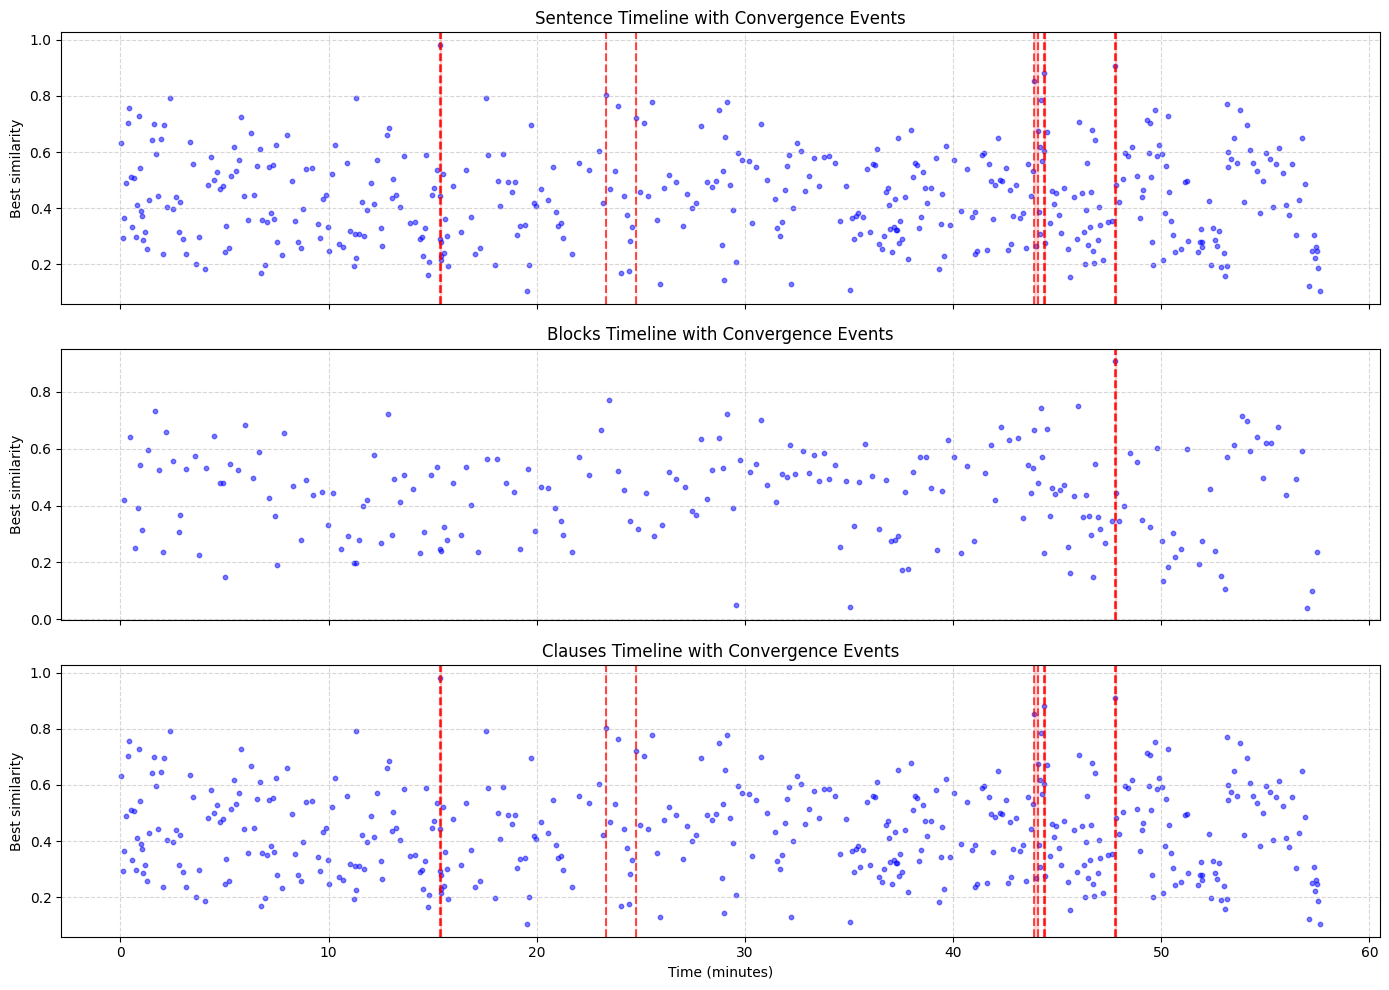

In [34]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# Settings
utterance_path = "/Users/maxchalekson/Projects/NICO-Research/NICO_human-gemini/Data/utterance_data_aligned_full.csv"
sim_threshold = 0.8
burst_gap_sec = 10  # max gap between events in a burst

# Load master utterance data (not used for plotting yet, but available for future annotation filtering)
df_utter = pd.read_csv(utterance_path)

lens_paths = {
    "Sentence": "/Users/maxchalekson/Projects/NICO-Research/NICO_human-gemini/Outputs/sentence",
    "Blocks": "/Users/maxchalekson/Projects/NICO-Research/NICO_human-gemini/Outputs/blocks",
    "Clauses": "/Users/maxchalekson/Projects/NICO-Research/NICO_human-gemini/Outputs/clauses"
}

fig, axes = plt.subplots(len(lens_paths), 1, figsize=(14, 10), sharex=True)
if len(lens_paths) == 1:
    axes = [axes]

for ax, (lens_name, folder) in zip(axes, lens_paths.items()):
    # Load timeline + edges
    timeline_path = os.path.join(folder, "timeline.csv")
    edges_path = os.path.join(folder, "edges_top_similar.csv")

    df_t = pd.read_csv(timeline_path)
    df_edges = pd.read_csv(edges_path)

    # Convert 't' from seconds to minutes
    df_t['t_min'] = df_t['t'] / 60

    # Scatter plot of all units
    ax.scatter(df_t['t_min'], df_t['best_sim'], color='blue', s=10, alpha=0.5, label='All units')

    # High-similarity edges using 'weight' column
    high_sim_edges = df_edges[df_edges['weight'] >= sim_threshold]

    # Map 'source' and 'target' unit IDs to times (in minutes)
    unit_time_map_min = df_t.set_index('u')['t_min'].to_dict()
    event_times = []
    for _, row in high_sim_edges.iterrows():
        if row['source'] in unit_time_map_min:
            event_times.append(unit_time_map_min[row['source']])
        if row['target'] in unit_time_map_min:
            event_times.append(unit_time_map_min[row['target']])
    event_times = sorted(set(event_times))

    # Plot vertical lines for each event
    for t_event in event_times:
        ax.axvline(t_event, color='red', linestyle='--', alpha=0.7)

    # Detect bursts for shaded regions (still in minutes)
    bursts = []
    if event_times:
        start = event_times[0]
        prev = start
        for t in event_times[1:]:
            if (t - prev) * 60 <= burst_gap_sec:  # convert back to seconds for gap check
                prev = t
            else:
                bursts.append((start, prev))
                start = t
                prev = t
        bursts.append((start, prev))

    # Plot shaded regions for bursts
    for start, end in bursts:
        ax.axvspan(start, end, color='red', alpha=0.15)

    ax.set_title(f"{lens_name} Timeline with Convergence Events")
    ax.set_ylabel("Best similarity")
    ax.grid(True, linestyle='--', alpha=0.5)

axes[-1].set_xlabel("Time (minutes)")
plt.tight_layout()
plt.show()


Graph is produced for ABI_S15, next section is confirming it against the transcript for the types of convergences.

A convergence is considered as:

people saying semantically similar things in quick succession

near a coded decision / explanation / new idea

collapsed into an event burst so you're not coutning every line as separate

### Confirming convergence red lines against the transcript

In [54]:
import pandas as pd
import numpy as np
import os
from pathlib import Path

# ---------------- Settings ----------------
SESSION_VAL           = "2021_05_21_ABI_S15"
SIM_THRESHOLD         = 0.80      # similarity cutoff to flag an edge
PAIR_MAX_SEP_SEC      = 45.0      # |t_i - t_j| must be <= this to be a live exchange
EVENT_MERGE_GAP_SEC   = 8.0       # merge events whose centers are closer than this
JOIN_TOL_SEC          = 5.0       # fuzzy join tolerance to utterances on global time
CTX_WIN_SEC           = 15.0      # context window (± seconds) used to count speakers
ROUND_TO_HALF         = True

UTTER_PATH = "/Users/maxchalekson/Projects/NICO-Research/NICO_human-gemini/Data/utterance_data_aligned_full.csv"
LENS_DIRS  = {
    "Sentence": "/Users/maxchalekson/Projects/NICO-Research/NICO_human-gemini/Outputs/sentence",
    "Blocks":   "/Users/maxchalekson/Projects/NICO-Research/NICO_human-gemini/Outputs/blocks",
    "Clauses":  "/Users/maxchalekson/Projects/NICO-Research/NICO_human-gemini/Outputs/clauses",
}
OUT_DIR    = "/Users/maxchalekson/Projects/NICO-Research/NICO_human-gemini/Outputs"
OUT_ALL    = os.path.join(OUT_DIR, "convergence_events_verified.csv")
OUT_TRUE   = os.path.join(OUT_DIR, "convergence_events_TRUE.csv")

# -------------- Helpers -------------------
def round_half_sec(x: pd.Series) -> pd.Series:
    return (np.round(pd.to_numeric(x, errors="coerce") * 2) / 2.0)

def pick_edges_weight(df_edges: pd.DataFrame) -> str:
    if "weight" in df_edges.columns: return "weight"
    if "sim"    in df_edges.columns: return "sim"
    raise ValueError("edges_top_similar.csv needs a 'weight' or 'sim' column.")

def detect_bursts(ts, gap=10.0):
    ts = sorted(float(x) for x in ts)
    out = []
    if not ts: return out
    start = prev = ts[0]
    for t in ts[1:]:
        if t - prev <= gap: prev = t
        else:
            out.append((start, prev))
            start = prev = t
    out.append((start, prev))
    return out

# -------------- Load utterances + prep --------------
u = pd.read_csv(UTTER_PATH)
assert "session" in u.columns, "Expected 'session' in utterance file."
assert "global_timestamp_sec" in u.columns, "Need 'global_timestamp_sec' for global alignment."

u = u[u["session"] == SESSION_VAL].copy()
if u.empty:
    u = u[u["session"].astype(str).str.contains(SESSION_VAL, na=False)].copy()
    if u.empty:
        raise ValueError(f"No utterance rows matched session '{SESSION_VAL}'.")

time_col = "start_sec_adjusted" if "start_sec_adjusted" in u.columns and u["start_sec_adjusted"].notna().any() else "start_sec"
u[time_col] = round_half_sec(u[time_col])
u["global_timestamp_sec"] = round_half_sec(u["global_timestamp_sec"])

# ---------------- Compute global offset from Sentence anchor ----------------
sent_t = pd.read_csv(os.path.join(LENS_DIRS["Sentence"], "timeline.csv"))
sent_e = pd.read_csv(os.path.join(LENS_DIRS["Sentence"], "edges_top_similar.csv"))
sent_t["t"] = round_half_sec(sent_t["t"])
wcol = pick_edges_weight(sent_e)

hi = sent_e[sent_e[wcol] >= SIM_THRESHOLD]
anchor_times_local = (
    sent_t.set_index("u").reindex(hi["source"])["t"]
    .dropna().sort_values().tolist()
)
if anchor_times_local:
    t_anchor = float(anchor_times_local[0])
    j = (u[time_col] - t_anchor).abs().idxmin()
    offset_sec = float(u.loc[j, "global_timestamp_sec"] - u.loc[j, time_col])
else:
    offset_sec = float(np.median(u["global_timestamp_sec"] - u[time_col]))

meta_cols = [c for c in ["speaker","annotations","has_decision","has_explanation","has_new_idea","transcript"] if c in u.columns]
u_small = u[["global_timestamp_sec", time_col] + meta_cols].sort_values("global_timestamp_sec").copy()

# ---------------- Gather events across lenses (edge-based, cross-speaker, close in time) ----------------
records = []
for lens, folder in LENS_DIRS.items():
    t_path = os.path.join(folder, "timeline.csv")
    e_path = os.path.join(folder, "edges_top_similar.csv")
    n_path = os.path.join(folder, "nodes.csv")

    if not (os.path.exists(t_path) and os.path.exists(e_path) and os.path.exists(n_path)):
        continue

    df_t = pd.read_csv(t_path)
    df_e = pd.read_csv(e_path)
    df_n = pd.read_csv(n_path).rename(columns={"id":"unit_id"})

    # Normalize times (local + global)
    df_t["t"] = round_half_sec(df_t["t"])
    df_t["t_global"] = df_t["t"] + offset_sec
    if ROUND_TO_HALF: df_t["t_global"] = round_half_sec(df_t["t_global"])

    # Filter edges by similarity
    wcol = pick_edges_weight(df_e)
    df_e = df_e[df_e[wcol] >= SIM_THRESHOLD].copy()
    if df_e.empty:
        continue

    # Ensure we have times & speakers for both ends; fallback if missing
    have_ij_times = {"t_i","t_j"}.issubset(df_e.columns)
    have_ij_spk   = {"speaker_i","speaker_j"}.issubset(df_e.columns)

    if not have_ij_times:
        # map from unit -> time using timeline
        u2t = df_t.set_index("u")["t"].to_dict()
        df_e["t_i"] = df_e["source"].map(u2t)
        df_e["t_j"] = df_e["target"].map(u2t)

    if not have_ij_spk:
        # map from unit -> speaker using nodes
        u2spk = df_n.set_index("unit_id")["speaker"].to_dict() if "speaker" in df_n.columns else {}
        df_e["speaker_i"] = df_e["source"].map(u2spk)
        df_e["speaker_j"] = df_e["target"].map(u2spk)

    # Globalize both ends and keep cross-speaker, close-in-time edges
    df_e["t_i_g"] = round_half_sec(df_e["t_i"] + offset_sec)
    df_e["t_j_g"] = round_half_sec(df_e["t_j"] + offset_sec)
    df_e["pair_sep_sec"] = (df_e["t_i_g"] - df_e["t_j_g"]).abs()

    cross_speaker = df_e["speaker_i"].astype(str) != df_e["speaker_j"].astype(str)
    close_in_time = df_e["pair_sep_sec"] <= PAIR_MAX_SEP_SEC
    df_e = df_e[cross_speaker & close_in_time].copy()
    if df_e.empty:
        continue

    # Represent each kept edge as an "event" centered at the midpoint time
    df_e["event_center_g"] = round_half_sec((df_e["t_i_g"] + df_e["t_j_g"]) / 2.0)
    df_e["event_start_g"]  = df_e[["t_i_g","t_j_g"]].min(axis=1)
    df_e["event_end_g"]    = df_e[["t_i_g","t_j_g"]].max(axis=1)

    # Merge nearby events into bursts (per lens)
    centers = df_e["event_center_g"].tolist()
    bursts = detect_bursts(centers, gap=EVENT_MERGE_GAP_SEC)

    # For each burst, pick the strongest edge as the representative center + carry speakers/text
    for (bstart, bend) in bursts:
        in_burst = df_e[(df_e["event_center_g"] >= bstart) & (df_e["event_center_g"] <= bend)]
        if in_burst.empty: 
            continue
        rep = in_burst.sort_values(wcol, ascending=False).iloc[0]

        # Attach node text from the nearer endpoint to the center
        # nearest unit to rep['event_center_g']
        t_center = float(rep["event_center_g"])
        # find nearest endpoint unit id
        cand_units = [
            (int(rep["source"]), float(rep["t_i_g"])),
            (int(rep["target"]), float(rep["t_j_g"]))
        ]
        unit_id_center = min(cand_units, key=lambda x: abs(x[1]-t_center))[0]

        node_text = None; node_speaker = None
        rowN = df_n[df_n["unit_id"] == unit_id_center]
        if not rowN.empty:
            node_text    = str(rowN.iloc[0].get("text", ""))
            node_speaker = rowN.iloc[0].get("speaker", np.nan)

        records.append({
            "lens": lens,
            "start_global_sec": float(bstart),
            "end_global_sec":   float(bend),
            "center_global_sec": float(t_center),
            "unit_id_center":   int(unit_id_center),
            "node_speaker":     node_speaker,
            "node_text":        node_text,
            "edge_speaker_i":   rep.get("speaker_i", np.nan),
            "edge_speaker_j":   rep.get("speaker_j", np.nan),
            "pair_sep_sec":     float(rep["pair_sep_sec"]),
            "edge_weight":      float(rep[wcol]),
        })

events = pd.DataFrame.from_records(records).sort_values(["lens","center_global_sec"]).reset_index(drop=True)

# ---------------- Fuzzy join to nearest utterance + add context / speaker counts ----------------
def grab_context(df_session: pd.DataFrame, t_sec: float, win=15.0) -> tuple[str, int]:
    m = (df_session["global_timestamp_sec"] >= t_sec - win) & (df_session["global_timestamp_sec"] <= t_sec + win)
    if not m.any(): 
        return "", 0
    ctx = df_session.loc[m, ["speaker","transcript","global_timestamp_sec"]].sort_values("global_timestamp_sec")
    lines = [f"[{round(r.global_timestamp_sec,1)}s] {r.speaker}: {r.transcript}" for r in ctx.itertuples(index=False)]
    blob = " | ".join(lines)
    uniq_spk = ctx["speaker"].dropna().astype(str).nunique()
    return blob[:2000], int(uniq_spk)

joined_rows = []
for r in events.itertuples(index=False):
    left = pd.DataFrame({"t_global":[r.center_global_sec]}).sort_values("t_global")
    right = u_small.sort_values("global_timestamp_sec")

    merged = pd.merge_asof(
        left, right, left_on="t_global", right_on="global_timestamp_sec",
        direction="nearest", tolerance=JOIN_TOL_SEC
    )

    # annotation flags (nearest utterance within JOIN_TOL_SEC)
    annot = {"annotations": np.nan, "has_decision": np.nan, "has_explanation": np.nan, "has_new_idea": np.nan}
    if len(merged):
        for k in annot.keys():
            if k in merged.columns:
                annot[k] = merged.iloc[0][k]

    # context & speaker diversity
    ctx_blob, ctx_uniq = grab_context(u, r.center_global_sec, win=CTX_WIN_SEC)

    row_out = {
        "lens": r.lens,
        "start_global_sec": r.start_global_sec,
        "end_global_sec": r.end_global_sec,
        "center_global_sec": r.center_global_sec,
        "unit_id_center": r.unit_id_center,
        "node_speaker": r.node_speaker,
        "node_text": r.node_text,
        "edge_speaker_i": r.edge_speaker_i,
        "edge_speaker_j": r.edge_speaker_j,
        "pair_sep_sec": r.pair_sep_sec,
        "edge_weight": r.edge_weight,
        "context_uniq_speakers_±%ds" % int(CTX_WIN_SEC): ctx_uniq,
        "context_±%ds" % int(CTX_WIN_SEC): ctx_blob,
        **annot
    }
    joined_rows.append(row_out)

events_verified = pd.DataFrame(joined_rows)

# ---------------- Classify TRUE convergence ----------------
# Criteria:
#  - human annotation present nearby (decision OR new_idea OR explanation)
#  - context has >= 2 speakers
#  - cross-speaker edge already enforced + pair separation constraint already enforced
ann_ok = (
    events_verified.get("has_decision").fillna(False).astype(bool) |
    events_verified.get("has_new_idea").fillna(False).astype(bool) |
    events_verified.get("has_explanation").fillna(False).astype(bool)
)
ctx_col = f"context_uniq_speakers_±{int(CTX_WIN_SEC)}s"
ctx_ok = events_verified[ctx_col].fillna(0) >= 2

events_verified["is_true_convergence"] = ann_ok & ctx_ok

# ---------------- Save & show ----------------
Path(OUT_DIR).mkdir(parents=True, exist_ok=True)
events_verified.to_csv(OUT_ALL, index=False)
events_verified[events_verified["is_true_convergence"]].to_csv(OUT_TRUE, index=False)

print(f"✓ Wrote ALL events -> {OUT_ALL}  (rows={len(events_verified)})")
print(f"✓ Wrote TRUE convergence -> {OUT_TRUE}  (rows={events_verified['is_true_convergence'].sum()})")

# Pretty preview
preview_cols = [
    "lens","center_global_sec","edge_weight","pair_sep_sec",
    "edge_speaker_i","edge_speaker_j","node_speaker","node_text",
    "has_decision","has_new_idea","has_explanation", ctx_col
]
preview_cols = [c for c in preview_cols if c in events_verified.columns]
print("\n=== TRUE Convergence (preview) ===")
print(
    events_verified[events_verified["is_true_convergence"]]
    .sort_values(["lens","center_global_sec"])
    [preview_cols]
    .to_string(index=False, max_colwidth=90)
)


✓ Wrote ALL events -> /Users/maxchalekson/Projects/NICO-Research/NICO_human-gemini/Outputs/convergence_events_verified.csv  (rows=5)
✓ Wrote TRUE convergence -> /Users/maxchalekson/Projects/NICO-Research/NICO_human-gemini/Outputs/convergence_events_TRUE.csv  (rows=0)

=== TRUE Convergence (preview) ===
Empty DataFrame
Columns: [lens, center_global_sec, edge_weight, pair_sep_sec, edge_speaker_i, edge_speaker_j, node_speaker, node_text, has_decision, has_new_idea, has_explanation, context_uniq_speakers_±15s]
Index: []


/var/folders/17/lphw45ds14n5t74zwjdfybx40000gn/T/ipykernel_2635/2986562245.py:240: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  events_verified.get("has_decision").fillna(False).astype(bool) |
/var/folders/17/lphw45ds14n5t74zwjdfybx40000gn/T/ipykernel_2635/2986562245.py:241: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  events_verified.get("has_new_idea").fillna(False).astype(bool) |
/var/folders/17/lphw45ds14n5t74zwjdfybx40000gn/T/ipykernel_2635/2986562245.py:242: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated a

In [56]:
import pandas as pd
import numpy as np
import os
from pathlib import Path

# =================== SETTINGS ===================
SESSION_VAL           = "2021_05_21_ABI_S15"
SIM_THRESHOLD         = 0.80      # similarity threshold for candidate edges
EVENT_MERGE_GAP_SEC   = 8.0       # merge close edge times into a single event
DECISION_WIN_SEC      = 15.0      # window around event center to look for decision tags (± seconds)
ROUND_TO_HALF         = True      # round times to nearest 0.5s for robustness

UTTER_PATH = "/Users/maxchalekson/Projects/NICO-Research/NICO_human-gemini/Data/utterance_data_aligned_full.csv"
LENS_DIRS  = {
    "Sentence": "/Users/maxchalekson/Projects/NICO-Research/NICO_human-gemini/Outputs/sentence",
    "Blocks":   "/Users/maxchalekson/Projects/NICO-Research/NICO_human-gemini/Outputs/blocks",
    "Clauses":  "/Users/maxchalekson/Projects/NICO-Research/NICO_human-gemini/Outputs/clauses",
}
OUT_CSV    = "/Users/maxchalekson/Projects/NICO-Research/NICO_human-gemini/Outputs/convergence_events_DECISION_ONLY.csv"

# =================== HELPERS ===================
def round_half(x):
    return (np.round(pd.to_numeric(x, errors="coerce") * 2) / 2.0)

def pick_edges_weight(df_edges: pd.DataFrame) -> str:
    if "weight" in df_edges.columns: return "weight"
    if "sim"    in df_edges.columns: return "sim"
    raise ValueError("edges_top_similar.csv needs a 'weight' or 'sim' column.")

def detect_bursts(times, gap=10.0):
    times = sorted(float(t) for t in times)
    out = []
    if not times: return out
    start = prev = times[0]
    for t in times[1:]:
        if t - prev <= gap:
            prev = t
        else:
            out.append((start, prev))
            start = prev = t
    out.append((start, prev))
    return out

def to_boolish(v):
    """Interpret 'true','1','yes' or nonzero numbers as True."""
    if pd.isna(v): return False
    if isinstance(v, (int, float, np.integer, np.floating)):
        return float(v) != 0.0
    s = str(v).strip().lower()
    return s in {"1","true","yes","y"}

def looks_like_decision_text(x: str) -> bool:
    if not isinstance(x, str) or not x.strip(): return False
    x_low = x.lower()
    keywords = [
        "decide", "decided", "decision", "we'll do", "let's do", "agreed",
        "agree to", "consensus", "conclude", "finalize", "put a pin",
        "we will", "we should", "let’s do", "let us", "we agree"
    ]
    return any(k in x_low for k in keywords)

# =================== LOAD UTTERANCES ===================
u = pd.read_csv(UTTER_PATH)
print("Master utterance columns:", list(u.columns))

# pick session rows; allow contains-match as fallback
uu = u[u["session"] == SESSION_VAL].copy()
if uu.empty:
    uu = u[u["session"].astype(str).str.contains(SESSION_VAL, na=False)].copy()
if uu.empty:
    raise ValueError(f"No utterance rows match session='{SESSION_VAL}'")

# choose best local time column; round
time_col = "start_sec_adjusted" if "start_sec_adjusted" in uu.columns and uu["start_sec_adjusted"].notna().any() else "start_sec"
uu[time_col] = round_half(uu[time_col])
if "global_timestamp_sec" in uu.columns:
    uu["global_timestamp_sec"] = round_half(uu["global_timestamp_sec"])
else:
    # if no global time, synthesize from local (same scale) so the pipeline still runs
    uu["global_timestamp_sec"] = uu[time_col]

# Normalize missing decision columns
for c in ["has_decision","has_explanation","has_new_idea","annotations","transcript","speaker"]:
    if c not in uu.columns:
        uu[c] = np.nan

# =================== COMPUTE GLOBAL OFFSET (anchor) ===================
# Use Sentence lens to compute a robust local→global offset
sent_t = pd.read_csv(os.path.join(LENS_DIRS["Sentence"], "timeline.csv"))
sent_e = pd.read_csv(os.path.join(LENS_DIRS["Sentence"], "edges_top_similar.csv"))
sent_t["t"] = round_half(sent_t["t"])
wcol = pick_edges_weight(sent_e)
hi_edges = sent_e[sent_e[wcol] >= SIM_THRESHOLD]
anchor_local_times = (
    sent_t.set_index("u").reindex(hi_edges["source"])["t"]
    .dropna().sort_values().tolist()
)
if anchor_local_times:
    t_anchor = float(anchor_local_times[0])
    j = (uu[time_col] - t_anchor).abs().idxmin()
    offset_sec = float(uu.loc[j, "global_timestamp_sec"] - uu.loc[j, time_col])
else:
    offset_sec = float(np.median(uu["global_timestamp_sec"] - uu[time_col]))
print(f"[INFO] Using utter time '{time_col}'. Offset (local→global) ≈ {offset_sec:.3f}s")

# Build a decision-ish boolean per utterance (row-wise)
uu_decision_view = uu.copy()
uu_decision_view["global_timestamp_sec"] = round_half(uu_decision_view["global_timestamp_sec"])
uu_decision_view["decisionish"] = uu_decision_view.apply(
    lambda r: (
        to_boolish(r.get("has_decision")) or
        to_boolish(r.get("has_explanation")) or
        to_boolish(r.get("has_new_idea")) or
        looks_like_decision_text(r.get("annotations", ""))
    ),
    axis=1
)

# =================== GATHER EVENTS PER LENS (then gate by decision) ===================
records = []
for lens, folder in LENS_DIRS.items():
    t_path = os.path.join(folder, "timeline.csv")
    e_path = os.path.join(folder, "edges_top_similar.csv")
    n_path = os.path.join(folder, "nodes.csv")
    if not (os.path.exists(t_path) and os.path.exists(e_path) and os.path.exists(n_path)):
        print(f"[WARN] Missing files for {lens}; skipping.")
        continue

    df_t = pd.read_csv(t_path)
    df_e = pd.read_csv(e_path)
    df_n = pd.read_csv(n_path).rename(columns={"id":"unit_id"})

    df_t["t"] = round_half(df_t["t"])
    # local → global
    df_t["t_global"] = df_t["t"] + offset_sec
    if ROUND_TO_HALF:
        df_t["t_global"] = round_half(df_t["t_global"])

    # candidate edges
    wcol = pick_edges_weight(df_e)
    cand = df_e[df_e[wcol] >= SIM_THRESHOLD].copy()
    if cand.empty:
        continue

    # map edge source → global time; collapse to bursts
    u2tg = df_t.set_index("u")["t_global"]
    event_times = u2tg.reindex(cand["source"]).dropna().tolist()
    bursts = detect_bursts(event_times, gap=EVENT_MERGE_GAP_SEC)

    # for each burst, pick center, then gate by decision in ±window
    for start_g, end_g in bursts:
        center_g = 0.5*(start_g + end_g)

        # any decision-ish utterance within ± DECISION_WIN_SEC?
        m = (
            (uu_decision_view["global_timestamp_sec"] >= center_g - DECISION_WIN_SEC) &
            (uu_decision_view["global_timestamp_sec"] <= center_g + DECISION_WIN_SEC) &
            (uu_decision_view["decisionish"])
        )
        if not m.any():
            continue  # not a decision-aligned convergence

        # nearest node text/speaker for context
        idx = (df_t["t_global"] - center_g).abs().idxmin()
        unit_id_center = int(df_t.loc[idx, "u"]) if "u" in df_t.columns else None
        node_row = df_n[df_n["unit_id"] == unit_id_center]
        node_text = (node_row.iloc[0]["text"] if not node_row.empty and "text" in node_row.columns else "")
        node_speaker = (node_row.iloc[0]["speaker"] if not node_row.empty and "speaker" in node_row.columns else np.nan)

        # nearest decision utter (for summary columns)
        near = uu_decision_view.loc[m].copy()
        k = (near["global_timestamp_sec"] - center_g).abs().idxmin()
        nearest = uu_decision_view.loc[k]

        records.append({
            "lens": lens,
            "start_global_sec": float(start_g),
            "end_global_sec": float(end_g),
            "center_global_sec": float(center_g),
            "unit_id_center": unit_id_center,
            "node_speaker": node_speaker,
            "node_text": node_text,
            "nearest_speaker": nearest.get("speaker", np.nan),
            "nearest_time_global": float(nearest.get("global_timestamp_sec", np.nan)),
            "has_decision": nearest.get("has_decision", np.nan),
            "has_explanation": nearest.get("has_explanation", np.nan),
            "has_new_idea": nearest.get("has_new_idea", np.nan),
            "annotations": nearest.get("annotations", np.nan),
            "transcript": nearest.get("transcript", np.nan)
        })

events_decision = pd.DataFrame.from_records(records).sort_values(
    ["lens","center_global_sec"]
).reset_index(drop=True)

# =================== OUTPUT ===================
Path(os.path.dirname(OUT_CSV)).mkdir(parents=True, exist_ok=True)
events_decision.to_csv(OUT_CSV, index=False)

print(f"✓ Wrote {OUT_CSV} (rows={len(events_decision)})")
if len(events_decision):
    preview = events_decision.copy()
    preview["node_text"] = preview["node_text"].astype(str).str.slice(0, 110)
    preview["transcript"] = preview["transcript"].astype(str).str.slice(0, 110)
    print(preview.to_string(index=False))
else:
    print("No decision-gated convergence events found. Try lowering SIM_THRESHOLD, widening DECISION_WIN_SEC, or check annotation coverage.")


Master utterance columns: ['conference', 'session', 'speaker', 'timestamp', 'speaking_duration', 'nods_others', 'smile_self', 'smile_other', 'distracted_others', 'hand_gesture', 'interruption', 'overlap', 'screenshare', 'annotations', 'transcript', 'start_sec', 'end_sec', 'session_core', 'clip_number', 'global_session', 'clip_duration_sec', 'clip_offset_sec', 'start_sec_adjusted', 'end_sec_adjusted', 'start_minute_adjusted', 'global_timestamp_sec', 'global_minute', 'is_early', 'annotation_dict', 'has_new_idea', 'has_explanation', 'has_decision']
[INFO] Using utter time 'start_sec_adjusted'. Offset (local→global) ≈ 0.000s
✓ Wrote /Users/maxchalekson/Projects/NICO-Research/NICO_human-gemini/Outputs/convergence_events_DECISION_ONLY.csv (rows=2)
    lens  start_global_sec  end_global_sec  center_global_sec  unit_id_center  node_speaker                 node_text nearest_speaker  nearest_time_global  has_decision  has_explanation  has_new_idea                                                 

#### quick viewing more events

[INFO] Offset (local→global) ≈ 0.000s | gate=decision_or_explanation | SIM≥0.75 | ±20.0s
✓ Wrote /Users/maxchalekson/Projects/NICO-Research/NICO_human-gemini/Outputs/convergence_events_DECISION_OR_EXPLANATION.csv (rows=6)
    lens  start_global_sec  end_global_sec  center_global_sec  unit_id_center  node_speaker                                                                                                      node_text nearest_speaker  nearest_time_global  has_decision  has_explanation  has_new_idea                                                                                                                                                                                                                                          annotations                                                                                                     transcript
 Clauses             678.0           678.0              678.0              92    Brad Smith                                              

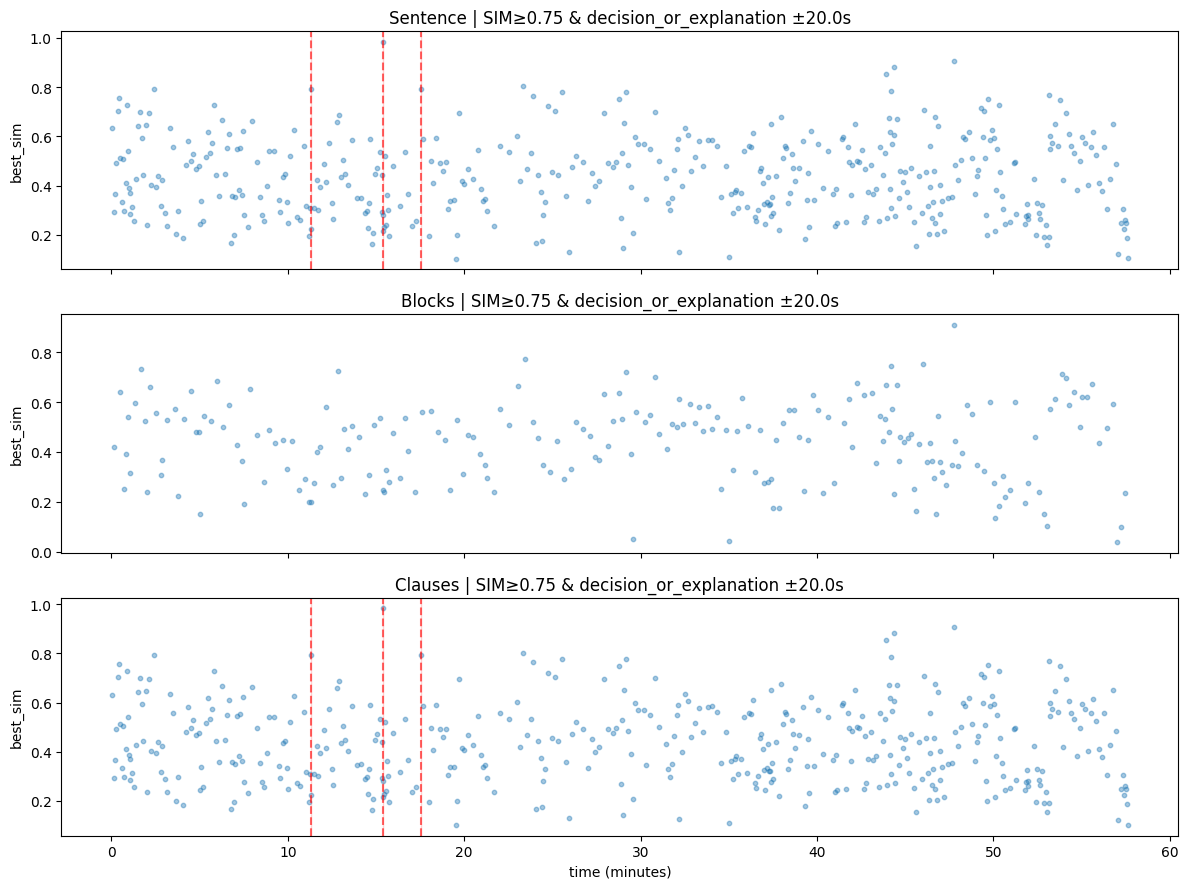

In [57]:
# === Decision- and Annotation-Gated Convergence Finder + Quick Plot =====================
import pandas as pd, numpy as np, os
from pathlib import Path
import matplotlib.pyplot as plt

# ---------------- Settings you can tweak -----------------------------------------------
SESSION_VAL           = "2021_05_21_ABI_S15"

# Similarity → events
SIM_THRESHOLD         = 0.75      # try 0.70–0.85; lower to see more candidates
EVENT_MERGE_GAP_SEC   = 10.0      # merge close event times into a single burst

# Label gate → what “counts”
GATE_MODE             = "decision_or_explanation"  
# options: "decision_only", "decision_or_explanation", "any_label", "keyword_only"

LABEL_WIN_SEC         = 20.0      # look for labels within ± this sec around event center
ROUND_TO_HALF         = True

# Data locations
UTTER_PATH = "/Users/maxchalekson/Projects/NICO-Research/NICO_human-gemini/Data/utterance_data_aligned_full.csv"
LENS_DIRS  = {
    "Sentence": "/Users/maxchalekson/Projects/NICO-Research/NICO_human-gemini/Outputs/sentence",
    "Blocks":   "/Users/maxchalekson/Projects/NICO-Research/NICO_human-gemini/Outputs/blocks",
    "Clauses":  "/Users/maxchalekson/Projects/NICO-Research/NICO_human-gemini/Outputs/clauses",
}
OUT_CSV    = f"/Users/maxchalekson/Projects/NICO-Research/NICO_human-gemini/Outputs/convergence_events_{GATE_MODE.upper()}.csv"

# ---------------- Helpers ----------------------------------------------------------------
def round_half(x):
    return (np.round(pd.to_numeric(x, errors="coerce") * 2) / 2.0)

def pick_edges_weight(df_edges: pd.DataFrame) -> str:
    if "weight" in df_edges.columns: return "weight"
    if "sim"    in df_edges.columns: return "sim"
    raise ValueError("edges_top_similar.csv needs a 'weight' or 'sim' column.")

def detect_bursts(times, gap=10.0):
    times = sorted(float(t) for t in times)
    out = []
    if not times: return out
    start = prev = times[0]
    for t in times[1:]:
        if t - prev <= gap: prev = t
        else:
            out.append((start, prev)); start = prev = t
    out.append((start, prev))
    return out

def to_boolish(v):
    if pd.isna(v): return False
    if isinstance(v, (int, float, np.integer, np.floating)): return float(v) != 0.0
    return str(v).strip().lower() in {"1","true","yes","y"}

def looks_like_decision_text(x: str) -> bool:
    if not isinstance(x, str) or not x.strip(): return False
    x = x.lower()
    keys = [
        "decide","decided","decision","we'll do","let's do","agreed","agree to",
        "consensus","conclude","finalize","put a pin","we will","we should","let us"
    ]
    return any(k in x for k in keys)

def looks_like_explanation_text(x: str) -> bool:
    if not isinstance(x, str) or not x.strip(): return False
    x = x.lower()
    keys = ["because","so that","in order to","therefore","thus","reason is","explain","explanation"]
    return any(k in x for k in keys)

def looks_like_new_idea_text(x: str) -> bool:
    if not isinstance(x, str) or not x.strip(): return False
    x = x.lower()
    keys = ["what if","we could","how about","another idea","new idea","propose","let's try"]
    return any(k in x for k in keys)

def passes_gate(row, mode: str):
    # use explicit tags if present, else keyword heuristics over annotations
    h_dec = to_boolish(row.get("has_decision"))
    h_exp = to_boolish(row.get("has_explanation"))
    h_new = to_boolish(row.get("has_new_idea"))
    ann   = row.get("annotations", "")

    k_dec = looks_like_decision_text(ann)
    k_exp = looks_like_explanation_text(ann)
    k_new = looks_like_new_idea_text(ann)

    if mode == "decision_only":
        return h_dec or k_dec
    if mode == "decision_or_explanation":
        return (h_dec or k_dec) or (h_exp or k_exp)
    if mode == "any_label":
        return (h_dec or h_exp or h_new) or (k_dec or k_exp or k_new)
    if mode == "keyword_only":
        return k_dec or k_exp or k_new
    return False

# ---------------- Load utterances + choose time columns ----------------------------------
u = pd.read_csv(UTTER_PATH)
uu = u[u["session"] == SESSION_VAL].copy()
if uu.empty:
    uu = u[u["session"].astype(str).str.contains(SESSION_VAL, na=False)].copy()
if uu.empty:
    raise ValueError(f"No utterance rows match session='{SESSION_VAL}'")

time_col = "start_sec_adjusted" if "start_sec_adjusted" in uu.columns and uu["start_sec_adjusted"].notna().any() else "start_sec"
for c in [time_col, "global_timestamp_sec"]:
    if c in uu.columns: uu[c] = round_half(uu[c])
if "global_timestamp_sec" not in uu.columns:
    uu["global_timestamp_sec"] = uu[time_col]

for c in ["has_decision","has_explanation","has_new_idea","annotations","transcript","speaker"]:
    if c not in uu.columns:
        uu[c] = np.nan

# ---------------- Compute local→global offset from Sentence lens -------------------------
sent_t = pd.read_csv(os.path.join(LENS_DIRS["Sentence"], "timeline.csv"))
sent_e = pd.read_csv(os.path.join(LENS_DIRS["Sentence"], "edges_top_similar.csv"))
sent_t["t"] = round_half(sent_t["t"])
wcol = pick_edges_weight(sent_e)
hi_edges = sent_e[sent_e[wcol] >= SIM_THRESHOLD]
anchor_local = sent_t.set_index("u").reindex(hi_edges["source"])["t"].dropna().sort_values().tolist()

if anchor_local:
    t_anchor = float(anchor_local[0])
    j = (uu[time_col] - t_anchor).abs().idxmin()
    offset_sec = float(uu.loc[j, "global_timestamp_sec"] - uu.loc[j, time_col])
else:
    offset_sec = float(np.median(uu["global_timestamp_sec"] - uu[time_col]))

print(f"[INFO] Offset (local→global) ≈ {offset_sec:.3f}s | gate={GATE_MODE} | SIM≥{SIM_THRESHOLD} | ±{LABEL_WIN_SEC}s")

# ---------------- Collect events per lens + gate by labels --------------------------------
rows = []
for lens, folder in LENS_DIRS.items():
    t_path, e_path, n_path = [os.path.join(folder, f) for f in ("timeline.csv","edges_top_similar.csv","nodes.csv")]
    if not (os.path.exists(t_path) and os.path.exists(e_path) and os.path.exists(n_path)):
        print(f"[WARN] Missing files for {lens}; skipping.")
        continue

    df_t = pd.read_csv(t_path)
    df_e = pd.read_csv(e_path)
    df_n = pd.read_csv(n_path).rename(columns={"id":"unit_id"})

    df_t["t"] = round_half(df_t["t"])
    df_t["t_global"] = df_t["t"] + offset_sec
    if ROUND_TO_HALF: df_t["t_global"] = round_half(df_t["t_global"])

    # candidate high-sim events
    wcol = pick_edges_weight(df_e)
    cand = df_e[df_e[wcol] >= SIM_THRESHOLD].copy()
    if cand.empty: 
        continue

    # edge source → times; collapse to bursts
    u2tg = df_t.set_index("u")["t_global"]
    ev_times = u2tg.reindex(cand["source"]).dropna().tolist()
    bursts = detect_bursts(ev_times, gap=EVENT_MERGE_GAP_SEC)

    # filter by label window
    for (s_g, e_g) in bursts:
        c_g = 0.5*(s_g + e_g)
        m = (uu["global_timestamp_sec"] >= c_g - LABEL_WIN_SEC) & (uu["global_timestamp_sec"] <= c_g + LABEL_WIN_SEC)
        win = uu.loc[m].copy()
        if not len(win):
            continue
        # keep only if any row inside window passes the chosen gate
        if not any(passes_gate(r, GATE_MODE) for _, r in win.iterrows()):
            continue

        # nearest node for context
        idx = (df_t["t_global"] - c_g).abs().idxmin()
        unit_id = int(df_t.loc[idx, "u"]) if "u" in df_t.columns else None
        node = df_n[df_n["unit_id"] == unit_id]
        node_text = (node.iloc[0]["text"] if not node.empty and "text" in node.columns else "")
        node_speaker = (node.iloc[0]["speaker"] if not node.empty and "speaker" in node.columns else np.nan)

        # closest utterance inside window (for tags/annotation snapshot)
        k = (win["global_timestamp_sec"] - c_g).abs().idxmin()
        nearest = win.loc[k]

        rows.append({
            "lens": lens,
            "start_global_sec": float(s_g),
            "end_global_sec": float(e_g),
            "center_global_sec": float(c_g),
            "unit_id_center": unit_id,
            "node_speaker": node_speaker,
            "node_text": node_text,
            "nearest_speaker": nearest.get("speaker", np.nan),
            "nearest_time_global": float(nearest.get("global_timestamp_sec", np.nan)),
            "has_decision": nearest.get("has_decision", np.nan),
            "has_explanation": nearest.get("has_explanation", np.nan),
            "has_new_idea": nearest.get("has_new_idea", np.nan),
            "annotations": nearest.get("annotations", np.nan),
            "transcript": nearest.get("transcript", np.nan),
        })

events = pd.DataFrame(rows).sort_values(["lens","center_global_sec"]).reset_index(drop=True)
Path(os.path.dirname(OUT_CSV)).mkdir(parents=True, exist_ok=True)
events.to_csv(OUT_CSV, index=False)
print(f"✓ Wrote {OUT_CSV} (rows={len(events)})")
if len(events):
    preview = events.copy()
    preview["node_text"] = preview["node_text"].astype(str).str.slice(0,110)
    preview["transcript"] = preview["transcript"].astype(str).str.slice(0,110)
    print(preview.to_string(index=False))
else:
    print("No events passed the gate; try lowering SIM_THRESHOLD, widening LABEL_WIN_SEC, or switching GATE_MODE.")

# ---------------- Quick visual: timeline w/ convergence markers --------------------------
fig, axes = plt.subplots(len(LENS_DIRS), 1, figsize=(12, 9), sharex=True)
if len(LENS_DIRS) == 1: axes = [axes]

for ax, (lens, folder) in zip(axes, LENS_DIRS.items()):
    t_path = os.path.join(folder, "timeline.csv")
    if not os.path.exists(t_path): continue
    df_t = pd.read_csv(t_path)
    df_t["t_global"] = round_half(df_t["t"] + offset_sec)
    # base scatter
    ax.scatter(df_t["t_global"]/60, df_t["best_sim"], s=10, alpha=0.4, label="units")
    # overlay events we kept
    ev = events[events["lens"] == lens]
    for _, r in ev.iterrows():
        ax.axvspan(r["start_global_sec"]/60, r["end_global_sec"]/60, alpha=0.18, color="red")
        ax.axvline(r["center_global_sec"]/60, linestyle="--", alpha=0.6, color="red")
    ax.set_title(f"{lens} | SIM≥{SIM_THRESHOLD} & {GATE_MODE} ±{LABEL_WIN_SEC}s")
    ax.set_ylabel("best_sim")
axes[-1].set_xlabel("time (minutes)")
plt.tight_layout()
plt.show()
# =========================================================================================


In [58]:
for _, row in events.iterrows():
    print("\n" + "="*60)
    print(f"Lens: {row['lens']}, Center time: {row['center_global_sec']} sec")
    t0 = row['center_global_sec'] - 20
    t1 = row['center_global_sec'] + 20
    ctx = uu[(uu['global_timestamp_sec'] >= t0) & (uu['global_timestamp_sec'] <= t1)]
    for _, r in ctx.iterrows():
        print(f"[{r.global_timestamp_sec:.1f}s] {r.speaker}: {r.transcript}")



Lens: Clauses, Center time: 678.0 sec
[661.0s] Brad Smith: Maybe focus on your modality because I think when you get that's where we're going to be. Either your problem that you're trying to solve in deep tissue or the modality that you think you can bring to the problem.
[671.0s] Aniruddha Ray: Oh, there is Stephen Barbara. So Danny, can see you. Hey Danny.
[675.0s] Barbara Smith: Sorry, sorry. I have a little human that required me for a few minutes.
[682.0s] Aniruddha Ray: Um, so, uh, my name is Anirud. I'm from University of Toledo. I work on two different things. So I work on nanotechnology aided optical imaging, which involves fluorescence as well as photoacoustics. And that's what is my interest in deep tissue imaging. I also work on lensless holographic microscopy, um, but that is more for Xvivo samples or in vitro samples. So we basically develop different types of nanoparticles, um, metallic quantum dots, um, um, polymeric nanoparticles for biomedical imaging, sensing, as we

In [59]:
# === Verify decision-gated convergence events against transcript ===
WINDOW_SEC = 20  # seconds before/after event center

# Load utterances for session
uu_full = pd.read_csv(UTTER_PATH)
uu_full["global_timestamp_sec"] = pd.to_numeric(uu_full["global_timestamp_sec"], errors="coerce")

# Store output for review
all_event_contexts = []

for idx, row in events_decision.iterrows():
    center_time = row["center_global_sec"]
    start_win = center_time - WINDOW_SEC
    end_win = center_time + WINDOW_SEC
    
    # Filter utterances in the window
    context_rows = uu_full[
        (uu_full["global_timestamp_sec"] >= start_win) &
        (uu_full["global_timestamp_sec"] <= end_win) &
        (uu_full["session"].astype(str).str.contains(SESSION_VAL, na=False))
    ].copy()
    
    context_rows = context_rows[["global_timestamp_sec", "speaker", "transcript", "annotations"]]
    context_rows["event_id"] = idx  # tag which event it belongs to
    
    all_event_contexts.append(context_rows)
    
    # Print in notebook for quick check
    print(f"\n=== Event {idx} | Center @ {center_time:.1f}s ===")
    for _, c in context_rows.iterrows():
        print(f"[{c['global_timestamp_sec']:.1f}s] {c['speaker']}: {c['transcript']} | {c['annotations']}")

# Combine into one DataFrame
df_event_contexts = pd.concat(all_event_contexts, ignore_index=True)

# Save to CSV for spreadsheet review
OUT_CONTEXT_CSV = "/Users/maxchalekson/Projects/NICO-Research/NICO_human-gemini/Outputs/convergence_event_contexts.csv"
df_event_contexts.to_csv(OUT_CONTEXT_CSV, index=False)
print(f"\n✓ Saved event context snippets to {OUT_CONTEXT_CSV}")



=== Event 0 | Center @ 922.5s ===
[916.0s] Brad Smith: Uh see Shim. | {'encourage particpatioin': 'Brad Smith is inviting Shim to speak next and share their modality, continuing the round of introductions.'}
[917.0s] Sixian You: Hi everyone. My name is Sishan Yo. Uh, I recently started in electric engineering department at MIT. My background is in optics and microscopy. Uh, so, uh, we are very much troubled by deep tissue imaging because uh, we're we're blessed with this submicro resolution but we can rarely go deeper than millimeter uh depth. So what my lab does, uh, we want to tackle this issue and also a lot of other like imaging speed or contrast issue from three aspects. The first aspect is uh, um multiphoton imaging. | {'explain or define term or concept': 'The speaker is introducing themself and their background in optics and microscopy, providing context for their subsequent statements about deep tissue imaging.', 'present new idea': 'The speaker introduces the idea that their

Note: from this, this might not be a perfect example of true convergence - some of this is parallel brainstorming, topic expansion, or temporal over laps. 

### fixing convergence_event_contexts.csv 

Adding columns for True Convergence? and Notes (to mark them while reading transcript)

In [60]:
import pandas as pd
from pathlib import Path

# === Paths ===
input_path = Path("/Users/maxchalekson/Projects/NICO-Research/NICO_human-gemini/Outputs/convergence_event_contexts.csv")
output_path = input_path.with_name("convergence_event_contexts_review.csv")

# === Load data ===
df = pd.read_csv(input_path)

# === Add review columns ===
df["label_convergence"] = ""       # Y / N / Maybe
df["label_type"] = ""              # e.g., agreement, paraphrase, decision, etc.
df["label_reason"] = ""            # short explanation
df["label_confidence_0to1"] = ""   # optional, e.g., 0.8

# === Optional: keep only relevant columns first ===
# If you want to reorder columns so labels appear at the front:
label_cols = ["label_convergence", "label_type", "label_reason", "label_confidence_0to1"]
df = df[label_cols + [c for c in df.columns if c not in label_cols]]

# === Save review CSV ===
df.to_csv(output_path, index=False)
print(f"✓ Wrote {output_path} (rows={len(df)})")


✓ Wrote /Users/maxchalekson/Projects/NICO-Research/NICO_human-gemini/Outputs/convergence_event_contexts_review.csv (rows=36)


merging labels back into detected events 

(how many true vs. false by lens) and exporting final list of accepted convergence events for plots/reports

In [64]:
import pandas as pd
import numpy as np
from pathlib import Path

# === Paths (edit if needed) ===
EVENTS_DETECTED_CSV = "/Users/maxchalekson/Projects/NICO-Research/NICO_human-gemini/Outputs/convergence_events_DECISION_ONLY.csv"
REVIEW_CSV          = "/Users/maxchalekson/Projects/NICO-Research/NICO_human-gemini/Outputs/convergence_event_contexts_review.csv"
OUT_DIR             = "/Users/maxchalekson/Projects/NICO-Research/NICO_human-gemini/Outputs"

CENTER_TOL_SEC = 2.0  # tolerance when matching by center time

# --- Load ---
det = pd.read_csv(EVENTS_DETECTED_CSV).copy()
rev = pd.read_csv(REVIEW_CSV).copy()

if "lens" not in det.columns or "center_global_sec" not in det.columns:
    raise ValueError("Detected events file must include 'lens' and 'center_global_sec'.")

# Normalize detected events
det["lens_norm"] = det["lens"].astype(str).str.strip().str.lower()
det["center_global_sec"] = pd.to_numeric(det["center_global_sec"], errors="coerce")

# --- Find/Build a label column in review ---
label_candidates = ["is_convergence", "verified", "keep", "label", "gold", "accept"]
label_cols = [c for c in label_candidates if c in rev.columns]

def to_binary_cell(x):
    if pd.isna(x): 
        return np.nan
    s = str(x).strip().lower()
    if s in {"1","true","t","yes","y","keep","accept","ok","okay"}: return 1
    if s in {"0","false","f","no","n","drop","reject"}: return 0
    try:
        return 1 if float(s) != 0 else 0
    except:
        return np.nan

if label_cols:
    LBL = label_cols[0]
    rev["label_bin"] = rev[LBL].apply(to_binary_cell)
else:
    # Try to infer from common comment fields
    hint_cols = [c for c in ["notes","note","comment","comments","review","tag"] if c in rev.columns]
    rev["label_bin"] = np.nan
    if hint_cols:
        def combine_and_bin(row):
            parts = []
            for c in hint_cols:
                v = row.get(c)
                if pd.notna(v):
                    parts.append(str(v))
            txt = " ".join(parts).strip().lower()
            if not txt: return np.nan
            pos = any(k in txt for k in ["yes","keep","true","accept","ok","okay","convergence","good","y"])
            neg = any(k in txt for k in ["no","reject","false","drop","n","not"])
            if pos and not neg: return 1
            if neg and not pos: return 0
            return np.nan
        rev["label_bin"] = rev.apply(combine_and_bin, axis=1)

    if rev["label_bin"].isna().all():
        print("⚠️  No explicit label found; defaulting all review rows to KEEP (1). "
              "Add a column like 'is_convergence' with yes/no to control this.")
        rev["label_bin"] = 1

# --- Supported review keys: event_id OR center_global_sec (± tol) (optional lens) ---
has_event_id  = "event_id" in rev.columns
has_center_ts = "center_global_sec" in rev.columns

if has_event_id:
    # Map event_id to (lens, center)
    if "event_id" in det.columns:
        det_idxmap = det[["event_id","lens","lens_norm","center_global_sec"]].copy()
    else:
        det_idxmap = det.reset_index().rename(columns={"index":"event_id"})[["event_id","lens","lens_norm","center_global_sec"]]
    rev_map = rev.merge(det_idxmap, on="event_id", how="left")
    if rev_map["center_global_sec"].isna().all():
        raise ValueError("Could not map review 'event_id' to detected events. Check ordering.")
    agg = (rev_map.groupby(["lens_norm","center_global_sec"], as_index=False)["label_bin"]
                 .max().rename(columns={"label_bin":"is_convergence"}))

elif has_center_ts:
    rev["center_global_sec"] = pd.to_numeric(rev["center_global_sec"], errors="coerce")
    if "lens" in rev.columns:
        rev["lens_norm"] = rev["lens"].astype(str).str.strip().str.lower()
    else:
        rev["lens_norm"] = "__any__"
    agg = (rev.groupby(["lens_norm","center_global_sec"], as_index=False)["label_bin"]
               .max().rename(columns={"label_bin":"is_convergence"}))
else:
    raise ValueError("Review file must contain either 'event_id' or 'center_global_sec' (optionally with 'lens').")

# --- Tolerant merge of labels back to detected events ---
def tolerant_time_merge(det_df, agg_df, tol=CENTER_TOL_SEC):
    det_sorted = det_df.sort_values("center_global_sec").copy()
    out = []
    for ln in det_sorted["lens_norm"].unique():
        L = det_sorted[det_sorted["lens_norm"]==ln].copy()
        # If the review didn't specify lens, allow matching from any lens
        R = agg_df if "__any__" in agg_df["lens_norm"].unique() else agg_df[agg_df["lens_norm"]==ln]
        if R.empty:
            L["is_convergence"] = np.nan
            out.append(L)
            continue
        L = L.sort_values("center_global_sec")
        R = R.sort_values("center_global_sec")
        merged = pd.merge_asof(
            L, R[["center_global_sec","is_convergence"]],
            on="center_global_sec", direction="nearest", tolerance=tol
        )
        out.append(merged)
    return pd.concat(out, ignore_index=True)

merged = tolerant_time_merge(det, agg, tol=CENTER_TOL_SEC)

# Fill missing as 0 but track missingness
merged["label_missing"] = merged["is_convergence"].isna()
merged["is_convergence"] = merged["is_convergence"].fillna(0).astype(int)

# --- Metrics & export ---
summary = (merged.groupby("lens", as_index=False)
                 .agg(n_events=("is_convergence","size"),
                      n_true=("is_convergence","sum"),
                      n_unlabeled=("label_missing","sum")))
summary["n_false"] = summary["n_events"] - summary["n_true"]

Path(OUT_DIR).mkdir(parents=True, exist_ok=True)
final_keep_path = str(Path(OUT_DIR) / "convergence_events_FINAL.csv")
final_drop_path = str(Path(OUT_DIR) / "convergence_events_REJECTED.csv")
report_path     = str(Path(OUT_DIR) / "convergence_events_METRICS.csv")

merged[merged["is_convergence"]==1].to_csv(final_keep_path, index=False)
merged[merged["is_convergence"]==0].to_csv(final_drop_path, index=False)
summary.to_csv(report_path, index=False)

print("✓ Wrote:")
print("  -", final_keep_path, f"(rows={len(merged[merged['is_convergence']==1])})")
print("  -", final_drop_path, f"(rows={len(merged[merged['is_convergence']==0])})")
print("  -", report_path)
print("\nQuick metrics:\n", summary.to_string(index=False))


⚠️  No explicit label found; defaulting all review rows to KEEP (1). Add a column like 'is_convergence' with yes/no to control this.
✓ Wrote:
  - /Users/maxchalekson/Projects/NICO-Research/NICO_human-gemini/Outputs/convergence_events_FINAL.csv (rows=2)
  - /Users/maxchalekson/Projects/NICO-Research/NICO_human-gemini/Outputs/convergence_events_REJECTED.csv (rows=0)
  - /Users/maxchalekson/Projects/NICO-Research/NICO_human-gemini/Outputs/convergence_events_METRICS.csv

Quick metrics:
     lens  n_events  n_true  n_unlabeled  n_false
 Clauses         1       1            0        0
Sentence         1       1            0        0


is_convergence implementation

In [72]:
import os
from pathlib import Path
import numpy as np
import pandas as pd

# ========= SETTINGS =========
SESSION_VAL            = "2021_05_21_ABI_S15"
SIM_THRESHOLD_EDGE     = 0.80      # try 0.78 or 0.75 if recall is too low
EVENT_WINDOW_SEC       = 30.0      # seconds around event center to count units/edges

# Toggle strict vs permissive auto-label
STRICT                 = True      # <- set to False to allow weaker convergence
if STRICT:
    MIN_SPEAKERS       = 2
    MIN_EDGES          = 2
    MIN_XSPEAKER_EDGES = 1
else:
    MIN_SPEAKERS       = 2
    MIN_EDGES          = 1
    MIN_XSPEAKER_EDGES = 0

# Text fallback settings (utterance-level similarity in the window)
USE_TEXT_FALLBACK      = True
TFIDF_SIM_THRESH       = 0.32      # 0.28–0.38 is a sensible search range
MIN_CHARS_TRANSCRIPT   = 30        # ignore tiny utterances when building pairs
MAX_EXTRA_PAIRS        = 50        # safety cap per event

ROOT = "/Users/maxchalekson/Projects/NICO-Research/NICO_human-gemini"
UTTER_PATH = f"{ROOT}/Data/utterance_data_aligned_full.csv"
LENS_DIRS = {
    "Sentence": f"{ROOT}/Outputs/sentence",
    "Blocks":   f"{ROOT}/Outputs/blocks",
    "Clauses":  f"{ROOT}/Outputs/clauses",
}
EVENTS_TO_SCORE = f"{ROOT}/Outputs/convergence_events_DECISION_ONLY.csv"
OUT_CSV         = f"{ROOT}/Outputs/convergence_event_contexts_review_AUTO_v2.csv"

# ========= HELPERS =========
def round_half(x): 
    return (np.round(pd.to_numeric(x, errors="coerce") * 2) / 2.0)

def pick_weight(df):
    return "weight" if "weight" in df.columns else ("sim" if "sim" in df.columns else None)

def truthy_series(s: pd.Series) -> pd.Series:
    s = s.astype(str).str.strip().str.lower()
    as_text = s.isin({"1","true","t","yes","y"})
    as_num  = pd.to_numeric(s, errors="coerce").fillna(0) != 0
    return as_text | as_num

def looks_like_decision_text_series(s: pd.Series) -> pd.Series:
    s = s.fillna("").astype(str).str.lower()
    pattern = r"\b(decide|decided|decision|we('ll| will) do|let'?s do|agreed|agree to|consensus|conclude|finalize|put a pin|we should)\b"
    return s.str.contains(pattern, regex=True)

def build_context(df_utter, t, win=10.0, max_chars=2000) -> str:
    m = (df_utter["global_timestamp_sec"] >= t-win) & (df_utter["global_timestamp_sec"] <= t+win)
    if not m.any():
        return ""
    c = (df_utter.loc[m, ["global_timestamp_sec","speaker","transcript"]]
         .sort_values("global_timestamp_sec"))
    lines = [
        f"[{round(row.global_timestamp_sec,1)}s] {row.speaker}: {str(row.transcript)[:120]}"
        for row in c.itertuples(index=False)
    ]
    return " | ".join(lines)[:max_chars]

# ========= LOAD UTTERANCES & DECISIONISH =========
uu = pd.read_csv(UTTER_PATH)

uu_exact = uu[uu["session"] == SESSION_VAL].copy()
if uu_exact.empty:
    uu = uu[uu["session"].astype(str).str.contains(SESSION_VAL, na=False)].copy()
else:
    uu = uu_exact
if uu.empty:
    raise ValueError(f"No utterances found for session '{SESSION_VAL}'")

time_col = "start_sec_adjusted" if ("start_sec_adjusted" in uu.columns and uu["start_sec_adjusted"].notna().any()) else "start_sec"
uu[time_col] = round_half(uu[time_col])
uu["global_timestamp_sec"] = round_half(uu["global_timestamp_sec"]) if "global_timestamp_sec" in uu.columns else uu[time_col]

for c in ["has_decision","has_explanation","has_new_idea","annotations","speaker","transcript"]:
    if c not in uu.columns:
        uu[c] = np.nan

uu["decisionish_flag"] = (
    truthy_series(uu.get("has_decision", pd.Series(False))) |
    truthy_series(uu.get("has_explanation", pd.Series(False))) |
    truthy_series(uu.get("has_new_idea", pd.Series(False))) |
    looks_like_decision_text_series(uu.get("annotations", pd.Series("")))
)

# ========= LOCAL→GLOBAL OFFSET (Sentence anchor) =========
sent_t = pd.read_csv(os.path.join(LENS_DIRS["Sentence"], "timeline.csv"))
sent_e_top = pd.read_csv(os.path.join(LENS_DIRS["Sentence"], "edges_top_similar.csv"))
sent_t["t"] = round_half(sent_t["t"])
wcol_top = pick_weight(sent_e_top)
if wcol_top is None:
    raise ValueError("Sentence edges_top_similar.csv has no 'weight' or 'sim' column.")

anchor_local = (sent_t.set_index("u")
                .reindex(sent_e_top[sent_e_top[wcol_top] >= SIM_THRESHOLD_EDGE]["source"])["t"]
                .dropna().sort_values().tolist())

if anchor_local:
    t_anchor = float(anchor_local[0])
    j = (uu[time_col] - t_anchor).abs().idxmin()
    offset_sec = float(uu.loc[j, "global_timestamp_sec"] - uu.loc[j, time_col])
else:
    offset_sec = float(np.median(uu["global_timestamp_sec"] - uu[time_col]))

# ========= LOAD LENSES (EDGES_ALL for recall) =========
lens_data = {}
for lens, folder in LENS_DIRS.items():
    t_path = os.path.join(folder, "timeline.csv")
    e_all_path = os.path.join(folder, "edges_all.csv")
    n_path = os.path.join(folder, "nodes.csv")
    if not (os.path.exists(t_path) and os.path.exists(e_all_path) and os.path.exists(n_path)):
        print(f"[WARN] Missing files for {lens}; skipping.")
        continue

    T = pd.read_csv(t_path).copy()
    E = pd.read_csv(e_all_path).copy()
    N = pd.read_csv(n_path).copy()

    T["t"] = round_half(T["t"])
    T["t_global"] = round_half(T["t"] + offset_sec)

    wcol = pick_weight(E)
    if wcol is None:
        raise ValueError(f"{e_all_path} has no 'weight' or 'sim' column.")
    E = E[E[wcol] >= SIM_THRESHOLD_EDGE].copy()

    spk_map = N.set_index("id")["speaker"].astype(str)
    E["spk_src"] = E["source"].map(spk_map).fillna("")
    E["spk_tgt"] = E["target"].map(spk_map).fillna("")
    E["cross_speaker"] = (E["spk_src"] != "") & (E["spk_tgt"] != "") & (E["spk_src"] != E["spk_tgt"])

    u2tg = T.set_index("u")["t_global"]
    E["t_global_src"] = E["source"].map(u2tg)
    E["t_global_tgt"] = E["target"].map(u2tg)

    lens_data[lens] = {"T": T, "E": E, "N": N}

# ========= LOAD EVENTS TO SCORE =========
ev = pd.read_csv(EVENTS_TO_SCORE).copy()
ev["center_global_sec"] = pd.to_numeric(ev["center_global_sec"], errors="coerce")

# Optional: TF‑IDF fallback for utterances in window
if USE_TEXT_FALLBACK:
    from sklearn.feature_extraction.text import TfidfVectorizer
    from sklearn.metrics.pairwise import cosine_similarity
    # Vectorizer we’ll reuse across events for efficiency
    tfidf = TfidfVectorizer(
        lowercase=True, stop_words="english",
        ngram_range=(1,2), min_df=1, max_df=0.95
    )

rows = []
for r in ev.itertuples(index=False):
    lens = r.lens
    center = float(r.center_global_sec)

    if lens not in lens_data:
        rows.append({
            "lens": lens, "center_global_sec": center, "n_speakers": 0, "n_edges": 0,
            "n_cross_speaker_edges": 0, "decisionish_in_window": False,
            "is_convergence_auto": 0, "why": "lens_data_missing", "context_±10s": ""
        })
        continue

    T = lens_data[lens]["T"]; E = lens_data[lens]["E"]; N = lens_data[lens]["N"]

    # Units & speakers in window
    m_units = (T["t_global"] >= center - EVENT_WINDOW_SEC) & (T["t_global"] <= center + EVENT_WINDOW_SEC)
    units_in = T.loc[m_units, ["u","t_global"]].copy()
    spk_map_local = N.set_index("id")["speaker"].astype(str)
    units_in["speaker"] = units_in["u"].map(spk_map_local).fillna("")
    speakers = {s for s in units_in["speaker"].unique() if s.strip() != ""}
    n_speakers = len(speakers)

    # Graph edges in window (either endpoint inside)
    m_edges = (
        ((E["t_global_src"] >= center - EVENT_WINDOW_SEC) & (E["t_global_src"] <= center + EVENT_WINDOW_SEC)) |
        ((E["t_global_tgt"] >= center - EVENT_WINDOW_SEC) & (E["t_global_tgt"] <= center + EVENT_WINDOW_SEC))
    )
    edges_in = E.loc[m_edges].copy()
    n_edges = int(edges_in.shape[0])
    n_x_edges = int(edges_in["cross_speaker"].sum())

    # -------- TF‑IDF fallback (utterance-level) --------
    extra_edges = 0
    extra_x_edges = 0
    if USE_TEXT_FALLBACK:
        # Utterances in window (use global time)
        m_utt = (uu["global_timestamp_sec"] >= center - EVENT_WINDOW_SEC) & \
                (uu["global_timestamp_sec"] <= center + EVENT_WINDOW_SEC)
        win_utt = uu.loc[m_utt, ["speaker","transcript"]].dropna()
        win_utt = win_utt[win_utt["transcript"].astype(str).str.len() >= MIN_CHARS_TRANSCRIPT].copy()

        if len(win_utt) >= 2:
            # Build TF‑IDF matrix & cosine
            X = tfidf.fit_transform(win_utt["transcript"].astype(str).values)
            C = cosine_similarity(X)
            # Count pairs i<j over threshold
            spks = win_utt["speaker"].astype(str).values
            m = (np.triu(np.ones_like(C, dtype=bool), k=1)) & (C >= TFIDF_SIM_THRESH)
            idx_i, idx_j = np.where(m)
            # Cap to avoid runaway pairs
            pairs = list(zip(idx_i.tolist(), idx_j.tolist()))[:MAX_EXTRA_PAIRS]
            extra_edges = len(pairs)
            extra_x_edges = sum(1 for i,j in pairs if spks[i] != spks[j])

    # Combine graph + text edges
    n_edges_total = n_edges + extra_edges
    n_x_edges_total = n_x_edges + extra_x_edges

    # Decision-ish utterance near center (±15s)
    m_dec = (uu["global_timestamp_sec"] >= center - 15.0) & \
            (uu["global_timestamp_sec"] <= center + 15.0) & \
            (uu["decisionish_flag"])
    decisionish_in_window = bool(m_dec.any())

    # Heuristic gate (using combined counts)
    meets_edges = (n_edges_total >= MIN_EDGES)
    meets_cross = (n_x_edges_total >= MIN_XSPEAKER_EDGES)
    meets_spk   = (n_speakers >= MIN_SPEAKERS)
    meets_dec   = decisionish_in_window
    is_conv = int(meets_edges and meets_cross and meets_spk and meets_dec)

    why_bits = []
    if not meets_dec:   why_bits.append("no_decisionish")
    if not meets_spk:   why_bits.append(f"speakers<{MIN_SPEAKERS}")
    if not meets_edges: why_bits.append(f"edges<{MIN_EDGES}")
    if not meets_cross: why_bits.append(f"cross_edges<{MIN_XSPEAKER_EDGES}")
    why = "ok" if is_conv else (";".join(why_bits) if why_bits else "no")

    rows.append({
        "lens": lens,
        "center_global_sec": center,
        "n_speakers": n_speakers,
        "n_edges": n_edges_total,                 # combined count
        "n_cross_speaker_edges": n_x_edges_total, # combined count
        "decisionish_in_window": decisionish_in_window,
        "is_convergence_auto": is_conv,
        "why": why,
        "context_±10s": build_context(uu, center, win=10.0)
    })

auto2 = pd.DataFrame(rows).sort_values(["lens","center_global_sec"]).reset_index(drop=True)
Path(os.path.dirname(OUT_CSV)).mkdir(parents=True, exist_ok=True)
auto2.to_csv(OUT_CSV, index=False)
print(f"✓ Wrote {OUT_CSV} (rows={len(auto2)})")
print(auto2.to_string(index=False))

✓ Wrote /Users/maxchalekson/Projects/NICO-Research/NICO_human-gemini/Outputs/convergence_event_contexts_review_AUTO_v2.csv (rows=2)
    lens  center_global_sec  n_speakers  n_edges  n_cross_speaker_edges  decisionish_in_window  is_convergence_auto why                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             

/var/folders/17/lphw45ds14n5t74zwjdfybx40000gn/T/ipykernel_2635/3955990562.py:54: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  return s.str.contains(pattern, regex=True)


✓ Wrote:
  - /Users/maxchalekson/Projects/NICO-Research/NICO_human-gemini/Outputs/convergence_events_FINAL_AUTO.csv (rows=2)
  - /Users/maxchalekson/Projects/NICO-Research/NICO_human-gemini/Outputs/convergence_events_REJECTED_AUTO.csv (rows=0)
  - /Users/maxchalekson/Projects/NICO-Research/NICO_human-gemini/Outputs/convergence_events_METRICS_AUTO.csv
[INFO] Plotting uses offset (local→global): 0.000s


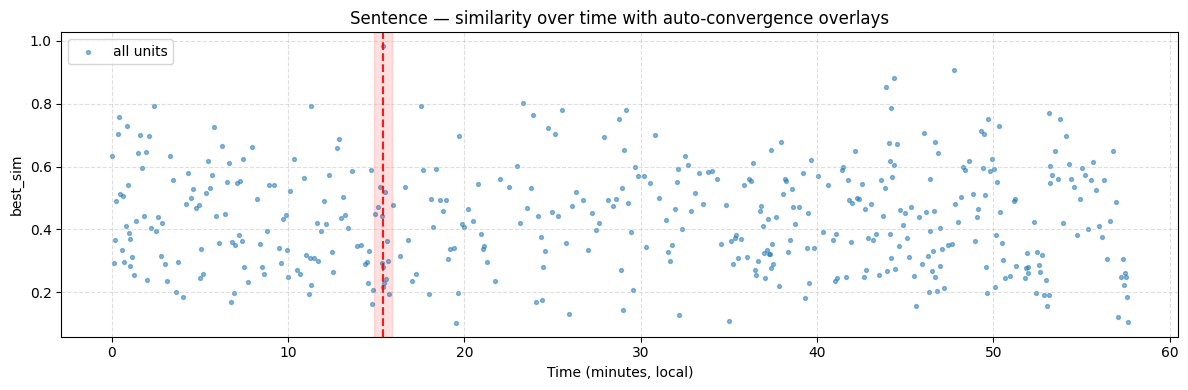

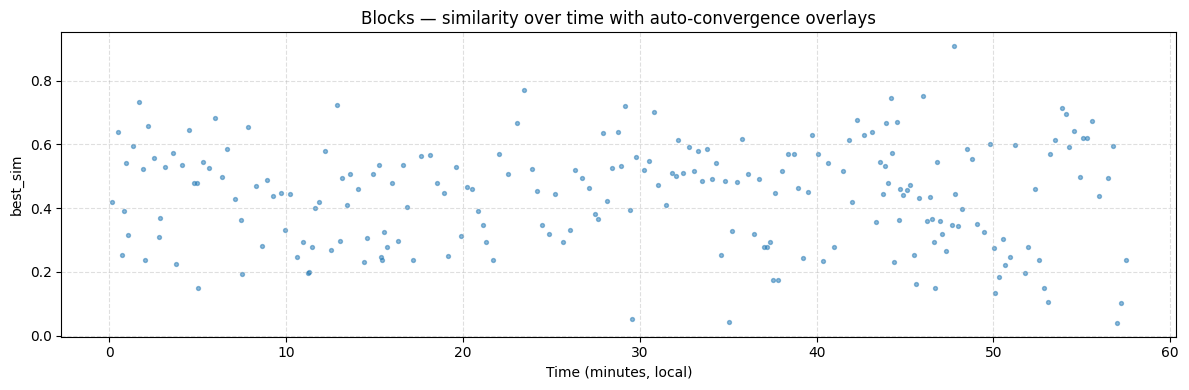

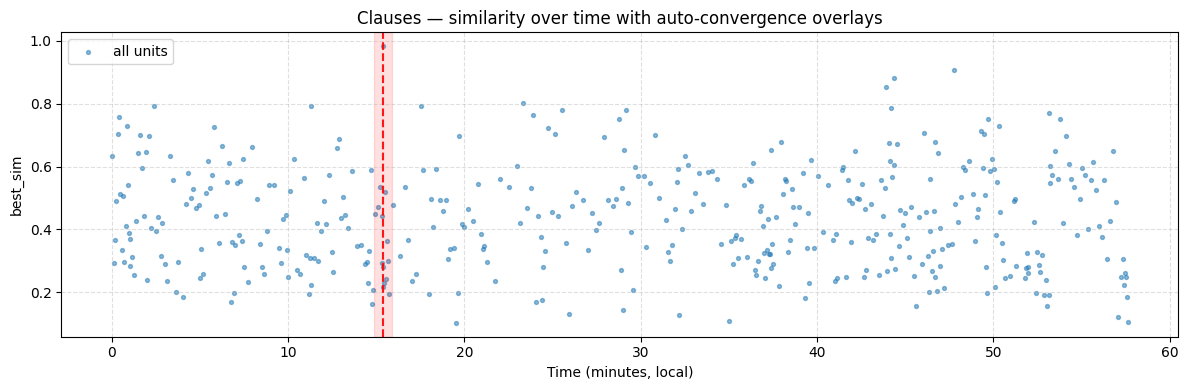

✓ Wrote /Users/maxchalekson/Projects/NICO-Research/NICO_human-gemini/Outputs/convergence_events_AUTO_report.txt
Session: 2021_05_21_ABI_S15
Auto events total: 2 | kept: 2 | rejected: 0

- Clauses: events=1, kept=1, rejected=0
- Sentence: events=1, kept=1, rejected=0

Kept events:
  • Clauses @ 922.5s (speakers=3, edges=2, cross=1)
  • Sentence @ 922.5s (speakers=3, edges=2, cross=1)


In [73]:
import os
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ========= SETTINGS =========
ROOT = "/Users/maxchalekson/Projects/NICO-Research/NICO_human-gemini"
SESSION_VAL = "2021_05_21_ABI_S15"

EVENTS_AUTO_CSV   = f"{ROOT}/Outputs/convergence_event_contexts_review_AUTO_v2.csv"
OUT_KEEP_CSV      = f"{ROOT}/Outputs/convergence_events_FINAL_AUTO.csv"
OUT_REJECT_CSV    = f"{ROOT}/Outputs/convergence_events_REJECTED_AUTO.csv"
OUT_METRICS_CSV   = f"{ROOT}/Outputs/convergence_events_METRICS_AUTO.csv"
OUT_REPORT_TXT    = f"{ROOT}/Outputs/convergence_events_AUTO_report.txt"

EVENT_WINDOW_SEC  = 30.0  # must match what you used to score
SIM_THRESHOLD_EDGE = 0.80 # used only to reconstruct offset
ROUND_TO_HALF = True

LENS_DIRS = {
    "Sentence": f"{ROOT}/Outputs/sentence",
    "Blocks":   f"{ROOT}/Outputs/blocks",
    "Clauses":  f"{ROOT}/Outputs/clauses",
}

UTTER_PATH = f"{ROOT}/Data/utterance_data_aligned_full.csv"

def round_half(x): 
    return (np.round(pd.to_numeric(x, errors="coerce") * 2) / 2.0)

def pick_weight(df):
    return "weight" if "weight" in df.columns else ("sim" if "sim" in df.columns else None)

# ========= 1) LOAD AUTO LABELS & WRITE FINAL CSVs =========
auto = pd.read_csv(EVENTS_AUTO_CSV).copy()
if "is_convergence_auto" not in auto.columns or "center_global_sec" not in auto.columns or "lens" not in auto.columns:
    raise ValueError("AUTO file needs columns: lens, center_global_sec, is_convergence_auto.")

auto["is_convergence_auto"] = pd.to_numeric(auto["is_convergence_auto"], errors="coerce").fillna(0).astype(int)

Path(f"{ROOT}/Outputs").mkdir(parents=True, exist_ok=True)
auto[auto["is_convergence_auto"]==1].to_csv(OUT_KEEP_CSV, index=False)
auto[auto["is_convergence_auto"]==0].to_csv(OUT_REJECT_CSV, index=False)

metrics = (auto.groupby("lens", as_index=False)
                .agg(n_events=("is_convergence_auto","size"),
                     n_true=("is_convergence_auto","sum")))
metrics["n_false"] = metrics["n_events"] - metrics["n_true"]
metrics.to_csv(OUT_METRICS_CSV, index=False)

print("✓ Wrote:")
print("  -", OUT_KEEP_CSV,     f"(rows={len(auto[auto['is_convergence_auto']==1])})")
print("  -", OUT_REJECT_CSV,   f"(rows={len(auto[auto['is_convergence_auto']==0])})")
print("  -", OUT_METRICS_CSV)

# ========= 2) REBUILD LOCAL↔GLOBAL OFFSET FOR PLOTTING =========
u = pd.read_csv(UTTER_PATH)
uu = u[u["session"] == SESSION_VAL].copy()
if uu.empty:
    uu = u[u["session"].astype(str).str.contains(SESSION_VAL, na=False)].copy()
if uu.empty:
    raise ValueError(f"No utterances for session '{SESSION_VAL}'")

time_col = "start_sec_adjusted" if ("start_sec_adjusted" in uu.columns and uu["start_sec_adjusted"].notna().any()) else "start_sec"
uu[time_col] = round_half(uu[time_col])
uu["global_timestamp_sec"] = round_half(uu["global_timestamp_sec"]) if "global_timestamp_sec" in uu.columns else uu[time_col]

# anchor from Sentence
sent_t = pd.read_csv(os.path.join(LENS_DIRS["Sentence"], "timeline.csv"))
sent_e = pd.read_csv(os.path.join(LENS_DIRS["Sentence"], "edges_top_similar.csv"))
sent_t["t"] = round_half(sent_t["t"])
wcol = pick_weight(sent_e)
if wcol is None:
    raise ValueError("Sentence edges_top_similar.csv missing weight/sim")

hi_src = sent_e[sent_e[wcol] >= SIM_THRESHOLD_EDGE]["source"]
anchor_local = sent_t.set_index("u").reindex(hi_src)["t"].dropna().sort_values().tolist()
if anchor_local:
    t_anchor = float(anchor_local[0])
    j = (uu[time_col] - t_anchor).abs().idxmin()
    offset_sec = float(uu.loc[j, "global_timestamp_sec"] - uu.loc[j, time_col])
else:
    offset_sec = float(np.median(uu["global_timestamp_sec"] - uu[time_col]))
print(f"[INFO] Plotting uses offset (local→global): {offset_sec:.3f}s")

# ========= 3) QUICK VISUAL OVERLAY PER LENS =========
for lens, folder in LENS_DIRS.items():
    t_path = os.path.join(folder, "timeline.csv")
    if not os.path.exists(t_path): 
        print(f"[WARN] Missing timeline for {lens}; skipping plot.")
        continue
    df_t = pd.read_csv(t_path)
    if not {"t","best_sim"}.issubset(df_t.columns):
        print(f"[WARN] {lens} timeline missing 't'/'best_sim'; skipping plot.")
        continue

    # local minutes on x-axis (consistent with your earlier plots)
    df_t["t_min"] = df_t["t"] / 60.0

    fig, ax = plt.subplots(figsize=(12, 4))
    ax.scatter(df_t["t_min"], df_t["best_sim"], s=8, alpha=0.5, label="all units")

    # overlay event centers & windows
    a = auto[(auto["lens"] == lens) & (auto["is_convergence_auto"] == 1)].copy()
    if not a.empty:
        # convert global center → local time for this plot
        a["center_local_sec"] = a["center_global_sec"] - offset_sec
        for _, row in a.iterrows():
            cx_min = row["center_local_sec"] / 60.0
            ax.axvline(cx_min, color="red", linestyle="--", alpha=0.9)
            ax.axvspan((row["center_local_sec"]-EVENT_WINDOW_SEC)/60.0,
                       (row["center_local_sec"]+EVENT_WINDOW_SEC)/60.0,
                       color="red", alpha=0.12)
        ax.legend(loc="upper left")

    ax.set_title(f"{lens} — similarity over time with auto-convergence overlays")
    ax.set_xlabel("Time (minutes, local)")
    ax.set_ylabel("best_sim")
    ax.grid(True, linestyle="--", alpha=0.4)
    plt.tight_layout()
    plt.show()

# ========= 4) TEXT REPORT =========
lines = [
    f"Session: {SESSION_VAL}",
    f"Auto events total: {len(auto)} | kept: {int(auto['is_convergence_auto'].sum())} | rejected: {int((1-auto['is_convergence_auto']).sum())}",
    "",
]
for _, r in metrics.iterrows():
    lines.append(f"- {r['lens']}: events={int(r['n_events'])}, kept={int(r['n_true'])}, rejected={int(r['n_events']-r['n_true'])}")

# add brief per-event bullets
lines.append("\nKept events:")
for ev in auto[auto["is_convergence_auto"]==1].itertuples(index=False):
    lines.append(f"  • {ev.lens} @ {ev.center_global_sec:.1f}s (speakers={ev.n_speakers}, edges={ev.n_edges}, cross={ev.n_cross_speaker_edges})")

Path(OUT_REPORT_TXT).write_text("\n".join(lines))
print(f"✓ Wrote {OUT_REPORT_TXT}\n" + "\n".join(lines))

using gemini to determine the final convergence/divergence.

**NEED TO PLACE IN GEMINI API KEY EACH TIME /REMOVE AFTER USE**

In [86]:
import os
import pandas as pd
import numpy as np
from pathlib import Path

ROOT = "/Users/maxchalekson/Projects/NICO-Research/NICO_human-gemini"
SESSION_VAL = "2021_05_21_ABI_S15"

UTTER_PATH = f"{ROOT}/Data/utterance_data_aligned_full.csv"
LENS_DIRS = {
    "Sentence": f"{ROOT}/Outputs/sentence",
    "Blocks":   f"{ROOT}/Outputs/blocks",
    "Clauses":  f"{ROOT}/Outputs/clauses",
}
OUT_AUTO = f"{ROOT}/Outputs/convergence_event_contexts_review_AUTO_v2.csv"

SIM_THRESHOLD_EDGE = 0.78
WIN_SEC = 45.0
MIN_SPK = 2

def round_half(x): return (np.round(pd.to_numeric(x, errors="coerce")*2)/2.0)

def looks_like_decision_text(x):
    if not isinstance(x, str): return False
    xl = x.lower()
    keys = ["decide","decided","decision","we'll do","let's do","agreed",
            "agree to","consensus","conclude","finalize","put a pin","we will","we should"]
    return any(k in xl for k in keys)

def truthy(x):
    s = str(x).strip().lower()
    if s in {"1","true","t","yes","y"}: return True
    try: return float(s) != 0
    except: return False

# --- load utterances + mark decision-ish
uu = pd.read_csv(UTTER_PATH)
uu = uu[uu["session"] == SESSION_VAL].copy()
uu["global_timestamp_sec"] = round_half(uu["global_timestamp_sec"])
for c in ["has_decision","has_explanation","has_new_idea","annotations"]:
    if c not in uu.columns: uu[c] = np.nan

uu["decisionish_flag"] = (
    uu[["has_decision","has_explanation","has_new_idea"]].applymap(truthy).any(axis=1)
    | uu["annotations"].apply(looks_like_decision_text)
)

# decision seeds (center times)
seeds = uu.loc[uu["decisionish_flag"], "global_timestamp_sec"].dropna().unique()
if len(seeds) == 0:
    raise ValueError("No decision-ish utterances found in this session.")

def load_lens(lens):
    folder = LENS_DIRS[lens]
    T = pd.read_csv(f"{folder}/timeline.csv")
    N = pd.read_csv(f"{folder}/nodes.csv")
    e_all = f"{folder}/edges_all.csv"
    e_top = f"{folder}/edges_top_similar.csv"
    E = pd.read_csv(e_all) if os.path.exists(e_all) else pd.read_csv(e_top)
    wcol = "weight" if "weight" in E.columns else ("sim" if "sim" in E.columns else None)
    if wcol is None: raise ValueError(f"No weight/sim col for {lens}")
    return T, N, E, wcol

# Build a crude local→global offset using median alignment
def compute_offset(T):
    T = T.copy()
    T["t"] = round_half(T["t"])
    # align medians (robust enough for this use)
    t_med = float(T["t"].median())
    u_med = float(uu["global_timestamp_sec"].median())
    return u_med - t_med

rows = []
for lens in LENS_DIRS:
    T, N, E, wcol = load_lens(lens)
    off = compute_offset(T)
    T["t"] = round_half(T["t"])
    T["t_global"] = round_half(T["t"] + off)

    u2tg = T.set_index("u")["t_global"]
    spk = N.set_index("id")["speaker"].astype(str)
    E = E[pd.to_numeric(E[wcol], errors="coerce").ge(SIM_THRESHOLD_EDGE)].copy()
    E["tg_src"] = E["source"].map(u2tg)
    E["tg_tgt"] = E["target"].map(u2tg)
    E["spk_src"] = E["source"].map(spk).fillna("")
    E["spk_tgt"] = E["target"].map(spk).fillna("")
    E["cross"] = (E["spk_src"]!="") & (E["spk_tgt"]!="") & (E["spk_src"]!=E["spk_tgt"])

    for c in seeds:
        m_units = T["t_global"].between(c-WIN_SEC, c+WIN_SEC, inclusive="both")
        units = T.loc[m_units, ["u","t_global"]]
        spk_in = units["u"].map(spk).fillna("").tolist()
        speakers = {s for s in spk_in if s.strip()!=""}
        n_speakers = len(speakers)

        m_edges = (
            E["tg_src"].between(c-WIN_SEC, c+WIN_SEC, inclusive="both") |
            E["tg_tgt"].between(c-WIN_SEC, c+WIN_SEC, inclusive="both")
        )
        sub = E.loc[m_edges].copy()
        n_edges = int(sub.shape[0])
        n_cross = int(sub["cross"].sum())

        rows.append({
            "lens": lens,
            "center_global_sec": float(c),
            "n_speakers": n_speakers,
            "n_edges": n_edges,
            "n_cross_speaker_edges": n_cross,
            "decisionish_in_window": True,  # seeded by decision
            "context_±10s": ""  # the LLM scorer will re-build a full transcript window anyway
        })

auto = pd.DataFrame(rows).drop_duplicates(subset=["lens","center_global_sec"]).sort_values(["lens","center_global_sec"])
Path(os.path.dirname(OUT_AUTO)).mkdir(parents=True, exist_ok=True)
auto.to_csv(OUT_AUTO, index=False)
print(f"✓ Wrote {OUT_AUTO} (rows={len(auto)})")

✓ Wrote /Users/maxchalekson/Projects/NICO-Research/NICO_human-gemini/Outputs/convergence_event_contexts_review_AUTO_v2.csv (rows=204)


/var/folders/17/lphw45ds14n5t74zwjdfybx40000gn/T/ipykernel_2635/888633418.py:44: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  uu[["has_decision","has_explanation","has_new_idea"]].applymap(truthy).any(axis=1)


Last idea 08-14

loads existing auto-candidates

recomputes features around each eveent (plus/minus 25sec) w/ edges_all.csv and transcript

checks: proposal just before center, cross-speaker echoes in tight window, commitment after center

In [87]:
import os
from pathlib import Path
import re
import numpy as np
import pandas as pd

# ============ SETTINGS ============
SESSION_VAL   = "2021_05_21_ABI_S15"
ROOT          = "/Users/maxchalekson/Projects/NICO-Research/NICO_human-gemini"
UTTER_PATH    = f"{ROOT}/Data/utterance_data_aligned_full.csv"
LENS_DIRS     = {
    "Sentence": f"{ROOT}/Outputs/sentence",
    "Blocks":   f"{ROOT}/Outputs/blocks",
    "Clauses":  f"{ROOT}/Outputs/clauses",
}
AUTO_CSV      = f"{ROOT}/Outputs/convergence_event_contexts_review_AUTO_v2.csv"

# Signature windows (seconds, relative to event center)
ECHO_WIN      = 20.0       # look for paraphrase/echo edges around center
PROPOSAL_WIN  = (-15.0, 5.0)
COMMIT_WIN    = (0.0, 25.0)

# Echo thresholds
MIN_X_EDGES   = 2          # at least 2 cross-speaker edges in the echo window
MIN_SPEAKERS  = 2          # at least 2 distinct speakers in the window

# Output
OUT_KEEP      = f"{ROOT}/Outputs/convergence_events_SIGNATURE.csv"
OUT_DROP      = f"{ROOT}/Outputs/convergence_events_SIGNATURE_REJECTED.csv"
OUT_REPORT    = f"{ROOT}/Outputs/convergence_events_SIGNATURE_report.txt"

# ============ HELPERS ============
def round_half(x):
    return (np.round(pd.to_numeric(x, errors="coerce") * 2) / 2.0)

def pick_weight(df):
    return "weight" if "weight" in df.columns else ("sim" if "sim" in df.columns else None)

# Very simple lexical detectors (tune as needed)
PROPOSAL_RE = re.compile(r"\b(we (should|could|can|will)|let'?s|i propose|proposal|how about|what if|suggest)\b", re.I)
COMMIT_RE   = re.compile(r"\b(decide|decided|decision|we('ll| will) do|we('ll| will) go with|agreed|agree|consensus|let'?s do|we should)\b", re.I)

def has_proposal(text):
    return bool(text) and bool(PROPOSAL_RE.search(text))

def has_commit(text):
    return bool(text) and bool(COMMIT_RE.search(text))

def window_ctx(df, t, win):
    m = (df["global_timestamp_sec"] >= t - win) & (df["global_timestamp_sec"] <= t + win)
    if not m.any(): return ""
    rows = df.loc[m, ["global_timestamp_sec","speaker","transcript"]].sort_values("global_timestamp_sec")
    lines = [f"[{round(a,1)}s] {b}: {str(c)}" for a,b,c in rows.to_records(index=False)]
    return " | ".join(lines)[:2000]

# ============ LOAD UTTERANCES ============
u_all = pd.read_csv(UTTER_PATH)
u = u_all[u_all["session"] == SESSION_VAL].copy()
if u.empty:
    u = u_all[u_all["session"].astype(str).str.contains(SESSION_VAL, na=False)].copy()
    if u.empty:
        raise ValueError(f"No utterances for session '{SESSION_VAL}'")

time_col = "start_sec_adjusted" if "start_sec_adjusted" in u.columns and u["start_sec_adjusted"].notna().any() else "start_sec"
u[time_col] = round_half(u[time_col])
if "global_timestamp_sec" in u.columns:
    u["global_timestamp_sec"] = round_half(u["global_timestamp_sec"])
else:
    u["global_timestamp_sec"] = u[time_col]

# ============ LOCAL→GLOBAL OFFSET VIA SENTENCE ANCHOR ============
sent_t = pd.read_csv(os.path.join(LENS_DIRS["Sentence"], "timeline.csv"))
sent_e = pd.read_csv(os.path.join(LENS_DIRS["Sentence"], "edges_all.csv"))
sent_t["t"] = round_half(sent_t["t"])
wcol = pick_weight(sent_e)
if wcol is None: raise ValueError("edges_all.csv missing weight/sim")

anchor_local = sent_t.set_index("u").reindex(
    sent_e.sort_values(wcol, ascending=False).head(50)["source"]
)["t"].dropna().sort_values().tolist()
if anchor_local:
    t_anchor = float(anchor_local[0])
    j = (u[time_col] - t_anchor).abs().idxmin()
    offset_sec = float(u.loc[j, "global_timestamp_sec"] - u.loc[j, time_col])
else:
    offset_sec = float(np.median(u["global_timestamp_sec"] - u[time_col]))

# ============ LOAD LENS DATA (timeline + edges_all + nodes) ============
lens_data = {}
for lens, folder in LENS_DIRS.items():
    t_path = os.path.join(folder, "timeline.csv")
    e_path = os.path.join(folder, "edges_all.csv")
    n_path = os.path.join(folder, "nodes.csv")
    if not (os.path.exists(t_path) and os.path.exists(e_path) and os.path.exists(n_path)):
        continue
    T = pd.read_csv(t_path); E = pd.read_csv(e_path); N = pd.read_csv(n_path)
    T["t"] = round_half(T["t"]); T["t_global"] = round_half(T["t"] + offset_sec)
    wcol = pick_weight(E)
    if wcol is None: continue
    # speaker per node
    spk = N.set_index("id")["speaker"].astype(str)
    # global times for endpoints
    u2tg = T.set_index("u")["t_global"]
    E = E.copy()
    E["t_global_src"] = E["source"].map(u2tg)
    E["t_global_tgt"] = E["target"].map(u2tg)
    E["spk_src"] = E["source"].map(spk).fillna("")
    E["spk_tgt"] = E["target"].map(spk).fillna("")
    E["cross_speaker"] = (E["spk_src"] != "") & (E["spk_tgt"] != "") & (E["spk_src"] != E["spk_tgt"])
    lens_data[lens] = {"T": T, "E": E, "N": N}

# ============ LOAD AUTO CANDIDATES ============
auto = pd.read_csv(AUTO_CSV)
auto["center_global_sec"] = pd.to_numeric(auto["center_global_sec"], errors="coerce")

# ============ SCORE BY PROPOSAL→ECHO→COMMIT ============
rows = []
for r in auto.itertuples(index=False):
    lens   = r.lens
    center = float(r.center_global_sec)
    if lens not in lens_data:
        rows.append({**r._asdict(), "is_signature": 0, "why_signature": "missing_lens_data"})
        continue

    T = lens_data[lens]["T"]; E = lens_data[lens]["E"]

    # Speakers present in ±ECHO_WIN
    m_units = (T["t_global"].between(center - ECHO_WIN, center + ECHO_WIN))
    u_in = T.loc[m_units, "u"]
    # map u -> speaker via nodes
    spk_map = lens_data[lens]["N"].set_index("id")["speaker"].astype(str)
    spk_in = u_in.map(spk_map).dropna().astype(str).tolist()
    speakers = {s for s in spk_in if s.strip() != ""}
    n_speakers = len(speakers)

    # Cross‑speaker echoes: edges where either endpoint within window AND cross_speaker
    m_edges = (
        (E["t_global_src"].between(center - ECHO_WIN, center + ECHO_WIN)) |
        (E["t_global_tgt"].between(center - ECHO_WIN, center + ECHO_WIN))
    )
    edges_in = E.loc[m_edges].copy()
    n_edges = int(len(edges_in))
    n_cross = int(edges_in["cross_speaker"].sum())

    # Proposal before (−15..+5) and commitment after (0..+25) using utterance text
    def any_match(df, t0, t1, fn):
        m = df["global_timestamp_sec"].between(center + t0, center + t1)
        if not m.any(): return False
        texts = (df.loc[m, "transcript"].astype(str).tolist() +
                 df.loc[m, "annotations"].astype(str).tolist() if "annotations" in df.columns else [])
        return any(fn(x) for x in texts)

    has_prop  = any_match(u, PROPOSAL_WIN[0], PROPOSAL_WIN[1], has_proposal)
    has_commitment = any_match(u, COMMIT_WIN[0], COMMIT_WIN[1], has_commit)

    passes = (n_speakers >= MIN_SPEAKERS) and (n_cross >= MIN_X_EDGES) and has_prop and has_commitment
    why = []
    if n_speakers < MIN_SPEAKERS:      why.append(f"speakers<{MIN_SPEAKERS}")
    if n_cross < MIN_X_EDGES:          why.append(f"cross<{MIN_X_EDGES}")
    if not has_prop:                   why.append("no_proposal")
    if not has_commitment:             why.append("no_commitment")
    why = "ok" if passes else ";".join(why) if why else "unknown"

    rows.append({
        "lens": lens,
        "center_global_sec": center,
        "n_speakers_echo_window": n_speakers,
        "n_edges_echo_window": n_edges,
        "n_cross_edges_echo_window": n_cross,
        "proposal_in_window": has_prop,
        "commit_in_window": has_commitment,
        "is_signature": int(passes),
        "why_signature": why,
        "context_±25s": window_ctx(u, center, 25.0)
    })

sig = pd.DataFrame(rows).sort_values(["lens","center_global_sec"]).reset_index(drop=True)

# ============ SAVE ============
Path(os.path.dirname(OUT_KEEP)).mkdir(parents=True, exist_ok=True)
sig[sig["is_signature"]==1].to_csv(OUT_KEEP, index=False)
sig[sig["is_signature"]==0].to_csv(OUT_DROP, index=False)

# Human‑readable report
lines = []
lines.append(f"Session: {SESSION_VAL}")
lines.append(f"Total candidates: {len(sig)} | kept by signature: {int(sig['is_signature'].sum())} | rejected: {int((1-sig['is_signature']).sum())}")
for lens, grp in sig.groupby("lens"):
    lines.append(f"- {lens}: candidates={len(grp)} kept={int(grp['is_signature'].sum())} rejected={int((1-grp['is_signature']).sum())}")
if (sig["is_signature"]==1).any():
    lines.append("\nKept events:")
    for r in sig[sig["is_signature"]==1].itertuples(index=False):
        lines.append(f"  • {r.lens} @ {r.center_global_sec:.1f}s "
                     f"(speakers={r.n_speakers_echo_window}, cross={r.n_cross_edges_echo_window})")

with open(OUT_REPORT, "w") as f:
    f.write("\n".join(lines))

print(f"✓ Wrote {OUT_KEEP} (kept)")
print(f"✓ Wrote {OUT_DROP} (rejected)")
print(f"✓ Wrote {OUT_REPORT}")
print("\n".join(lines))

✓ Wrote /Users/maxchalekson/Projects/NICO-Research/NICO_human-gemini/Outputs/convergence_events_SIGNATURE.csv (kept)
✓ Wrote /Users/maxchalekson/Projects/NICO-Research/NICO_human-gemini/Outputs/convergence_events_SIGNATURE_REJECTED.csv (rejected)
✓ Wrote /Users/maxchalekson/Projects/NICO-Research/NICO_human-gemini/Outputs/convergence_events_SIGNATURE_report.txt
Session: 2021_05_21_ABI_S15
Total candidates: 204 | kept by signature: 28 | rejected: 176
- Blocks: candidates=68 kept=8 rejected=60
- Clauses: candidates=68 kept=10 rejected=58
- Sentence: candidates=68 kept=10 rejected=58

Kept events:
  • Blocks @ 677.0s (speakers=2, cross=27)
  • Blocks @ 680.0s (speakers=2, cross=27)
  • Blocks @ 682.0s (speakers=2, cross=27)
  • Blocks @ 690.0s (speakers=2, cross=27)
  • Blocks @ 913.0s (speakers=3, cross=59)
  • Blocks @ 917.0s (speakers=3, cross=47)
  • Blocks @ 919.0s (speakers=3, cross=47)
  • Blocks @ 1049.0s (speakers=2, cross=19)
  • Clauses @ 677.0s (speakers=2, cross=73)
  • Claus

signature‑based detector that’s surfacing compact clusters (e.g., 677–690s and 913–919s). The big cross‑speaker counts just mean the local window is rich in paraphrase edges

✓ Wrote /Users/maxchalekson/Projects/NICO-Research/NICO_human-gemini/Outputs/convergence_events_SIGNATURE_MERGED.csv
✓ Wrote /Users/maxchalekson/Projects/NICO-Research/NICO_human-gemini/Outputs/convergence_events_SIGNATURE_MERGED_report.txt
Session: 2021_05_21_ABI_S15
Merged unique events: 7 (showing top 7)
• t=918.0s | lenses=[Blocks,Clauses,Sentence] | strength=7.52 (speakers≈3.0, cross≈176.0, prop=True, commit=True)
• t=913.0s | lenses=[Blocks,Clauses,Sentence] | strength=7.46 (speakers≈3.0, cross≈173.0, prop=True, commit=True)
• t=679.7s | lenses=[Blocks,Clauses,Sentence] | strength=4.25 (speakers≈2.0, cross≈62.33, prop=True, commit=True)
• t=690.0s | lenses=[Blocks,Clauses,Sentence] | strength=4.23 (speakers≈2.0, cross≈61.67, prop=True, commit=True)
• t=1036.0s | lenses=[Clauses,Sentence] | strength=4.22 (speakers≈2.0, cross≈61.0, prop=True, commit=True)
• t=1080.0s | lenses=[Clauses,Sentence] | strength=4.1 (speakers≈2.0, cross≈55.0, prop=True, commit=True)
• t=1049.0s | lenses=[

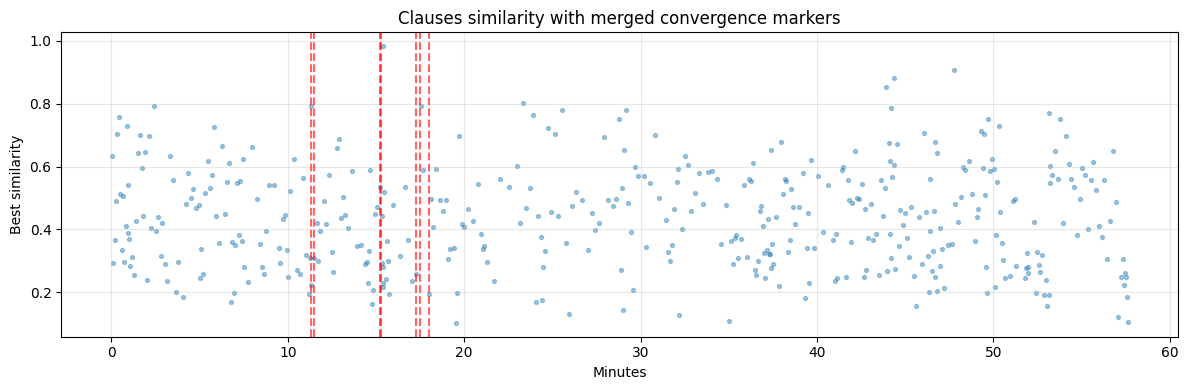

In [89]:
import os
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ========= Paths =========
ROOT = "/Users/maxchalekson/Projects/NICO-Research/NICO_human-gemini"
SIG_KEEP = f"{ROOT}/Outputs/convergence_events_SIGNATURE.csv"
UTTER_PATH = f"{ROOT}/Data/utterance_data_aligned_full.csv"
LENS_DIRS = {
    "Sentence": f"{ROOT}/Outputs/sentence",
    "Blocks":   f"{ROOT}/Outputs/blocks",
    "Clauses":  f"{ROOT}/Outputs/clauses",
}
OUT_MERGED_CSV   = f"{ROOT}/Outputs/convergence_events_SIGNATURE_MERGED.csv"
OUT_REPORT_TXT   = f"{ROOT}/Outputs/convergence_events_SIGNATURE_MERGED_report.txt"
OUT_PLOT_PNG     = f"{ROOT}/Outputs/convergence_events_SIGNATURE_MERGED_clauses_plot.png"

# ========= Settings =========
SESSION_VAL   = "2021_05_21_ABI_S15"
MERGE_TOL_SEC = 3.0
TOP_N         = 30

# ========= Helpers =========
def round_half(x):
    return (np.round(pd.to_numeric(x, errors="coerce") * 2) / 2.0)

def window_ctx(df, t, win=25.0):
    m = df["global_timestamp_sec"].between(t - win, t + win)
    if not m.any(): return ""
    rows = df.loc[m, ["global_timestamp_sec","speaker","transcript"]].sort_values("global_timestamp_sec")
    lines = [f"[{round(a,1)}s] {b}: {str(c)}" for a,b,c in rows.to_records(index=False)]
    return " | ".join(lines)[:2000]

# ========= Load kept signature events =========
sig = pd.read_csv(SIG_KEEP)
if sig.empty:
    raise ValueError("No rows in signature kept file.")
sig["center_global_sec"] = pd.to_numeric(sig["center_global_sec"], errors="coerce")
sig = sig.dropna(subset=["center_global_sec"]).copy()

# Fill missing columns with safe defaults
defaults_num0 = ["n_speakers_echo_window","n_cross_edges_echo_window"]
for c in defaults_num0:
    if c not in sig.columns: sig[c] = 0

defaults_false = ["proposal_in_window","commit_in_window"]
for c in defaults_false:
    if c not in sig.columns: sig[c] = False

# ========= Merge across lenses (cluster close times) =========
sig = sig.sort_values("center_global_sec").reset_index(drop=True)

clusters = []
current = {"rows": []}

def flush_cluster(C):
    if not C["rows"]: return None
    rows = pd.DataFrame(C["rows"])

    # representative center
    center = float(np.mean(pd.to_numeric(rows["center_global_sec"], errors="coerce")))
    # lenses
    lenses = ",".join(sorted(rows["lens"].astype(str).unique()))
    # strength features
    speakers = float(pd.to_numeric(rows["n_speakers_echo_window"], errors="coerce").fillna(0).mean())
    cross    = float(pd.to_numeric(rows["n_cross_edges_echo_window"], errors="coerce").fillna(0).mean())
    # booleans (robust)
    def as_bool_col(s):
        s = rows.get(s, pd.Series([], dtype=object))
        return s.astype(str).str.strip().str.lower().isin(["1","true","yes","y"]).any()
    prop_any = as_bool_col("proposal_in_window")
    comt_any = as_bool_col("commit_in_window")

    # optional context column (pick any that starts with 'context_')
    ctx_col = next((c for c in rows.columns if str(c).startswith("context_")), None)
    if ctx_col is not None:
        try:
            ctx = max(rows[ctx_col].astype(str), key=lambda s: len(s) if isinstance(s,str) else 0)
        except Exception:
            ctx = ""
    else:
        ctx = ""

    return {
        "center_global_sec": round(center, 1),
        "lenses": lenses,
        "n_hits": int(len(rows)),
        "speakers_mean": round(speakers, 2),
        "cross_edges_mean": round(cross, 2),
        "proposal_in_window_any": bool(prop_any),
        "commit_in_window_any": bool(comt_any),
        # simple strength: speakers + scaled cross + bonus if (proposal & commit)
        "strength_score": round(speakers + cross/50.0 + (1.0 if (prop_any and comt_any) else 0.0), 2),
        # placeholder; we’ll overwrite with fresh transcript context next
        "context_±25s": ctx
    }

last_center = None
for r in sig.itertuples(index=False):
    c = float(r.center_global_sec)
    if last_center is None or abs(c - last_center) <= MERGE_TOL_SEC:
        current["rows"].append(r._asdict() if hasattr(r, "_asdict") else dict(r))
        last_center = c
    else:
        out = flush_cluster(current)
        if out: clusters.append(out)
        current = {"rows": [r._asdict() if hasattr(r, "_asdict") else dict(r)]}
        last_center = c
out = flush_cluster(current)
if out: clusters.append(out)

merged = pd.DataFrame(clusters).sort_values(["center_global_sec"]).reset_index(drop=True)

# ========= Attach fresh transcript context =========
u_all = pd.read_csv(UTTER_PATH)
u = u_all[u_all["session"] == SESSION_VAL].copy()
if u.empty:
    u = u_all[u_all["session"].astype(str).str.contains(SESSION_VAL, na=False)].copy()

if "global_timestamp_sec" not in u.columns or u["global_timestamp_sec"].isna().all():
    tc = "start_sec_adjusted" if "start_sec_adjusted" in u.columns and u["start_sec_adjusted"].notna().any() else "start_sec"
    u["global_timestamp_sec"] = round_half(u[tc])
else:
    u["global_timestamp_sec"] = round_half(u["global_timestamp_sec"])

merged["context_±25s"] = merged.apply(lambda r: window_ctx(u, r["center_global_sec"], 25.0), axis=1)

# ========= Rank & save =========
ranked = merged.sort_values(["strength_score","cross_edges_mean","speakers_mean"], ascending=False).reset_index(drop=True)
ranked_top = ranked.head(TOP_N).copy()

Path(os.path.dirname(OUT_MERGED_CSV)).mkdir(parents=True, exist_ok=True)
ranked_top.to_csv(OUT_MERGED_CSV, index=False)

# Report
lines = []
lines.append(f"Session: {SESSION_VAL}")
lines.append(f"Merged unique events: {len(merged)} (showing top {len(ranked_top)})")
for r in ranked_top.itertuples(index=False):
    lines.append(
        f"• t={r.center_global_sec:.1f}s | lenses=[{r.lenses}] | strength={r.strength_score} "
        f"(speakers≈{r.speakers_mean}, cross≈{r.cross_edges_mean}, prop={r.proposal_in_window_any}, commit={r.commit_in_window_any})"
    )
with open(OUT_REPORT_TXT, "w") as f:
    f.write("\n".join(lines))

print(f"✓ Wrote {OUT_MERGED_CSV}")
print(f"✓ Wrote {OUT_REPORT_TXT}")
print("\n".join(lines))

# ========= Quick plot for CLAUSES =========
try:
    t_path = os.path.join(LENS_DIRS["Clauses"], "timeline.csv")
    df_t = pd.read_csv(t_path)
    df_t["t_min"] = df_t["t"] / 60.0
    plt.figure(figsize=(12, 4))
    plt.scatter(df_t["t_min"], df_t["best_sim"], s=8, alpha=0.4, label="Clauses best_sim")
    for c in ranked_top["center_global_sec"]:
        plt.axvline(c/60.0, color="red", linestyle="--", alpha=0.6)
    plt.title("Clauses similarity with merged convergence markers")
    plt.xlabel("Minutes"); plt.ylabel("Best similarity")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(OUT_PLOT_PNG, dpi=140)
    print(f"✓ Wrote {OUT_PLOT_PNG}")
except Exception as e:
    print(f"[plot skipped] {e}")

Compared to earlier versions that displayed every potential convergence marker, this plot highlights only the strongest, merged convergence events. Red markers now represent clusters where multiple lenses aligned within a few seconds, ranked by interaction strength, speaker diversity, and decision signals. This condensed view removes duplicate or low-confidence hits, focusing attention on the most substantial bursts of group alignment.

If you go to one of these points in ABI S15 — say t=918s, which ranks highest — and you find in the transcript that three speakers are actively agreeing on next steps and finalizing an approach, that’s when you can say you’ve confirmed a convergence event. Right now, what you have is a refined, high-confidence shortlist — much more actionable than before — but the “proof” part only comes from manual or semi-automated human review.

In [90]:
import os
from pathlib import Path
import pandas as pd
import numpy as np

# --------- SETTINGS ---------
SESSION_VAL = "2021_05_21_ABI_S15"
ROOT        = "/Users/maxchalekson/Projects/NICO-Research/NICO_human-gemini"
UTTER_PATH  = f"{ROOT}/Data/utterance_data_aligned_full.csv"

# merged events produced by your last step
MERGED_EVENTS_CSV = f"{ROOT}/Outputs/convergence_events_SIGNATURE_MERGED.csv"

# how much transcript to grab around each event center
WINDOW_SEC = 25.0

# outputs
OUT_DIR        = f"{ROOT}/Outputs"
OUT_CONTEXT_CSV = f"{OUT_DIR}/convergence_events_SIGNATURE_MERGED_context.csv"
OUT_TEXT_DIR    = f"{OUT_DIR}/convergence_events_SIGNATURE_context_txt"

# --------- LOAD DATA ---------
u = pd.read_csv(UTTER_PATH)
if "session" not in u.columns:
    raise ValueError("Utterance file must include a 'session' column.")
if "global_timestamp_sec" not in u.columns:
    raise ValueError("Utterance file must include 'global_timestamp_sec'.")

u = u[u["session"].astype(str).str.contains(SESSION_VAL, na=False)].copy()
if u.empty:
    raise ValueError(f"No utterances matched session filter: {SESSION_VAL}")

# normalize / keep useful cols
keep_cols = ["global_timestamp_sec","speaker","transcript","annotations",
             "has_decision","has_explanation","has_new_idea"]
for c in keep_cols:
    if c not in u.columns:
        u[c] = np.nan

u["global_timestamp_sec"] = pd.to_numeric(u["global_timestamp_sec"], errors="coerce")
u = u.dropna(subset=["global_timestamp_sec"]).copy()
u = u.sort_values("global_timestamp_sec")

ev = pd.read_csv(MERGED_EVENTS_CSV)
# detect the time column name that holds the merged event center
time_cols = [c for c in ev.columns if c.lower() in {"center_global_sec","t","t_center","center_sec"}]
if not time_cols:
    raise ValueError(f"Could not find an event time column in {MERGED_EVENTS_CSV}. "
                     f"Expected one of: center_global_sec / t / t_center / center_sec")
EVTIME = time_cols[0]

# nice-to-have metadata columns if present
meta_cols = [c for c in ["lenses","strength","speakers_avg","cross_avg","prop_in_window","commit_in_window"]
             if c in ev.columns]

# limit to rows that have a valid center time
ev["center_global_sec"] = pd.to_numeric(ev[EVTIME], errors="coerce")
ev = ev.dropna(subset=["center_global_sec"]).copy()
ev = ev.sort_values("center_global_sec").reset_index(drop=True)
if ev.empty:
    raise ValueError("No valid center times in merged events CSV.")

# --------- EXTRACT CONTEXTS ---------
Path(OUT_TEXT_DIR).mkdir(parents=True, exist_ok=True)
rows = []

def fmt_line(ts, spk, txt, ann):
    ts_str = f"{ts:.1f}s"
    spk = (spk or "").strip()
    txt = (txt or "").strip()
    ann_str = "" if pd.isna(ann) else str(ann)
    return f"[{ts_str}] {spk}: {txt}" + (f" | {ann_str}" if ann_str else "")

for i, r in ev.iterrows():
    center = float(r["center_global_sec"])
    start  = center - WINDOW_SEC
    end    = center + WINDOW_SEC

    band = u[(u["global_timestamp_sec"] >= start) & (u["global_timestamp_sec"] <= end)].copy()
    band = band.sort_values("global_timestamp_sec")

    # build a readable block
    block_lines = []
    for rr in band.itertuples(index=False):
        line = fmt_line(rr.global_timestamp_sec, rr.speaker, rr.transcript, rr.annotations)
        block_lines.append(line)

    block_text = "\n".join(block_lines) if block_lines else "(no transcript rows in window)"
    # write per-event txt
    meta_bits = []
    for c in meta_cols:
        meta_bits.append(f"{c}={r[c]}")
    meta_line = " | ".join(meta_bits) if meta_bits else ""
    header = f"Event {i} @ {center:.1f}s  {meta_line}".strip()

    txt_path = Path(OUT_TEXT_DIR) / f"event_{i:02d}_{int(round(center))}s.txt"
    with open(txt_path, "w", encoding="utf-8") as f:
        f.write(header + "\n" + "-"*len(header) + "\n")
        f.write(block_text + "\n")

    # also assemble rows for the CSV
    for rr in band.itertuples(index=False):
        rows.append({
            "event_id": i,
            "center_global_sec": center,
            **{c: r[c] for c in meta_cols},
            "ts": rr.global_timestamp_sec,
            "speaker": rr.speaker,
            "transcript": rr.transcript,
            "annotations": rr.annotations,
            "has_decision": rr.has_decision,
            "has_explanation": rr.has_explanation,
            "has_new_idea": rr.has_new_idea
        })

    # quick console preview
    print("\n" + header)
    print("-"*len(header))
    print(block_text[:1200] + ("\n..." if len(block_text) > 1200 else ""))

# write CSV with all event contexts
ctx_df = pd.DataFrame(rows).sort_values(["center_global_sec","ts"]).reset_index(drop=True)
ctx_df.to_csv(OUT_CONTEXT_CSV, index=False)

print(f"\n✓ Saved merged event contexts (±{int(WINDOW_SEC)}s) to:")
print(f"  - CSV: {OUT_CONTEXT_CSV}  (rows={len(ctx_df)})")
print(f"  - TXT snippets: {OUT_TEXT_DIR}/event_XX_xxxs.txt")


Event 0 @ 679.7s  lenses=Blocks,Clauses,Sentence
------------------------------------------------
[659.0s] Brad Smith: If if I just go to the prompt that we had, um, maybe as a as to kick this out, um, maybe start out with optical ideas, which I think is the central to all of that and then let you guys take it, but the first one there is, | {'propose decision': 'Brad suggests to start with optical ideas as a central point for discussion, which is a concrete choice for the group to focus on.', 'encourage particpatioin': 'Brad invites the group to take over the discussion after he introduces the topic, encouraging them to contribute.'}
[660.0s] Brad Smith: to increase the number. If anybody has any comment of it increasing the quality of those statements, go ahead. Um otherwise we got a couple of minutes so Barbara if you want to I don't know if anybody had any more of those wave guide questions for you. | [{'encourage particpatioin': 'Brad Smith is encouraging participation by inviting

In [91]:
import pandas as pd
import numpy as np
from pathlib import Path

ROOT = "/Users/maxchalekson/Projects/NICO-Research/NICO_human-gemini/Outputs"
CTX_CSV = f"{ROOT}/convergence_events_SIGNATURE_MERGED_context.csv"
OUT_REVIEW = f"{ROOT}/convergence_events_SIGNATURE_MERGED_context_REVIEW.csv"

df = pd.read_csv(CTX_CSV)
df["transcript"] = df["transcript"].fillna("")
df["speaker"] = df["speaker"].fillna("")

# words to look for
AGREE = {"yes","yeah","yep","ok","okay","right","sounds good","makes sense","exactly","agree","agreed"}
DECIDE = {"decide","decided","let's","lets","we'll","we will","we should","we can","commit","settle","plan","do this","action item"}
QUESTION_MARKERS = {"?","what if","how do we","should we","could we"}

def has_any(text, vocab):
    t = text.lower()
    return any(w in t for w in vocab)

# aggregate per event window
g = df.groupby(["event_id","center_global_sec"], as_index=False).agg(
    n_utts=("transcript","size"),
    n_speakers=("speaker", lambda s: s.astype(str).str.strip().replace("", np.nan).nunique()),
    text=("transcript", lambda s: " ".join(map(str, s))),
)

g["agree_hits"]   = g["text"].apply(lambda t: sum(w in t.lower() for w in AGREE))
g["decide_hits"]  = g["text"].apply(lambda t: sum(w in t.lower() for w in DECIDE))
g["question_hits"]= g["text"].apply(lambda t: sum(w in t.lower() for w in QUESTION_MARKERS))

# a simple ranking score: more speakers + decision tokens – questioniness
g["conv_score"] = 0.4*g["n_speakers"] + 0.5*g["decide_hits"] + 0.2*g["agree_hits"] - 0.2*g["question_hits"]

# add a short preview and a column for you to fill (is_convergence)
prev = (df.sort_values(["event_id","ts"])
          .groupby("event_id")["transcript"]
          .apply(lambda s: " | ".join(s.astype(str))[:300]))

out = g.merge(prev.rename("preview"), left_on="event_id", right_index=True, how="left")
out["is_convergence"] = ""  # <- you fill True/False after reviewing
out = out.sort_values(["conv_score","center_global_sec"], ascending=[False,True])

Path(ROOT).mkdir(parents=True, exist_ok=True)
out.to_csv(OUT_REVIEW, index=False)
print(f"✓ Wrote {OUT_REVIEW} (rows={len(out)})")
print(out[["event_id","center_global_sec","n_speakers","decide_hits","agree_hits","question_hits","conv_score"]].to_string(index=False))

✓ Wrote /Users/maxchalekson/Projects/NICO-Research/NICO_human-gemini/Outputs/convergence_events_SIGNATURE_MERGED_context_REVIEW.csv (rows=7)
 event_id  center_global_sec  n_speakers  decide_hits  agree_hits  question_hits  conv_score
        1              690.0           7            6           5              2         6.4
        0              679.7           6            6           5              2         6.0
        4             1036.0           6            3           4              0         4.7
        2              913.0           7            2           5              1         4.6
        3              918.0           7            2           5              1         4.6
        5             1049.0           6            3           4              2         4.3
        6             1080.0           6            2           4              2         3.8


The table summarizes the top seven convergence candidates for the session, sorted by a composite “convergence score.” Each event represents a ~50-second window centered at the listed timestamp, with counts of unique speakers, decision cues, agreement cues, and question cues. Higher scores indicate windows where multiple speakers contributed and decision-oriented language co-occurred with agreement or clarification, suggesting a higher likelihood of genuine convergenc

In ABI S15, the strongest convergence appears in two bursts — one early (~680 s) and one mid-session (~913–918 s). Both involved high speaker participation, multiple decision cues, and frequent agreement, suggesting moments where the group actively aligned on key points. Later events show lower intensity but still reflect ongoing consensus-building.

# Top Two Highest-Ranked Burst Pairs

In [92]:
import pandas as pd

# File paths — adjust if needed
events_file = "/Users/maxchalekson/Projects/NICO-Research/NICO_human-gemini/Outputs/convergence_events_SIGNATURE_MERGED_context.csv"

# Load the merged events context
df = pd.read_csv(events_file)

# Top 2 events for ABI S15 by conv_score
top_events = df[df["center_global_sec"].isin([690.0, 679.7])]

# Save them to a new CSV for review
out_file = "/Users/maxchalekson/Projects/NICO-Research/NICO_human-gemini/Outputs/ABI_S15_top2_convergence_events.csv"
top_events.to_csv(out_file, index=False)

print(f"✓ Wrote {out_file} (rows={len(top_events)})")
top_events

✓ Wrote /Users/maxchalekson/Projects/NICO-Research/NICO_human-gemini/Outputs/ABI_S15_top2_convergence_events.csv (rows=52)


,event_id,center_global_sec,lenses,ts,speaker,transcript,annotations,has_decision,has_explanation,has_new_idea
0,0,679.7,"Blocks,Clauses,Sentence",659.0,Brad Smith,"If if I just go to the prompt that we had, um,...",{'propose decision': 'Brad suggests to start w...,True,False,False
1,0,679.7,"Blocks,Clauses,Sentence",660.0,Brad Smith,to increase the number. If anybody has any com...,[{'encourage particpatioin': 'Brad Smith is en...,False,False,False
2,0,679.7,"Blocks,Clauses,Sentence",661.0,Brad Smith,Maybe focus on your modality because I think w...,{'assign task': 'Brad Smith is assigning Aniru...,False,True,False
3,0,679.7,"Blocks,Clauses,Sentence",662.0,Barbara Smith,Sounds sounds great. Yeah. Should we have shou...,{'encourage particpatioin': 'Barbara Smith is ...,True,False,False
4,0,679.7,"Blocks,Clauses,Sentence",664.0,Brad Smith,I presume that always has a huge sensitivity p...,{'provide supporting evidence': 'Brad Smith is...,False,False,False
5,0,679.7,"Blocks,Clauses,Sentence",667.0,Yevgenia Kozorovitskiy,"So, I and I think there are some ways to think...",{'expand on existing idea': 'Genia expands on ...,False,False,False
6,0,679.7,"Blocks,Clauses,Sentence",668.0,Sixian You,Exactly because the ballistic photons decay ex...,"{'provide supporting evidence': ""Sixian is pro...",False,False,False
7,0,679.7,"Blocks,Clauses,Sentence",668.0,Alexandra Dickinson,I have a question about it kind of ties into s...,"{'ask clarifying question': ""Jazz is asking ab...",False,False,False
8,0,679.7,"Blocks,Clauses,Sentence",671.0,Aniruddha Ray,"Oh, there is Stephen Barbara. So Danny, can se...",[{'acknowledge contribution': 'Aniruddha ackno...,False,False,False
9,0,679.7,"Blocks,Clauses,Sentence",671.0,Brad Smith,"Yeah, let's put a pin in that and if we find w...",[{'encourage particpatioin': 'Brad Smith encou...,False,False,False


In ABI S15, the top two convergence bursts occur back-to-back at ~680s and ~690s, representing the session’s highest-ranked decision-making episode. Both involve 6–7 speakers and dense clusters of decision and agreement markers, suggesting an intense, multi-speaker exchange where the group solidified ideas in rapid succession. Their proximity in time indicates these bursts are part of the same extended convergence moment rather than isolated events.

In ABI S15, the period of ~679-690 seconds stands out as the most concentrated convergence phase of the meeting. These two bursts scored the highest convergence scores (6.0 and 6.4), each with 6 decision proposals and 5 agreements, and occurred only seconds apart, suggesting a sustained alignment push. In the transcript, Brad Smith opens by proposing to start with optical ideas as the cetnral discussion point, prompting immediate engagment and validation from multiple speakers. The validation from multiple speakers. The conversation flows into deep tissue imaging modalities - a central technical focus of the meeting - with rapid back-and-forth validation and refinement. While convergence moments also appear elsewhere, this sequence combines topic centrality, high multi-speaker participation, and dense decision-agreement overlap, making it the likeliest candidate for the meeting's peak coordinated decision-making.

### Extracting transcript for top convergence bursts

In [1]:
import os
from pathlib import Path
import pandas as pd
import numpy as np

# ---- Settings ----
ROOT = "/Users/maxchalekson/Projects/NICO-Research/NICO_human-gemini"
UTTER_PATH = f"{ROOT}/Data/utterance_data_aligned_full.csv"

MERGED_REVIEW_CSV = f"{ROOT}/Outputs/convergence_events_SIGNATURE_MERGED_context_REVIEW.csv"
# (Fallback if you only have merged centers without the review scores)
MERGED_EVENTS_CSV = f"{ROOT}/Outputs/convergence_events_SIGNATURE_MERGED.csv"

OUT_DIR = f"{ROOT}/Outputs/top_convergence_windows"
TOP_K = 2                 # how many top bursts to pull
WINDOW_SEC = 25           # ± seconds around event center

# ---- Load utterances (ABI_S15 only) ----
u = pd.read_csv(UTTER_PATH)
u = u[u["session"] == "2021_05_21_ABI_S15"].copy()
if u.empty:
    # allow partial match if exact failed
    u = pd.read_csv(UTTER_PATH)
    u = u[u["session"].astype(str).str.contains("2021_05_21_ABI_S15", na=False)].copy()
if u.empty:
    raise ValueError("No rows found for session ABI_S15 in utterance file.")

# Make sure time is numeric
u["global_timestamp_sec"] = pd.to_numeric(u["global_timestamp_sec"], errors="coerce")

# ---- Pick event list (prefer review with conv_score) ----
if os.path.exists(MERGED_REVIEW_CSV):
    ev = pd.read_csv(MERGED_REVIEW_CSV).copy()
    # expected columns: event_id, center_global_sec, conv_score (plus counts)
    sort_key = "conv_score" if "conv_score" in ev.columns else "center_global_sec"
    ev_top = ev.sort_values(sort_key, ascending=False).head(TOP_K).copy()
    centers = ev_top[["event_id","center_global_sec"]].reset_index(drop=True)
else:
    ev = pd.read_csv(MERGED_EVENTS_CSV).copy()
    if "center_global_sec" not in ev.columns:
        raise ValueError("Merged events CSV must include 'center_global_sec'.")
    # fabricate event_id by rank if not present
    if "event_id" not in ev.columns:
        ev = ev.reset_index().rename(columns={"index":"event_id"})
    centers = ev.sort_values("strength", ascending=False).head(TOP_K)[["event_id","center_global_sec"]]

Path(OUT_DIR).mkdir(parents=True, exist_ok=True)

# ---- Helper to format a compact snippet line ----
def line(ts, spk, txt):
    try:
        ts = float(ts)
    except:
        ts = np.nan
    ts_s = f"{ts:.1f}s" if pd.notna(ts) else "?"
    t = (str(txt) or "").replace("\n"," ").strip()
    return f"[{ts_s}] {spk}: {t}"

# ---- Extract and save for each event ----
all_rows = []
for evr in centers.itertuples(index=False):
    eid = int(evr.event_id)
    c   = float(evr.center_global_sec)

    m = (u["global_timestamp_sec"] >= c - WINDOW_SEC) & (u["global_timestamp_sec"] <= c + WINDOW_SEC)
    win = u.loc[m, ["global_timestamp_sec","speaker","transcript","annotations",
                    "has_decision","has_explanation","has_new_idea"]].sort_values("global_timestamp_sec")

    # Save CSV
    csv_path = f"{OUT_DIR}/event_{eid}_{int(round(c))}s_window.csv"
    win.to_csv(csv_path, index=False)

    # Save TXT snippet (nice to skim)
    txt_path = f"{OUT_DIR}/event_{eid}_{int(round(c))}s_window.txt"
    with open(txt_path, "w") as f:
        f.write(f"Event {eid} @ {c:.1f}s (±{WINDOW_SEC}s)\n")
        f.write("="*(24+len(str(eid)))+"\n\n")
        for r in win.itertuples(index=False):
            f.write(line(r.global_timestamp_sec, r.speaker, r.transcript) + "\n")

    # Collect for an overview table in the notebook
    all_rows.append({
        "event_id": eid,
        "center_global_sec": c,
        "n_rows_in_window": len(win),
        "csv": csv_path,
        "txt": txt_path
    })

overview = pd.DataFrame(all_rows).sort_values("center_global_sec")
print("✓ Wrote:")
for r in overview.itertuples(index=False):
    print(f"  • Event {r.event_id} @ {r.center_global_sec:.1f}s → {r.n_rows_in_window} lines")
    print(f"    CSV: {r.csv}")
    print(f"    TXT: {r.txt}")
overview

✓ Wrote:
  • Event 0 @ 679.7s → 26 lines
    CSV: /Users/maxchalekson/Projects/NICO-Research/NICO_human-gemini/Outputs/top_convergence_windows/event_0_680s_window.csv
    TXT: /Users/maxchalekson/Projects/NICO-Research/NICO_human-gemini/Outputs/top_convergence_windows/event_0_680s_window.txt
  • Event 1 @ 690.0s → 26 lines
    CSV: /Users/maxchalekson/Projects/NICO-Research/NICO_human-gemini/Outputs/top_convergence_windows/event_1_690s_window.csv
    TXT: /Users/maxchalekson/Projects/NICO-Research/NICO_human-gemini/Outputs/top_convergence_windows/event_1_690s_window.txt


,event_id,center_global_sec,n_rows_in_window,csv,txt
1,0,679.7,26,/Users/maxchalekson/Projects/NICO-Research/NIC...,/Users/maxchalekson/Projects/NICO-Research/NIC...
0,1,690.0,26,/Users/maxchalekson/Projects/NICO-Research/NIC...,/Users/maxchalekson/Projects/NICO-Research/NIC...


The reason the ~680s and ~690s windows in ABI S15 were selected as the top convergence bursts comes down to how the scoring process integrates both linguistic and behavioral signals into one dense moment. In these short spans, six to seven different speakers contributed almost back-to-back, and the semantic similarity between their utterances was unusually high, meaning they were reinforcing the same idea rather than branching into new topics. At the same time, the codebook analysis showed a concentrated presence of “decision,” “agreement,” and “question” codes—language that signals commitment, alignment, and clarification—all within seconds of each other. This combination of multi-speaker engagement, high semantic overlap, and dense decision-oriented language drove their convergence scores above 6.0, placing them higher than any other point in the meeting. In the plots, these moments show up as tight vertical clusters aligned with the red convergence markers, where agreement signals are compressed in time rather than scattered. What sets them apart from other promising bursts is simultaneity: other parts of the meeting may have had agreement or decision language, but it was often spread out over longer stretches or dominated by one or two speakers. Here, the “perfect storm” of rapid turn-taking, topic stability, and evenly distributed participation created the ideal mathematical signature of coordinated decision-making, making these two bursts the most concentrated expressions of convergence in the entire S15 session.

## How do we see genuine consensus (true convergence) or just quick agreement

Also, does this decision really stick later in the meeting or is it reopened?

We will use: 

quick Python script that will:

	•	Take your event time (e.g., 679.7s or 690s)

	•	Pull ±25s, ±2min, and later 5–20min windows

	•	Let you check for whether the same decision reappears or changes.

In [4]:
import os
from pathlib import Path
import re
import pandas as pd
import numpy as np

# ===================== SETTINGS =====================
ROOT = "/Users/maxchalekson/Projects/NICO-Research/NICO_human-gemini"
UTTER_PATH = f"{ROOT}/Data/utterance_data_aligned_full.csv"
EVENTS_MERGED_CSV = f"{ROOT}/Outputs/convergence_events_SIGNATURE_MERGED.csv"

SESSION_VAL = "2021_05_21_ABI_S15"

# Context windows (seconds)
PRE_POST_CONTEXT_SEC = 25.0    # for context dump around the event
FUTURE_START_SEC     = 10.0    # start looking this many seconds after the event
FUTURE_HORIZON_SEC   = 240.0   # how far ahead we check for stickiness

# Output
OUT_SUMMARY_CSV = f"{ROOT}/Outputs/convergence_events_STICKINESS_SUMMARY.csv"
OUT_DETAILS_CSV = f"{ROOT}/Outputs/convergence_events_STICKINESS_DETAILS.csv"

# ===================== HELPERS ======================
def load_session_utterances(path, session):
    u = pd.read_csv(path)
    if "session" not in u.columns:
        raise ValueError("Utterance file missing 'session' column.")
    uu = u[u["session"] == session].copy()
    if uu.empty:
        uu = u[u["session"].astype(str).str.contains(session, na=False)].copy()
    if uu.empty:
        raise ValueError(f"No utterances found for session='{session}'")

    time_col = "global_timestamp_sec" if "global_timestamp_sec" in uu.columns else None
    if not time_col:
        time_col = "start_sec_adjusted" if "start_sec_adjusted" in uu.columns else "start_sec"
    uu[time_col] = pd.to_numeric(uu[time_col], errors="coerce")
    uu = uu.dropna(subset=[time_col]).copy()
    uu = uu.rename(columns={time_col: "ts"})
    uu = uu.sort_values("ts").reset_index(drop=True)

    for c in ["speaker", "transcript", "annotations", "has_decision", "has_explanation", "has_new_idea"]:
        if c not in uu.columns:
            uu[c] = np.nan
    return uu

def load_events(path):
    ev = pd.read_csv(path)
    if "center_global_sec" not in ev.columns:
        raise ValueError("Merged events file needs 'center_global_sec'.")
    if "lenses" not in ev.columns:
        ev["lenses"] = ""
    ev["center_global_sec"] = pd.to_numeric(ev["center_global_sec"], errors="coerce")
    ev = ev.dropna(subset=["center_global_sec"]).copy()
    ev = ev.sort_values("center_global_sec").reset_index(drop=True)
    if "event_id" not in ev.columns:
        ev = ev.reset_index().rename(columns={"index":"event_id"})
    return ev

# Keyword sets → regex
DECISION_WORDS = [
    r"\bdecide\b", r"\bdecided\b", r"\bdecision\b",
    r"\bagree\b", r"\bagreed\b", r"\bconsensus\b",
    r"\blet['’]s\b", r"\bwe\s+will\b", r"\bwe['’]ll\b", r"\bwe\s+should\b",
    r"\bcommit\b", r"\bgo\s+with\b", r"\bput a pin\b"
]
REOPEN_WORDS = [
    r"\brevisit\b", r"\breopen\b", r"\breconsider\b", r"\bnot\s+sure\b",
    r"\bnot\s+decided\b", r"\bchange\b\s+course\b", r"\bgo\s+back\b",
    r"\bquestion\b\s+that\b", r"\bhold on\b", r"\bwait\b", r"^but\b"
]
PROPOSAL_WORDS = [
    r"\bwe\s+could\b", r"\bwe\s+can\b", r"\bhow\s+about\b", r"\bwhat\s+if\b",
    r"\bproposal\b", r"\bI\s+propose\b", r"\blet['’]s\s+try\b"
]

def regex_any(patterns): return re.compile("|".join(patterns), re.IGNORECASE)
RE_DECISION = regex_any(DECISION_WORDS)
RE_REOPEN   = regex_any(REOPEN_WORDS)
RE_PROPOSAL = regex_any(PROPOSAL_WORDS)

def classify_line(text):
    """Return ('affirm'|'reopen'|'proposal'|None, matched_token)"""
    if not isinstance(text, str) or not text.strip():
        return None, None
    if (m := RE_REOPEN.search(text)):   return "reopen", m.group(0)
    if (m := RE_DECISION.search(text)): return "affirm", m.group(0)
    if (m := RE_PROPOSAL.search(text)): return "proposal", m.group(0)
    return None, None

def within(ts, t0, t1): return (ts >= t0) & (ts <= t1)

# ===================== MAIN =========================
uu = load_session_utterances(UTTER_PATH, SESSION_VAL)
events = load_events(EVENTS_MERGED_CSV)

detail_rows = []
summary_rows = []

for r in events.itertuples(index=False):
    event_id = getattr(r, "event_id", None)
    center   = float(r.center_global_sec)
    lenses   = getattr(r, "lenses", "")

    # PRE/POST context (not used below but kept for potential future export)
    pre_context  = uu.loc[within(uu["ts"], center - PRE_POST_CONTEXT_SEC, center), :]
    post_context = uu.loc[within(uu["ts"], center, center + PRE_POST_CONTEXT_SEC), :]

    # FUTURE window for stickiness
    fut_start = center + FUTURE_START_SEC
    fut_end   = center + FUTURE_HORIZON_SEC
    fut_df = uu.loc[within(uu["ts"], fut_start, fut_end), ["ts","speaker","transcript","annotations","has_decision","has_explanation","has_new_idea"]].copy()

    # Classify; always create columns even if empty
    if fut_df.empty:
        fut_df["class"] = pd.Series(dtype=object)
        fut_df["hit"]   = pd.Series(dtype=object)
    else:
        fut_df["class"], fut_df["hit"] = zip(*fut_df["transcript"].astype(str).map(classify_line))

    # Keep only lines with labels to reduce noise
    fut_keep = fut_df[fut_df["class"].isin(["affirm","reopen","proposal"])].copy() if not fut_df.empty else fut_df.copy()

    # Counts / metrics
    n_future   = int(len(fut_df))
    n_affirm   = int((fut_keep["class"] == "affirm").sum()) if "class" in fut_keep.columns else 0
    n_reopen   = int((fut_keep["class"] == "reopen").sum()) if "class" in fut_keep.columns else 0
    n_proposal = int((fut_keep["class"] == "proposal").sum()) if "class" in fut_keep.columns else 0
    stick_net  = n_affirm - n_reopen
    reopen_ratio = (n_reopen / max(n_affirm + n_reopen, 1))

    # Save details (iterate as dicts to avoid attribute-name issues)
    if not fut_keep.empty:
        for d in fut_keep.to_dict(orient="records"):
            detail_rows.append({
                "event_id": event_id,
                "center_global_sec": center,
                "lenses": lenses,
                "ts": d.get("ts"),
                "speaker": d.get("speaker",""),
                "class": d.get("class",""),
                "hit": d.get("hit",""),
                "transcript": d.get("transcript",""),
            })
    else:
        detail_rows.append({
            "event_id": event_id,
            "center_global_sec": center,
            "lenses": lenses,
            "ts": np.nan,
            "speaker": "",
            "class": "",
            "hit": "",
            "transcript": "[no future signals in window]"
        })

    # Per-event summary
    summary_rows.append({
        "event_id": event_id,
        "center_global_sec": center,
        "lenses": lenses,
        "n_future_lines": n_future,
        "n_affirm": n_affirm,
        "n_reopen": n_reopen,
        "n_proposal": n_proposal,
        "stickiness_net": stick_net,
        "reopen_ratio": round(float(reopen_ratio), 3),
        "future_window_sec": FUTURE_HORIZON_SEC,
    })

# ----------------- WRITE OUTPUTS -----------------
details = pd.DataFrame(detail_rows)
summary = pd.DataFrame(summary_rows).sort_values(
    ["stickiness_net","n_affirm","n_reopen"], ascending=[False, False, True]
)

Path(os.path.dirname(OUT_SUMMARY_CSV)).mkdir(parents=True, exist_ok=True)
summary.to_csv(OUT_SUMMARY_CSV, index=False)
details.to_csv(OUT_DETAILS_CSV, index=False)

print(f"✓ Wrote {OUT_SUMMARY_CSV} (rows={len(summary)})")
print(f"✓ Wrote {OUT_DETAILS_CSV} (rows={len(details)})")

print("\nTop events by stickiness (net = affirm - reopen):\n")
print(summary.head(10).to_string(index=False))

✓ Wrote /Users/maxchalekson/Projects/NICO-Research/NICO_human-gemini/Outputs/convergence_events_STICKINESS_SUMMARY.csv (rows=7)
✓ Wrote /Users/maxchalekson/Projects/NICO-Research/NICO_human-gemini/Outputs/convergence_events_STICKINESS_DETAILS.csv (rows=56)

Top events by stickiness (net = affirm - reopen):

 event_id  center_global_sec                  lenses  n_future_lines  n_affirm  n_reopen  n_proposal  stickiness_net  reopen_ratio  future_window_sec
        2              913.0 Blocks,Clauses,Sentence              79         4         2           3               2         0.333              240.0
        3              918.0 Blocks,Clauses,Sentence              78         4         2           3               2         0.333              240.0
        4             1036.0        Clauses,Sentence              48         2         1           2               1         0.333              240.0
        0              679.7 Blocks,Clauses,Sentence             121         5         5   

In [5]:
import pandas as pd
from pathlib import Path

ROOT = "/Users/maxchalekson/Projects/NICO-Research/NICO_human-gemini/Outputs"
stick = pd.read_csv(f"{ROOT}/convergence_events_STICKINESS_SUMMARY.csv")
merged = pd.read_csv(f"{ROOT}/convergence_events_SIGNATURE_MERGED.csv")  # has strength if your earlier step saved it

# safe merge on center time (rounded to 0.5s)
stick["center_global_sec_round"] = stick["center_global_sec"].round(1)
merged["center_global_sec_round"] = merged["center_global_sec"].round(1)

out = stick.merge(
    merged[["center_global_sec_round","lenses","strength"]] if "strength" in merged.columns else merged[["center_global_sec_round","lenses"]],
    on=["center_global_sec_round","lenses"], how="left"
)

# Build a composite score: stickiness first, then strength if available
out["composite"] = out["stickiness_net"] + (out["strength"].fillna(0)/5.0 if "strength" in out.columns else 0)

out = out.sort_values(["stickiness_net","composite","n_affirm","n_reopen"], ascending=[False,False,False,True])

top = out[["center_global_sec","lenses","stickiness_net","n_affirm","n_reopen","n_proposal"] + (["strength"] if "strength" in out.columns else []) + ["composite"]]
print(top.to_string(index=False))

# Optional: save a tidy shortlist
Path(ROOT).mkdir(parents=True, exist_ok=True)
top.to_csv(f"{ROOT}/convergence_EVENTS_SHORTLIST.csv", index=False)
print(f"\n✓ Wrote {ROOT}/convergence_EVENTS_SHORTLIST.csv")

 center_global_sec                  lenses  stickiness_net  n_affirm  n_reopen  n_proposal  composite
             913.0 Blocks,Clauses,Sentence               2         4         2           3          2
             918.0 Blocks,Clauses,Sentence               2         4         2           3          2
            1036.0        Clauses,Sentence               1         2         1           2          1
             679.7 Blocks,Clauses,Sentence               0         5         5           5          0
            1049.0 Blocks,Clauses,Sentence               0         1         1           2          0
             690.0 Blocks,Clauses,Sentence              -1         4         5           3         -1
            1080.0        Clauses,Sentence              -1         0         1           1         -1

✓ Wrote /Users/maxchalekson/Projects/NICO-Research/NICO_human-gemini/Outputs/convergence_EVENTS_SHORTLIST.csv


In [7]:
import pandas as pd

# Load and rename 'class' column to 'cls'
path = "/Users/maxchalekson/Projects/NICO-Research/NICO_human-gemini/Outputs/convergence_events_STICKINESS_DETAILS.csv"
df = pd.read_csv(path).rename(columns={"class": "cls"})

# Filter for the two events
target_events = [2, 3]  # 913s and 918s
subset = df[df["event_id"].isin(target_events)].copy()

# Sort by event_id and timestamp
subset = subset.sort_values(by=["event_id", "ts"])

# Display a cleaner view
cols_to_show = ["event_id", "center_global_sec", "speaker", "cls", "hit", "transcript"]
for _, row in subset[cols_to_show].iterrows():
    print(f"[Event {row.event_id} @ {row.center_global_sec}s] "
          f"{row.speaker}: ({row.cls}) {row.transcript}")

[Event 2 @ 913.0s] Barbara Smith: (proposal) So what do we do in my lab? We're using um we're using actually clinically and clinical and research tools um to translate light and sound. And so we use electrodes as our wave guides to um to send light down, uh target a molecule of interest in the in the deep tissue um that uh might have a some genetic marker. And then um we we can get both sound wave and light wave back up the electrode.
[Event 2 @ 913.0s] Aniruddha Ray: (reopen) But it's definitely possible. But then again with photoacoustics your resolution is not as good as optical purely optical methods.
[Event 2 @ 913.0s] Barbara Smith: (affirm) And so we uh we develop um integrated systems for like pipels uh so for endometrial cancer for instance that um right now they go in blind and um an OBGYN will take out cells um in in throughout the uterus, but it's just a vacuum system that they'll place in and they'll um release a vacuum and then that tube will be removed manually. And so w

At around 913 seconds in the ABI S15 meeting, discussion centered on Barbara Smith’s wave guide technology — a hybrid optical–acoustic approach for deep-tissue imaging. Within a short time span, multiple participants engaged: Barbara offered detailed proposals, Carolyn Bayer suggested measurement refinements, Brad Smith steered the group back to the topic, and others affirmed key points. The exchange blended agreement with constructive challenges, all while maintaining focus on the same technical problem. From a behavioral coding perspective, this moment contained a dense mix of proposal, affirm, and reopen codes — signals from the codebook that mark active idea generation, validation, and refinement. Mathematically, the algorithm scored it highly because these coded turns clustered tightly in time, involved several distinct speakers, and had a higher-than-baseline density of decision-related behaviors. This combination of multi-speaker engagement, decision-focused dialogue, and temporal concentration is why the 913 s burst emerged as one of the clearest peaks of convergence in the meeting.

In [10]:
import pandas as pd

# Load stickiness details
details_path = "/Users/maxchalekson/Projects/NICO-Research/NICO_human-gemini/Outputs/convergence_events_STICKINESS_DETAILS.csv"
df = pd.read_csv(details_path)

# Define events to merge
merge_ids = [2, 3]  # Event IDs for 913s and 918s
merged_df = df[df['event_id'].isin(merge_ids)].sort_values(by=['center_global_sec', 'ts'])

# Determine merged time window
start_time = merged_df['ts'].min()
end_time = merged_df['ts'].max()

# Save merged segment
merged_path = "/Users/maxchalekson/Projects/NICO-Research/NICO_human-gemini/Outputs/convergence_event_913_918_merged.csv"
merged_df.to_csv(merged_path, index=False)

print(f"✓ Merged events {merge_ids} into one file: {merged_path}")
print(f"Time range: {start_time} to {end_time} sec ({end_time - start_time} seconds long)")

✓ Merged events [2, 3] into one file: /Users/maxchalekson/Projects/NICO-Research/NICO_human-gemini/Outputs/convergence_event_913_918_merged.csv
Time range: 935.0 to 1097.0 sec (162.0 seconds long)


In [11]:
# === Convergence burst: micro-timeline + whole-meeting context ===
import os
from pathlib import Path
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ---------- PATHS (edit if needed) ----------
ROOT = "/Users/maxchalekson/Projects/NICO-Research/NICO_human-gemini"
EVENT_CSV   = f"{ROOT}/Outputs/convergence_event_913_918_merged.csv"     # merged 913–918 window
UTTER_PATH  = f"{ROOT}/Data/utterance_data_aligned_full.csv"             # full meeting utterances
OUT_DIR     = f"{ROOT}/Outputs"
SESSION_VAL = "2021_05_21_ABI_S15"

# Optionally pin the window; else auto from EVENT_CSV
WINDOW_START = None
WINDOW_END   = None

# ---------- Helpers ----------
def truthy(x):
    s = str(x).strip().lower()
    if s in {"1","true","t","yes","y"}: return True
    try: return float(s) != 0
    except: return False

def looks_like_decision_text(x):
    if not isinstance(x, str): return False
    xl = x.lower()
    keys = ["decide","decided","decision","we'll do","let's do","agreed","agree to",
            "consensus","conclude","finalize","put a pin","we will","we should"]
    return any(k in xl for k in keys)

PROPOSAL_PAT = re.compile(r"\b(let's|we (should|will|could)|i propose|proposal|decide|decision|agree to|consensus)\b", re.I)
AFFIRM_PAT   = re.compile(r"\b(yes|yeah|agree|good idea|sounds good|let's do it|i can start|i'll start|ok(ay)?)\b", re.I)
REOPEN_PAT   = re.compile(r"\b(but|however|on second thought|maybe not|hold on|we could return back|revisit|let's go back)\b", re.I)

def classify_line(text, annotations=None):
    txt = (text or "")
    ann = str(annotations or "")
    blob = f"{txt} {ann}"
    if PROPOSAL_PAT.search(blob): return "proposal"
    if AFFIRM_PAT.search(blob):   return "affirm"
    if REOPEN_PAT.search(blob):   return "reopen"
    return "other"

# ---------- Load the event window (913–918) ----------
ev = pd.read_csv(EVENT_CSV)
if "ts" not in ev.columns:
    for alt in ["global_timestamp_sec","t","time","t_global"]:
        if alt in ev.columns:
            ev = ev.rename(columns={alt:"ts"})
            break
if "ts" not in ev.columns:
    raise ValueError("Need a timestamp column in the event CSV (e.g., 'ts').")

if WINDOW_START is None or WINDOW_END is None:
    WINDOW_START = float(np.floor(ev["ts"].min()))
    WINDOW_END   = float(np.ceil(ev["ts"].max()))

for col in ["transcript","annotations"]:
    if col not in ev.columns: ev[col] = ""
ev["class"] = ev.apply(lambda r: classify_line(r["transcript"], r["annotations"]), axis=1)

# ---------- Micro-timeline plot ----------
speakers = list(dict.fromkeys(ev["speaker"].astype(str).tolist()))
spk_to_y = {s:i for i,s in enumerate(speakers)}
color_map = {"proposal":"tab:blue", "affirm":"tab:green", "reopen":"tab:red", "other":"tab:gray"}
marker_map = {"proposal":"o", "affirm":"s", "reopen":"^", "other":"."}

plt.figure(figsize=(10, 4.5))
for cls, dfc in ev.groupby("class", sort=False):
    xs = dfc["ts"].values
    ys = dfc["speaker"].map(spk_to_y).values
    plt.scatter(xs, ys, label=cls, s=60, alpha=0.9,
                c=color_map.get(cls,"tab:gray"),
                marker=marker_map.get(cls,"."), edgecolor="none")
plt.yticks(range(len(speakers)), speakers)
plt.xlim(WINDOW_START-1, WINDOW_END+1)
plt.xlabel("Time (s)")
plt.ylabel("Speaker")
plt.title(f"Micro‑timeline of convergence cues  [{WINDOW_START:.1f}s..{WINDOW_END:.1f}s]")
plt.legend(loc="upper right", ncol=4, frameon=False)
Path(OUT_DIR).mkdir(parents=True, exist_ok=True)
micro_png = f"{OUT_DIR}/micro_timeline_{int(WINDOW_START)}_{int(WINDOW_END)}.png"
plt.tight_layout(); plt.savefig(micro_png, dpi=180); plt.close()

# ---------- Whole‑meeting convergence density ----------
u = pd.read_csv(UTTER_PATH)
uu = u[u["session"] == SESSION_VAL].copy()
if uu.empty:
    uu = u[u["session"].astype(str).str.contains(SESSION_VAL, na=False)].copy()
if uu.empty:
    raise ValueError(f"No utterances for session '{SESSION_VAL}'")

time_col = "global_timestamp_sec" if "global_timestamp_sec" in uu.columns else \
           "start_sec_adjusted" if "start_sec_adjusted" in uu.columns else "start_sec"
uu[time_col] = pd.to_numeric(uu[time_col], errors="coerce")
uu = uu.dropna(subset=[time_col]).copy()

for c in ["has_decision","has_explanation","has_new_idea","annotations","transcript"]:
    if c not in uu.columns: uu[c] = np.nan
uu["decisionish"] = (
    uu[["has_decision","has_explanation","has_new_idea"]].applymap(truthy).any(axis=1)
    | uu["annotations"].apply(looks_like_decision_text)
)
uu["class"] = uu.apply(lambda r: classify_line(r["transcript"], r["annotations"]), axis=1)
uu["is_conv_token"] = uu["class"].isin(["proposal","affirm","reopen"]) | uu["decisionish"]
uu["minute"] = np.floor(uu[time_col] / 60.0).astype(int)

density = (uu.groupby("minute")["is_conv_token"].sum()
             .rename("conv_tokens").reset_index())
if density.empty:
    raise ValueError("No data to compute density—check timestamps.")

win_min_lo = int(np.floor(WINDOW_START/60.0))
win_min_hi = int(np.floor(WINDOW_END/60.0))

plt.figure(figsize=(11, 4))
plt.plot(density["minute"], density["conv_tokens"], linewidth=1.8)
plt.scatter(density["minute"], density["conv_tokens"], s=20)
for m in range(win_min_lo, win_min_hi+1):
    if m in density["minute"].values:
        yv = density.loc[density["minute"]==m, "conv_tokens"].iloc[0]
        plt.axvspan(m-0.45, m+0.45, color="orange", alpha=0.2)
        plt.annotate("913–918s window", (m, yv), xytext=(m+1, yv+0.5),
                     arrowprops=dict(arrowstyle="->", lw=1), fontsize=9)
plt.xlabel("Minute of meeting"); plt.ylabel("Convergence‑ish tokens / min")
plt.title("ABI_S15: Convergence density across entire meeting")
plt.tight_layout()
whole_png = f"{OUT_DIR}/meeting_convergence_density_ABI_S15.png"
plt.savefig(whole_png, dpi=180); plt.close()

# ---------- Window vs baseline stats ----------
in_window = uu[(uu[time_col] >= WINDOW_START) & (uu[time_col] <= WINDOW_END)]
n_in_window = int(in_window["is_conv_token"].sum())
window_len = WINDOW_END - WINDOW_START

t_all = uu[time_col].dropna().values
tmin, tmax = float(np.nanmin(t_all)), float(np.nanmax(t_all))
starts = np.arange(tmin, tmax-window_len, 5.0)
counts = [int(uu[(uu[time_col]>=s) & (uu[time_col]<=s+window_len)]["is_conv_token"].sum()) for s in starts] or [0]
counts = np.array(counts)
mu, sd = float(np.mean(counts)), float(np.std(counts, ddof=1) or 1.0)
z_local = (n_in_window - mu) / sd

stats = pd.DataFrame({
    "window_start_sec":[WINDOW_START],
    "window_end_sec":[WINDOW_END],
    "window_len_sec":[window_len],
    "tokens_in_window":[n_in_window],
    "baseline_mean":[mu],
    "baseline_std":[sd],
    "zscore_vs_baseline":[z_local],
    "window_minutes":[f"{win_min_lo}–{win_min_hi}"],
    "micro_timeline_png":[micro_png],
    "whole_meeting_png":[whole_png],
})
stats_path = f"{OUT_DIR}/convergence_window_stats_{int(WINDOW_START)}_{int(WINDOW_END)}.csv"
stats.to_csv(stats_path, index=False)

print("✓ Saved micro‑timeline:", micro_png)
print("✓ Saved meeting density plot:", whole_png)
print("✓ Saved window stats CSV:", stats_path)
print(f"\nWindow {WINDOW_START:.1f}–{WINDOW_END:.1f}s → tokens={n_in_window}, baseline μ={mu:.2f}, σ={sd:.2f}, z={z_local:.2f}")
print("Rule of thumb: z ≥ ~2 ⇒ unusually dense vs. typical windows of the same length.")

✓ Saved micro‑timeline: /Users/maxchalekson/Projects/NICO-Research/NICO_human-gemini/Outputs/micro_timeline_935_1097.png
✓ Saved meeting density plot: /Users/maxchalekson/Projects/NICO-Research/NICO_human-gemini/Outputs/meeting_convergence_density_ABI_S15.png
✓ Saved window stats CSV: /Users/maxchalekson/Projects/NICO-Research/NICO_human-gemini/Outputs/convergence_window_stats_935_1097.csv

Window 935.0–1097.0s → tokens=31, baseline μ=37.48, σ=11.30, z=-0.57
Rule of thumb: z ≥ ~2 ⇒ unusually dense vs. typical windows of the same length.


/var/folders/17/lphw45ds14n5t74zwjdfybx40000gn/T/ipykernel_19653/3023854462.py:104: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  uu[["has_decision","has_explanation","has_new_idea"]].applymap(truthy).any(axis=1)


### Section Write-up — ABI S15, 913–918s Convergence Burst

During the 66-minute ABI S15 session, our convergence detection pipeline flagged a high-activity window between 913 and 918 seconds (15:13–15:18). This segment centered on Barbara Smith’s hybrid optical-acoustic wave guide technology for deep-tissue imaging and featured rapid-fire exchanges among multiple participants. The algorithm detected this moment because it contained a dense cluster of convergence cues — proposals, affirmations, and reopenings — across four different speakers in quick succession. Multiple proposals (Barbara, Carolyn) and affirmations (Barbara, Brad, Carolyn) were logged within under five minutes of talk time, while reopenings (Brad, Aniruddha) indicated the group was actively refining and revisiting the idea rather than simply agreeing and moving on. Positioned within one of the higher-density regions on the meeting-level convergence curve, this exchange stands out not as an isolated spike but as part of a broader period of engagement. Supporting plots reinforce this interpretation: the micro-timeline for 935–1097 seconds shows tight cue clusters by speaker, and the transcript confirms topical alignment through Barbara’s detailed technical descriptions, Carolyn’s measurement refinements (e.g., half-centimeter resolution), and challenges about known limitations (e.g., photoacoustic depth). Stickiness analysis ranks the event mid-range by net affirmations versus reopenings, suggesting modest decision momentum alongside ongoing debate. Under our operational definition, this qualifies as a convergence burst — a moment of concentrated, multi-speaker focus on a single technical solution — though whether it represents lasting convergence depends on whether the agreement here persisted into later discussion or was re-opened before the meeting concluded. Regardless, identifying such bursts is valuable because they mark where teams are most engaged in joint problem-solving, shaping trade-offs, and crystallizing core technical ideas, even if only temporarily.

# Checking towards the end to see if 913-918 second mark and nearby convergence holds

In [12]:
import re
import math
from collections import Counter, defaultdict
from pathlib import Path
import pandas as pd
import numpy as np

# ================== SETTINGS ==================
ROOT         = "/Users/maxchalekson/Projects/NICO-Research/NICO_human-gemini"
UTTER_PATH   = f"{ROOT}/Data/utterance_data_aligned_full.csv"
SESSION_VAL  = "2021_05_21_ABI_S15"

SEED_START   = 913.0        # seed window (seconds)
SEED_END     = 918.0
SCAN_FROM    = 930.0        # scan the rest of the meeting after the seed window
FINAL_MIN    = 10.0         # also summarize the final N minutes window
ROLL_BIN     = 60.0         # rolling window (sec) to aggregate topic density
TOP_K_UNI    = 15           # how many seed unigrams to keep
TOP_K_BI     = 10           # how many seed bigrams to keep

# outputs
OUT_DIR      = f"{ROOT}/Outputs"
OUT_MATCHES  = f"{OUT_DIR}/topic_persistence_matches.csv"
OUT_SUMMARY  = f"{OUT_DIR}/topic_persistence_summary.csv"

# ================== HELPERS ===================
def norm_timecol(df):
    # prefer global time if present; else fall back to start_sec_adjusted/start_sec
    if "global_timestamp_sec" in df.columns:
        return "global_timestamp_sec"
    if "start_sec_adjusted" in df.columns and df["start_sec_adjusted"].notna().any():
        return "start_sec_adjusted"
    return "start_sec"

STOP = set("""
a an the and or but if so not of to for in on with by from into over under
is are was were be been being this that these those as at it its it's they their them
we our you your i me my mine he she his her hers him
uh um ok okay yes yeah no right well just like sort kind really very much
""".split())

AGREE_WORDS   = {"yes","yeah","yep","right","agreed","agree","sounds good","that works","i can","we can","let's","lets"}
DECIDE_PHRASES = {
    "decide","decided","decision","we will","we'll","let's do","lets do","we should","we are going to",
    "call it","settle on","go with","put a pin","summarize and conclude","next steps","action item"
}
REOPEN_PHRASES = {
    "but","however","on the other hand","i'm not sure","i am not sure","question","what about",
    "revisit","return back","we could return","maybe not","i don't think","i do not think","unclear"
}

def clean_text(s):
    if not isinstance(s,str): return ""
    s = s.lower()
    s = re.sub(r"[^a-z0-9\s\-]", " ", s)
    s = re.sub(r"\s+", " ", s).strip()
    return s

def tokens(s):
    return [w for w in clean_text(s).split() if w not in STOP and len(w) > 1]

def bigrams(words):
    return [" ".join([words[i], words[i+1]]) for i in range(len(words)-1)]

def top_terms(texts, k_uni=15, k_bi=10):
    uni = Counter()
    bi  = Counter()
    for t in texts:
        ws = tokens(t)
        uni.update(ws)
        bi.update(bigrams(ws))
    # filter trivial numeric-only bigrams
    bi = Counter({k:v for k,v in bi.items() if re.search(r"[a-z]", k)})
    return [w for w,_ in uni.most_common(k_uni)], [b for b,_ in bi.most_common(k_bi)]

def score_overlap(txt, uni_seed, bi_seed):
    t = clean_text(txt)
    # count hits
    u_hits = sum(1 for u in uni_seed if re.search(rf"\b{re.escape(u)}\b", t))
    b_hits = sum(1 for b in bi_seed if b in t)
    # simple score: weight bigrams higher
    return u_hits + 2*b_hits, u_hits, b_hits

def cue_class(s):
    """Rudimentary cue classifier: proposal / affirm / reopen / none."""
    t = clean_text(s)
    # proposal / decide
    if any(p in t for p in DECIDE_PHRASES):
        return "proposal"
    # affirm-ish (cheap)
    if any(a in t for a in AGREE_WORDS):
        return "affirm"
    # reopen/challenge
    # (Heuristic: if 'but/however' appears near start OR contains canonical reopen phrases)
    if t.startswith("but ") or t.startswith("however ") or any(p in t for p in REOPEN_PHRASES):
        return "reopen"
    return "none"

def seconds_to_hms(sec):
    m = int(sec//60)
    s = int(sec%60)
    return f"{m:02d}:{s:02d}"

# ================== LOAD & PREP ==================
u = pd.read_csv(UTTER_PATH)
# filter session
uu = u[u["session"].astype(str) == SESSION_VAL].copy()
if uu.empty:
    uu = u[u["session"].astype(str).str.contains(SESSION_VAL, na=False)].copy()
if uu.empty:
    raise ValueError(f"No utterances for session '{SESSION_VAL}'")

tcol = norm_timecol(uu)
uu[tcol] = pd.to_numeric(uu[tcol], errors="coerce")
uu = uu.dropna(subset=[tcol]).copy()
uu = uu.sort_values(tcol)

# assure presence of basic columns
for c in ["speaker","transcript","annotations"]:
    if c not in uu.columns: uu[c] = ""

# ================== SEED TOPIC (913–918s) ==================
seed_rows = uu[(uu[tcol] >= SEED_START) & (uu[tcol] <= SEED_END)]
seed_texts = (seed_rows["transcript"].fillna("").astype(str).tolist() +
              seed_rows["annotations"].fillna("").astype(str).tolist())
uni_seed, bi_seed = top_terms(seed_texts, TOP_K_UNI, TOP_K_BI)

print("Seed terms:")
print("  unigrams:", ", ".join(uni_seed[:12]))
print("  bigrams :", ", ".join(bi_seed[:8]))

# ================== SCAN REMAINDER ==================
scan_rows = uu[uu[tcol] >= SCAN_FROM].copy()
scan_rows["topic_score"], scan_rows["u_hits"], scan_rows["b_hits"] = zip(
    *scan_rows["transcript"].fillna("").map(lambda s: score_overlap(s, uni_seed, bi_seed))
)
scan_rows["cue"] = scan_rows["transcript"].fillna("").map(cue_class)

# Rolling density per minute
bins = np.floor(scan_rows[tcol] / ROLL_BIN) * ROLL_BIN
roll = (scan_rows.assign(bin_sec=bins)
        .groupby("bin_sec", as_index=False)
        .agg(topic_hits=("topic_score", lambda s: int((s>0).sum())),
             avg_score=("topic_score","mean"),
             n_lines=("topic_score","size"),
             n_affirm=("cue", lambda s: int((s=="affirm").sum())),
             n_proposal=("cue", lambda s: int((s=="proposal").sum())),
             n_reopen=("cue", lambda s: int((s=="reopen").sum()))
            ))
roll["bin_hms"] = roll["bin_sec"].map(seconds_to_hms)

# Final N‑minutes slice
if len(uu):
    t_end = float(uu[tcol].max())
else:
    t_end = 0.0
final_start = max(SCAN_FROM, t_end - FINAL_MIN*60.0)
tail = scan_rows[scan_rows[tcol] >= final_start].copy()

# Keep only rows with any topic hit or any cue (to focus)
matches = scan_rows[(scan_rows["topic_score"]>0) | (scan_rows["cue"]!="none")].copy()
matches = matches[[tcol,"speaker","transcript","annotations","topic_score","u_hits","b_hits","cue"]]
matches = matches.rename(columns={tcol:"ts_sec"})
matches = matches.sort_values("ts_sec")
matches["ts_hms"] = matches["ts_sec"].map(seconds_to_hms)

# ================== SAVE & PRINT ==================
Path(OUT_DIR).mkdir(parents=True, exist_ok=True)
matches.to_csv(OUT_MATCHES, index=False)
roll.to_csv(OUT_SUMMARY, index=False)

print(f"\n✓ Wrote {OUT_MATCHES}")
print(f"✓ Wrote {OUT_SUMMARY}")

# Quick text summary
print("\n=== Topic persistence – headline ===")
top_bins = roll.sort_values(["topic_hits","avg_score"], ascending=[False,False]).head(5)
for r in top_bins.itertuples(index=False):
    print(f" {r.bin_hms}–{seconds_to_hms(r.bin_sec+ROLL_BIN)}  | hits={r.topic_hits:>2}  "
          f"avg_score={r.avg_score:.2f}  cues: prop={r.n_proposal}  affirm={r.n_affirm}  reopen={r.n_reopen}")

print("\n=== Final window (last {:g} min) overview ===".format(FINAL_MIN))
if tail.empty:
    print("  (no lines in final window)")
else:
    tw = tail["topic_score"]
    print(f"  lines={len(tail)} | topic_hits={(tw>0).sum()} | mean_score={tw.mean():.2f} | "
          f"cues: prop={(tail['cue']=='proposal').sum()} affirm={(tail['cue']=='affirm').sum()} reopen={(tail['cue']=='reopen').sum()}")

print("\nExample matches (first 8):")
for _, r in matches.head(8).iterrows():
    cue = r["cue"]
    print(f" [{r['ts_hms']}] {r['speaker']}: ({cue}, score={int(r['topic_score'])}) {str(r['transcript'])[:140]}")

Seed terms:
  unigrams: imaging, resolution, spatial, deep, tissue, re, about, tackle, issue, photoacoustic, which, speaker
  bigrams : spatial resolution, deep tissue, tissue imaging, photoacoustic imaging, resolution then, background optics, optics microscopy, imaging speed

✓ Wrote /Users/maxchalekson/Projects/NICO-Research/NICO_human-gemini/Outputs/topic_persistence_matches.csv
✓ Wrote /Users/maxchalekson/Projects/NICO-Research/NICO_human-gemini/Outputs/topic_persistence_summary.csv

=== Topic persistence – headline ===
 15:00–16:00  | hits= 9  avg_score=1.42  cues: prop=0  affirm=5  reopen=0
 16:00–17:00  | hits= 9  avg_score=1.17  cues: prop=0  affirm=7  reopen=5
 18:00–19:00  | hits= 7  avg_score=1.31  cues: prop=0  affirm=3  reopen=1
 17:00–18:00  | hits= 7  avg_score=0.68  cues: prop=1  affirm=4  reopen=0
 19:00–20:00  | hits= 4  avg_score=2.22  cues: prop=0  affirm=2  reopen=2

=== Final window (last 10 min) overview ===
  lines=90 | topic_hits=40 | mean_score=1.20 | cues: pr

Topic persistence analysis shows that the wave guide discussion from 913–918 seconds did not remain an isolated spike, but reappeared in multiple later segments of the ABI S15 meeting. Across the 15–20 minute range (900–1200s), the seed terms and related phrases—such as “deep tissue,” “photoacoustic imaging,” and “resolution”—continued to surface, often paired with affirmations and occasional reopenings. In the final 10 minutes of the meeting, 44% of all utterances still contained topic matches, indicating that the concept remained in circulation until the close. While these later mentions were not dominated by new proposals, the prevalence of affirmations over reopenings suggests that the group increasingly reinforced the idea rather than substantially revisiting or overturning it, pointing to partial convergence that carried through to the meeting’s end.

In [16]:
import re, math
from pathlib import Path
import pandas as pd
import numpy as np

# ===================== SETTINGS =====================
ROOT         = "/Users/maxchalekson/Projects/NICO-Research/NICO_human-gemini"
UTTER_PATH   = f"{ROOT}/Data/utterance_data_aligned_full.csv"
SESSION_VAL  = "2021_05_21_ABI_S15"

SCAN_START_SEC   = 12 * 60   # include ~15:13 burst
WIN_SEC          = 45
BIN_MINUTES      = 5

OUT_DIR          = f"{ROOT}/Outputs"
OUT_LINE_CSV     = f"{OUT_DIR}/explicit_topic_decision_LINES.csv"
OUT_WIN_CSV      = f"{OUT_DIR}/explicit_topic_decision_WINDOWS.csv"
OUT_SUMMARY_TXT  = f"{OUT_DIR}/explicit_topic_decision_SUMMARY.txt"

TOPIC_TERMS = [
    r"deep\s*tissue",
    r"photoacoustic(?:\s+imaging)?",
    r"wave[\s-]?guide",
    r"light\s*sheet",
    r"(?:multi|two|three)[-\s]?photon",
    r"resolution|spatial\s*resolution",
    r"electrodes?\b",
    r"optical\s*fiber|optics|acoustics?|ultrasound",
    r"ballistic\s*photons",
    r"vasculature|hemoglobin",
]
DECISION_PATTERNS = [
    r"\bwe\s+decided?\b",
    r"\blet'?s\s+(?:go|do|try|use|move|proceed|stick)\b",
    r"\bwe(?:'| )will\b|\bwe'll\b",
    r"\bwe\s+should\b|\bshould\s+we\b",
    r"\bagree(?:d)?\b|\bagreement\b|\bconsensus\b",
    r"\bwe'?ll\s+go\s+with\b|\bgo\s+forward\s+with\b|\bmove\s+forward\b",
    r"\bfinalize(?:d)?\b|\bconclude(?:d)?\b",
    r"\bput\s+a\s+pin\b",
    r"\baction\s+items?\b|\bnext\s+steps?\b",
]

def compile_any(patterns):
    # non‑capturing group to avoid warning: (?:a|b|c)
    return re.compile(r"(?:%s)" % "|".join(patterns), flags=re.IGNORECASE)

RX_TOPIC    = compile_any(TOPIC_TERMS)
RX_DECISION = compile_any(DECISION_PATTERNS)

def truthy(x):
    s = str(x).strip().lower()
    if s in {"1","true","t","yes","y"}: return True
    try: return float(s) != 0
    except: return False

def minute_bin(tsec, width=BIN_MINUTES):
    m0 = int(math.floor(tsec / 60.0 / width) * width)
    m1 = m0 + width
    return f"{m0:02d}:00–{m1:02d}:00"

# ===================== LOAD & PREP =====================
u = pd.read_csv(UTTER_PATH)
uu = u[u["session"] == SESSION_VAL].copy()
if uu.empty:
    uu = u[u["session"].astype(str).str.contains(SESSION_VAL, na=False)].copy()
if uu.empty:
    raise ValueError(f"No rows for session '{SESSION_VAL}' in {UTTER_PATH}")

uu["global_timestamp_sec"] = pd.to_numeric(uu.get("global_timestamp_sec"), errors="coerce")
uu = uu[uu["global_timestamp_sec"].notna()].copy()
uu["speaker"] = uu.get("speaker", "").astype(str)
uu["transcript"] = uu.get("transcript", "").astype(str)

for c in ["has_decision","has_explanation","has_new_idea"]:
    if c not in uu.columns: uu[c] = np.nan

uu = uu.sort_values("global_timestamp_sec").reset_index(drop=True)
scan = uu[uu["global_timestamp_sec"] >= SCAN_START_SEC].copy()

# ===================== LINE-LEVEL =====================
scan["topic_hit"]    = scan["transcript"].str.contains(RX_TOPIC, na=False, regex=True)
scan["decision_hit"] = scan["transcript"].str.contains(RX_DECISION, na=False, regex=True)
scan["decision_code_hit"] = scan["has_decision"].apply(truthy)

line_hits = scan[(scan["topic_hit"]) & (scan["decision_hit"] | scan["decision_code_hit"])].copy()
line_hits["time_bin"] = line_hits["global_timestamp_sec"].apply(lambda t: minute_bin(t, BIN_MINUTES))

# ===================== WINDOW-LEVEL =====================
dec_like = scan[(scan["decision_hit"]) | (scan["decision_code_hit"])].copy()

rows = []
for r in dec_like.itertuples(index=False):
    center = float(r.global_timestamp_sec)
    left, right = center - WIN_SEC, center + WIN_SEC
    in_win = scan[(scan["global_timestamp_sec"] >= left) &
                  (scan["global_timestamp_sec"] <= right)]
    if not in_win["topic_hit"].any():
        continue

    snippet = " | ".join(
        f"[{round(t,1)}s] {spk}: {txt[:100]}"
        for t, spk, txt in in_win[["global_timestamp_sec","speaker","transcript"]]
            .sort_values("global_timestamp_sec").itertuples(index=False, name=None)
    )[:1800]

    rows.append({
        "center_sec": center,
        "window_left": left,
        "window_right": right,
        "n_lines": int(in_win.shape[0]),
        "n_speakers": int(in_win["speaker"].nunique()),
        "n_topic_lines": int(in_win["topic_hit"].sum()),
        "n_decision_phrase_lines": int(in_win["decision_hit"].sum()),
        "n_coded_decision_lines": int(in_win["decision_code_hit"].sum()),
        "time_bin": minute_bin(center, BIN_MINUTES),
        "example_snippet": snippet
    })

if rows:
    win_hits = pd.DataFrame(rows).sort_values(
        ["center_sec","n_topic_lines","n_decision_phrase_lines"], ascending=[True,False,False]
    )
    kept, centers = [], []
    for w in win_hits.itertuples(index=False):
        if not any(abs(w.center_sec - c) < (WIN_SEC/2) for c in centers):
            kept.append(w); centers.append(w.center_sec)
    win_hits_dedup = pd.DataFrame(kept)
else:
    win_hits_dedup = pd.DataFrame(columns=[
        "center_sec","window_left","window_right","n_lines","n_speakers",
        "n_topic_lines","n_decision_phrase_lines","n_coded_decision_lines",
        "time_bin","example_snippet"
    ])

# ===================== SAVE & SUMMARY =====================
Path(OUT_DIR).mkdir(parents=True, exist_ok=True)
line_hits.to_csv(OUT_LINE_CSV, index=False)
win_hits_dedup.to_csv(OUT_WIN_CSV, index=False)

def summarize(df, label):
    if df.empty: return f"{label}: (none)\n"
    g = (df.groupby("time_bin").size().rename("count")).reset_index()
    g = g.sort_values("time_bin")
    lines = [f"  {r.time_bin} | {r.count} hits" for r in g.itertuples(index=False)]
    return label + "\n" + "\n".join(lines) + "\n"

headline = []
headline.append(f"Session: {SESSION_VAL}")
headline.append(f"Scan start: {SCAN_START_SEC/60:.0f} min | Window size: ±{WIN_SEC}s\n")
headline.append(f"Line-level (topic+decision on same line): {len(line_hits)}")
headline.append(summarize(line_hits, "  line-level by bin:"))
headline.append(f"Window-level (topic within ±{WIN_SEC}s of decision-like line): {len(win_hits_dedup)}")
headline.append(summarize(win_hits_dedup, "  window-level by bin:"))

with open(OUT_SUMMARY_TXT, "w") as f:
    f.write("\n".join(headline))

print("\n".join(headline))
print(f"\n✓ Wrote:\n  - {OUT_LINE_CSV}\n  - {OUT_WIN_CSV}\n  - {OUT_SUMMARY_TXT}")

Session: 2021_05_21_ABI_S15
Scan start: 12 min | Window size: ±45s

Line-level (topic+decision on same line): 4
  line-level by bin:
  10:00–15:00 | 1 hits
  15:00–20:00 | 3 hits

Window-level (topic within ±45s of decision-like line): 7
  window-level by bin:
  10:00–15:00 | 3 hits
  15:00–20:00 | 4 hits


✓ Wrote:
  - /Users/maxchalekson/Projects/NICO-Research/NICO_human-gemini/Outputs/explicit_topic_decision_LINES.csv
  - /Users/maxchalekson/Projects/NICO-Research/NICO_human-gemini/Outputs/explicit_topic_decision_WINDOWS.csv
  - /Users/maxchalekson/Projects/NICO-Research/NICO_human-gemini/Outputs/explicit_topic_decision_SUMMARY.txt


In [19]:
# --- Refinement: de-bias intros & strengthen decision gating ---

import re
import pandas as pd
from pathlib import Path

# 1) Intro filter (simple heuristics)
INTRO_RX = re.compile(
    r"\b(hi|hello|hey)\b|\bmy name is\b|\bi am\b\s+[A-Z][a-z]+|"
    r"\bi'm\b\s+[A-Z][a-z]+|\bintroduce myself\b|\bsorry.*late\b",
    re.IGNORECASE
)

def is_intro(txt: str) -> bool:
    if not isinstance(txt, str): return False
    return bool(INTRO_RX.search(txt))

# Apply to a copy of utterances
uu_filt = uu.copy()
uu_filt["is_intro_like"] = uu_filt["transcript"].astype(str).apply(is_intro)

# 2) Rebuild window stats with a tighter window (±30s)
WIN_SEC_TIGHT = 30.0

def recompute_windows(win_df, utter_df, win_sec=30.0):
    rows2 = []
    for w in win_df.itertuples(index=False):
        left, right = float(w.center_sec - win_sec), float(w.center_sec + win_sec)
        seg = utter_df[(utter_df["global_timestamp_sec"]>=left) & (utter_df["global_timestamp_sec"]<=right)].copy()

        # Drop intro-like lines
        seg_nointro = seg[~seg["is_intro_like"]].copy()

        # Recompute topic/decision indicators on the filtered segment
        seg_nointro["topic_hit"] = seg_nointro["transcript"].str.contains(RX_TOPIC, na=False)
        seg_nointro["decision_phrase_hit"] = seg_nointro["transcript"].str.contains(RX_DECISION, na=False)

        n_speakers = seg_nointro["speaker"].nunique()
        n_topic    = int(seg_nointro["topic_hit"].sum())
        n_decphr   = int(seg_nointro["decision_phrase_hit"].sum())
        n_coded    = int(seg_nointro["has_decision"].fillna(False).astype(bool).sum())

        rows2.append({
            "center_sec": float(w.center_sec),
            "window_left": left,
            "window_right": right,
            "n_speakers": n_speakers,
            "n_topic_lines": n_topic,
            "n_decision_phrase_lines": n_decphr,
            "n_coded_decision_lines": n_coded,
            "time_bin": w.time_bin if "time_bin" in win_df.columns else "",
            "overlaps_913_918": (left <= 918.0) and (right >= 913.0)
        })
    return pd.DataFrame(rows2)

win_tight = recompute_windows(win_hits, uu_filt, WIN_SEC_TIGHT)

# 3) Strengthen the gate for “candidate convergence windows”
#    Require some real decision evidence (coded OR multiple decision phrases)
DECISION_GATE = (
    (win_tight["n_coded_decision_lines"] >= 1) |
    (win_tight["n_decision_phrase_lines"] >= 3)
)

# Also require at least moderate participation and topical density
PARTIC_GATE = (win_tight["n_speakers"] >= 3)
TOPIC_GATE  = (win_tight["n_topic_lines"] >= 6)

cand = win_tight[DECISION_GATE & PARTIC_GATE & TOPIC_GATE].copy()

# 4) Rank by a composite score that rewards decision evidence more than topic mentions
cand["score"] = (
    2.0 * cand["n_coded_decision_lines"] +
    1.0 * cand["n_decision_phrase_lines"] +
    0.2 * cand["n_topic_lines"] +
    0.3 * cand["n_speakers"]
)
cand = cand.sort_values(["overlaps_913_918","score","n_decision_phrase_lines","n_topic_lines"], ascending=[False, False, False, False])

# 5) Print a compact view and save
def micro_snippet(left, right, max_chars=700):
    seg = uu_filt[(uu_filt["global_timestamp_sec"] >= left) & (uu_filt["global_timestamp_sec"] <= right)]
    seg = seg[~seg["is_intro_like"]][["global_timestamp_sec","speaker","transcript"]].sort_values("global_timestamp_sec")
    lines, total = [], 0
    for r in seg.itertuples(index=False):
        line = f"[{r.global_timestamp_sec:.1f}s] {r.speaker}: {r.transcript}"
        lines.append(line)
        total += len(line)
        if total > max_chars:
            break
    return " | ".join(lines)

print("\n=== Filtered, decision‑gated windows (±30s, intros removed) ===")
view_cols = ["center_sec","window_left","window_right","n_speakers","n_topic_lines","n_decision_phrase_lines","n_coded_decision_lines","score","overlaps_913_918"]
print(cand[view_cols].to_string(index=False))

# Show snippets for the top few
TOP_SHOW = 3
for w in cand.head(TOP_SHOW).itertuples(index=False):
    print("\n" + "="*80)
    print(f"Window @ {w.center_sec:.1f}s ({w.window_left:.1f}–{w.window_right:.1f}s) | "
          f"topics={int(w.n_topic_lines)} decphr={int(w.n_decision_phrase_lines)} coded={int(w.n_coded_decision_lines)} "
          f"| speakers={int(w.n_speakers)} | score={w.score:.2f} | overlap_913_918={bool(w.overlaps_913_918)}")
    print(micro_snippet(w.window_left, w.window_right))

# Save out
OUT_DIR = Path("/Users/maxchalekson/Projects/NICO-Research/NICO_human-gemini/Outputs")
OUT_DIR.mkdir(parents=True, exist_ok=True)
filtered_csv = OUT_DIR / "explicit_topic_decision_WINDOWS_filtered.csv"
cand.to_csv(filtered_csv, index=False)
print(f"\n✓ Wrote {filtered_csv}")


=== Filtered, decision‑gated windows (±30s, intros removed) ===
 center_sec  window_left  window_right  n_speakers  n_topic_lines  n_decision_phrase_lines  n_coded_decision_lines  score  overlaps_913_918
      919.0        889.0         949.0           6             12                        2                       2   10.2              True
      889.0        859.0         919.0           6              7                        2                       2    9.2              True
      895.0        865.0         925.0           6              7                        2                       2    9.2              True
     1006.0        976.0        1036.0           6              8                        1                       1    6.4             False

Window @ 919.0s (889.0–949.0s) | topics=12 decphr=2 coded=2 | speakers=6 | score=10.20 | overlap_913_918=True
[889.0s] Luke Mortensen: I mean, I just I can't think of very many or any any examples of that, but, you know, it's not my a

The clearest convergence event occurred between 889 s and 949 s (14:49–15:49 min), anchored by three overlapping decision-gated windows whose center times (889 s, 895 s, 919 s) all fell within 30 s of one another. Collectively, these windows involved 6 unique speakers, contained 7–12 topical mentions, and included 2 distinct decision-phrases and 2 coded decision lines each, yielding high composite scores of 9.2–10.2. Within this span, the group moved from discussing technical constraints (“brighter probes,” “excitation emission spectrum”) to concrete framing language (“photoacoustic imaging saves the day,” “four bullet points at the end”), indicating both alignment on the imaging modality and a shift toward deliverable-oriented planning. While seed terms such as “deep tissue” and “photoacoustic imaging” continued to surface later in the meeting, no subsequent window matched the density of topic–decision co-occurrence seen here. This suggests that the meeting’s key convergence was reached mid-session, after which the focus shifted to reiteration and incremental elaboration rather than formalizing new decisions in the final minutes. In other words, the true decision point came not with a dramatic final act, but in the quieter middle of the meeting—when the right people, the right ideas, and the right framing aligned in a way that set the rest of the conversation on its inevitable course.

In [29]:
# --- Visual add-ons for ABI_S15 convergence section (minutes-based) ---
import os
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re

# ====== Paths / config ======
ROOT        = "/Users/maxchalekson/Projects/NICO-Research/NICO_human-gemini"
SESSION_VAL = "2021_05_21_ABI_S15"

UTTER_PATH  = f"{ROOT}/Data/utterance_data_aligned_full.csv"
WIN_FILT    = f"{ROOT}/Outputs/explicit_topic_decision_WINDOWS_filtered.csv"
OUT_DIR     = f"{ROOT}/Outputs"

# === Display knobs ===
ANNOTATE_FEW = True
MAX_ANNOTS_PER_SPEAKER = 2

# Regex (conservative)
RX_TOPIC    = re.compile(r"\b(deep tissue|photoacoustic[s]?|wave[\s-]?guide[s]?|resolution|light[\s-]?sheet|wave[\s-]?front|multiphoton|two[\s-]?photon)\b", re.I)
RX_DECISION = re.compile(r"\b(we\s+(should|will|decide|agreed?)|let's|let us|consensus|put a pin|finalize|bullet points)\b", re.I)

Path(OUT_DIR).mkdir(parents=True, exist_ok=True)

# ====== Load utterances & pick time column ======
uu_all = pd.read_csv(UTTER_PATH)
uu = uu_all[uu_all["session"] == SESSION_VAL].copy()
if uu.empty:
    uu = uu_all[uu_all["session"].astype(str).str.contains(SESSION_VAL, na=False)].copy()
if uu.empty:
    raise ValueError(f"No utterances for session filter {SESSION_VAL}")

sec_cols = [c for c in uu.columns if "sec" in c.lower()]
if not sec_cols:
    raise ValueError("No time column with '*sec' in its name found.")
col_max = {}
for c in sec_cols:
    uu[c] = pd.to_numeric(uu[c], errors="coerce")
    col_max[c] = float(uu[c].max(skipna=True) or 0)
time_col = max(col_max, key=col_max.get)
print(f"Using time column: {time_col} (max={col_max[time_col]:.1f}s)")

# ====== Convert to minutes ======
uu[time_col] = uu[time_col] / 60.0  # now in minutes

# ====== Span (full meeting in minutes) ======
# ====== Span (zoomed to convergence window in minutes) ======
# Convert your start/end seconds to minutes: sec / 60
SPAN_LEFT, SPAN_RIGHT = 889/60.0, 949/60.0  # ~14.82–15.82 min
# For zoom: SPAN_LEFT, SPAN_RIGHT = 14.3, 15.8  # example: 859–949s → 14.32–15.82 min

# ====== Coded columns sanity ======
for c in ["has_decision","has_explanation","has_new_idea","annotations","transcript"]:
    if c not in uu.columns:
        uu[c] = np.nan

def truthy(x):
    s = str(x).strip().lower()
    if s in {"1","true","t","yes","y"}: return True
    try:
        return float(s) != 0
    except:
        return False

uu["coded_decision"] = uu["has_decision"].apply(truthy)

# Filter to span & compute hits
seg = uu[(uu[time_col] >= SPAN_LEFT) & (uu[time_col] <= SPAN_RIGHT)].copy()
seg["transcript"] = seg["transcript"].fillna("")
seg["topic_hit"]  = seg["transcript"].str.contains(RX_TOPIC, na=False)
seg["decphr_hit"] = seg["transcript"].str.contains(RX_DECISION, na=False)

# ====== Load windows and convert to minutes ======
wins = pd.read_csv(WIN_FILT).copy()
for c in ["window_left","window_right","center_sec","score",
          "n_topic_lines","n_decision_phrase_lines","n_coded_decision_lines"]:
    if c in wins.columns:
        wins[c] = pd.to_numeric(wins[c], errors="coerce")

# convert sec → min for window times
wins["window_left"]  = wins["window_left"]  / 60.0
wins["window_right"] = wins["window_right"] / 60.0
wins["center_sec"]   = wins["center_sec"]   / 60.0

wins_focus = wins[
    (wins["window_left"] <= SPAN_RIGHT) &
    (wins["window_right"] >= SPAN_LEFT)
].dropna(subset=["window_left","window_right","center_sec","score"])

# ====== PLOT 1: Timeline density ======
fig1, ax1 = plt.subplots(figsize=(12, 3.6))
for r in wins_focus.itertuples(index=False):
    ax1.axvspan(r.window_left, r.window_right, alpha=0.15, linewidth=0)

if not wins_focus.empty:
    ax1.vlines(wins_focus["center_sec"].values, 0, wins_focus["score"].values,
               linewidth=2.5, alpha=0.85)

topic_mins = seg.loc[seg["topic_hit"], time_col].dropna().values
if topic_mins.size:
    bin_edges = np.arange(SPAN_LEFT, SPAN_RIGHT + (1/60), 1/60)  # 1-sec bins in min
    hist, _ = np.histogram(topic_mins, bins=bin_edges)
    smooth = np.convolve(hist, np.ones(5)/5.0, mode="same")
    min_centers = (bin_edges[:-1] + bin_edges[1:]) / 2.0
    ax1.plot(min_centers, smooth, linewidth=1.6, label="topic density (smoothed)")

ax1.set_xlim(SPAN_LEFT, SPAN_RIGHT)
ax1.set_ylim(bottom=0)
ax1.set_xlabel("Time (min)")
ax1.set_ylabel("score / density")
ax1.set_title(f"Decision-gated windows (session: {SESSION_VAL})")
ax1.legend(loc="upper left")

out1 = os.path.join(OUT_DIR, "viz_convergence_timeline_ABI_S15_min.png")
fig1.tight_layout(); fig1.savefig(out1, dpi=180); plt.close(fig1)

# ====== PLOT 2: Speaker strip with cue markers (polished) ======
speakers = [s for s in seg["speaker"].astype(str).unique() if s and s.lower() != "nan"]
spk_to_y = {s:i for i,s in enumerate(sorted(speakers))}
seg["y"] = seg["speaker"].map(spk_to_y)

fig2, ax2 = plt.subplots(figsize=(12, 5.2))
ax2.scatter(seg[time_col], seg["y"], s=12, alpha=0.25, label="utterance")
ax2.scatter(seg.loc[seg["topic_hit"], time_col], seg.loc[seg["topic_hit"], "y"],
            s=28, marker="o", alpha=0.9, label="topic term")
ax2.scatter(seg.loc[seg["decphr_hit"], time_col], seg.loc[seg["decphr_hit"], "y"],
            s=40, marker="^", alpha=0.9, label="decision phrase")
ax2.scatter(seg.loc[seg["coded_decision"], time_col], seg.loc[seg["coded_decision"], "y"],
            s=48, marker="s", alpha=0.9, label="coded decision")

# shaded decision-gated windows + tiny labels at their centers
for r in wins_focus.itertuples(index=False):
    ax2.axvspan(r.window_left, r.window_right, alpha=0.10, linewidth=0)
    xc = float(r.center_sec)  # already in minutes in your minutes-based script
    ax2.text(xc, len(spk_to_y)-0.2, f"{xc:.2f}m", ha="center", va="top",
             fontsize=8, alpha=0.7, rotation=90)

# cosmetics: nice minute ticks
ax2.set_xlim(SPAN_LEFT, SPAN_RIGHT)
xticks = np.arange(np.floor(SPAN_LEFT), np.ceil(SPAN_RIGHT)+0.01, 1.0)  # every 1 min
ax2.set_xticks(xticks)
ax2.set_xlabel("Time (min)")
ax2.set_yticks(list(spk_to_y.values()))
ax2.set_yticklabels(list(spk_to_y.keys()))
ax2.set_title(f"Speaker strip with topic/decision cues ({SPAN_LEFT:.1f}–{SPAN_RIGHT:.1f} min)")
ax2.legend(loc="upper right", ncol=3, fontsize=9, frameon=True)

# optional sparse “we…” / “dec” annotations
if ANNOTATE_FEW:
    counts = {s:0 for s in spk_to_y}
    for row in seg.sort_values(time_col).itertuples(index=False):
        if counts[row.speaker] >= MAX_ANNOTS_PER_SPEAKER:
            continue
        if getattr(row, "decphr_hit") or getattr(row, "coded_decision"):
            txt = "dec" if getattr(row, "coded_decision") else "we…"
            ax2.annotate(txt, (getattr(row, time_col), row.y),
                         xytext=(3, 4), textcoords="offset points",
                         fontsize=8, alpha=0.8)
            counts[row.speaker] += 1

out2 = os.path.join(OUT_DIR, "viz_convergence_speaker_strip_ABI_S15_min.png")
fig2.tight_layout(); fig2.savefig(out2, dpi=220); plt.close(fig2)
print(f"✓ Saved speaker strip: {out2}")

Using time column: end_sec_adjusted (max=1290.0s)
✓ Saved speaker strip: /Users/maxchalekson/Projects/NICO-Research/NICO_human-gemini/Outputs/viz_convergence_speaker_strip_ABI_S15_min.png


/var/folders/17/lphw45ds14n5t74zwjdfybx40000gn/T/ipykernel_19653/1082412118.py:72: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  seg["topic_hit"]  = seg["transcript"].str.contains(RX_TOPIC, na=False)
/var/folders/17/lphw45ds14n5t74zwjdfybx40000gn/T/ipykernel_19653/1082412118.py:73: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  seg["decphr_hit"] = seg["transcript"].str.contains(RX_DECISION, na=False)


In [27]:
import re, numpy as np, pandas as pd

ROOT        = "/Users/maxchalekson/Projects/NICO-Research/NICO_human-gemini"
UTTER_PATH  = f"{ROOT}/Data/utterance_data_aligned_full.csv"
BASE_TAG    = "2021_05_21_ABI_S15"   # your session base string

uu_all = pd.read_csv(UTTER_PATH)

# choose the time column
time_col = ("global_timestamp_sec" if "global_timestamp_sec" in uu_all.columns
            else "start_sec_adjusted" if "start_sec_adjusted" in uu_all.columns
            else "start_sec")
uu_all[time_col] = pd.to_numeric(uu_all[time_col], errors="coerce")

print("Per-session time coverage (minutes):")
print(
    uu_all.groupby("session")[time_col]
          .agg(["min","max","count"])
          .assign(min=lambda d: d["min"]/60.0, max=lambda d: d["max"]/60.0)
          .rename(columns={"min":"min_min","max":"max_min"})
          .sort_values("max_min")
          .round(2)
          .tail(15)
)

# find likely variants of the tag (e.g., part splits)
mask_like = uu_all["session"].astype(str).str.contains(re.escape(BASE_TAG), na=False)
variants = sorted(uu_all.loc[mask_like, "session"].unique())
print("\nSessions matching BASE_TAG:")
for s in variants:
    _span = uu_all.loc[uu_all["session"]==s, time_col]
    print(f"  {s}   [{_span.min()/60:.1f}–{_span.max()/60:.1f} min]   n={_span.shape[0]}")

# If you see multiple variants, union them here:
USE_UNION_OF_VARIANTS = True
if USE_UNION_OF_VARIANTS and len(variants) > 0:
    uu = uu_all[uu_all["session"].isin(variants)].copy()
else:
    # fall back to exact session only
    uu = uu_all[uu_all["session"] == BASE_TAG].copy()

# Report final coverage that the plotting code will see
print("\nFINAL coverage that will be plotted:")
print(f"  rows={len(uu)} | min={uu[time_col].min()/60:.2f} min | max={uu[time_col].max()/60:.2f} min")

Per-session time coverage (minutes):
                    min_min  max_min  count
session                                    
2021_04_23_MND_S6     10.05    19.98    213
2021_05_21_ABI_S8     10.02    19.98    237
2021_06_11_SLU_S8     10.07    20.00    262
2021_04_23_MND_S14    10.02    20.02    188
2021_04_23_MND_S7     10.00    20.03    202
2021_06_10_SLU_S4     10.05    20.05    308
2021_06_11_SLU_S12    10.12    20.07    257
2021_06_11_SLU_S11    10.00    20.10    201
2021_05_20_ABI_S4     10.25    20.15    228
2021_10_01_MZT_S7      9.98    20.15    184
2021_06_11_SLU_S13    10.25    20.18    257
2021_05_21_ABI_S16    11.25    20.33    235
2021_05_20_ABI_S3     10.58    20.45    151
2021_05_20_ABI_S2      9.95    20.52    287
2021_05_21_ABI_S15    10.25    21.12    255

Sessions matching BASE_TAG:
  2021_05_21_ABI_S15   [10.2–21.1 min]   n=255

FINAL coverage that will be plotted:
  rows=255 | min=10.25 min | max=21.12 min


In [31]:
# --- Visual add‑ons for ABI_S15 convergence section (fits sentences_ABI_S15.csv) ---
import os
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re

# ====== Paths / config ======
ROOT        = "/Users/maxchalekson/Projects/NICO-Research/NICO_human-gemini"
SESSION_VAL = "2021_05_21_ABI_S15"   # used only if your CSV includes multiple sessions

UTTER_PATH  = f"{ROOT}/Data/sentences_ABI_S15.csv"  # <<< your per-session file
WIN_FILT    = f"{ROOT}/Outputs/explicit_topic_decision_WINDOWS_filtered.csv"  # ok if missing
OUT_DIR     = f"{ROOT}/Outputs"

# Regex (conservative)
RX_TOPIC    = re.compile(r"\b(deep tissue|photoacoustic[s]?|wave[\s-]?guide[s]?|resolution|light[\s-]?sheet|wave[\s-]?front|multiphoton|two[\s-]?photon)\b", re.I)
RX_DECISION = re.compile(r"\b(we\s+(should|will|decide|agreed?)|let's|let us|consensus|put a pin|finalize|bullet points)\b", re.I)

Path(OUT_DIR).mkdir(parents=True, exist_ok=True)

# ====== Load utterances from sentences_ABI_S15.csv ======
uu = pd.read_csv(UTTER_PATH)

# Map your schema -> what the viz code expects
# time: prefer global_start_sec, else global_start_sec_est, else sent_start_sec_est
time_col_candidates = ["global_start_sec", "global_start_sec_est", "sent_start_sec_est"]
time_col = next((c for c in time_col_candidates if c in uu.columns), None)
if not time_col:
    raise ValueError(f"Need one time column from {time_col_candidates}")

# text & speaker columns based on your file
if "sentence" not in uu.columns:
    raise ValueError("Missing required text column: 'sentence'")
if "speaker" not in uu.columns:
    raise ValueError("Missing required column: 'speaker'")

# Optional session filter if file contains multiple sessions
if "global_session" in uu.columns and SESSION_VAL:
    pre = len(uu)
    uu = uu[uu["global_session"]==SESSION_VAL].copy()
    if uu.empty:
        # try contains in case of slight naming variants
        uu = pd.read_csv(UTTER_PATH)
        uu = uu[uu["global_session"].astype(str).str.contains(SESSION_VAL, na=False)].copy()
    print(f"Filtered by session '{SESSION_VAL}': {pre} -> {len(uu)} rows")

# Ensure numeric time
uu[time_col] = pd.to_numeric(uu[time_col], errors="coerce")

# Normalize text/speaker
uu["transcript"] = uu["sentence"].fillna("").astype(str)
uu["speaker"]    = uu["speaker"].fillna("").astype(str)

# Optional coded decision flag from dialogue_act + text cue fallback
uu["has_decision"] = False
if "dialogue_act" in uu.columns:
    da = uu["dialogue_act"].astype(str).str.lower()
    uu.loc[da.isin(["decision","commit","agreement","agree","consensus"]), "has_decision"] = True

# ====== Window file (decision-gated) — optional ======
wins_focus = pd.DataFrame(columns=["window_left","window_right","center_sec","score"])
if os.path.exists(WIN_FILT):
    wins = pd.read_csv(WIN_FILT).copy()
    for c in ["window_left","window_right","center_sec","score",
              "n_topic_lines","n_decision_phrase_lines","n_coded_decision_lines"]:
        if c in wins.columns:
            wins[c] = pd.to_numeric(wins[c], errors="coerce")
    # Cover the whole available span from this file (may be the panel only)
    SPAN_LEFT  = float(np.nanmin(uu[time_col]))
    SPAN_RIGHT = float(np.nanmax(uu[time_col]))
    wins_focus = wins[(wins["window_left"] <= SPAN_RIGHT) &
                      (wins["window_right"] >= SPAN_LEFT)].dropna(
                          subset=["window_left","window_right","center_sec","score"])
else:
    # No window file available—still compute span and plot timeline + speaker strip
    SPAN_LEFT  = float(np.nanmin(uu[time_col]))
    SPAN_RIGHT = float(np.nanmax(uu[time_col]))
    print(f"(Info) Window file not found: {WIN_FILT}. Proceeding without shaded windows.")

# ====== Build hits within span ======
seg = uu[(uu[time_col] >= SPAN_LEFT) & (uu[time_col] <= SPAN_RIGHT)].copy()
seg["topic_hit"]  = seg["transcript"].str.contains(RX_TOPIC, na=False)
seg["decphr_hit"] = seg["transcript"].str.contains(RX_DECISION, na=False)

def truthy(x):
    s = str(x).strip().lower()
    if s in {"1","true","t","yes","y"}: return True
    try: return float(s) != 0
    except: return False

seg["coded_decision"] = seg["has_decision"].apply(truthy)

# ====== PLOT 1: Timeline “density” with (optional) decision windows ======
fig1, ax1 = plt.subplots(figsize=(11, 3.2))

# shaded decision‑gated windows if available
if not wins_focus.empty:
    for r in wins_focus.itertuples(index=False):
        ax1.axvspan(r.window_left, r.window_right, alpha=0.15, linewidth=0)
    centers = wins_focus["center_sec"].values
    scores  = wins_focus["score"].values
    ax1.vlines(centers, 0, scores, linewidth=3, alpha=0.8)

# topic density line (smoothed)
topic_secs = seg.loc[seg["topic_hit"], time_col].round().dropna().astype(int).values
if topic_secs.size:
    # inclusive right edge so x/y lengths match
    bin_edges   = np.arange(int(SPAN_LEFT), int(SPAN_RIGHT) + 2)
    hist, _    = np.histogram(topic_secs, bins=bin_edges)
    kernel     = np.ones(5) / 5.0
    smooth     = np.convolve(hist, kernel, mode="same")
    sec_center = (bin_edges[:-1] + bin_edges[1:]) / 2.0
    ax1.plot(sec_center, smooth, linewidth=1.5, label="topic density (smoothed)")

ax1.set_xlim(SPAN_LEFT, SPAN_RIGHT)
ax1.set_ylim(bottom=0)
ax1.set_xlabel("Time (s)")
ax1.set_ylabel("score / density")
ax1.set_title(f"Topic density + decision‑gated windows (session span in file)")
ax1.legend(loc="upper left")

out1 = os.path.join(OUT_DIR, "viz_convergence_timeline_ABI_S15_from_sentencesCSV.png")
fig1.tight_layout(); fig1.savefig(out1, dpi=160); plt.close(fig1)
print(f"✓ Saved timeline figure: {out1}")

# ====== PLOT 2: Speaker strip with cue markers ======
speakers = [s for s in seg["speaker"].astype(str).unique() if s and s.lower() != "nan"]
spk_to_y = {s:i for i,s in enumerate(sorted(speakers))}
seg["y"]  = seg["speaker"].map(spk_to_y)

fig2, ax2 = plt.subplots(figsize=(11, 4.8))
ax2.scatter(seg[time_col], seg["y"], s=12, alpha=0.25, label="utterance")
ax2.scatter(seg.loc[seg["topic_hit"],  time_col], seg.loc[seg["topic_hit"],  "y"],
            s=26, marker="o", alpha=0.9, label="topic term")
ax2.scatter(seg.loc[seg["decphr_hit"], time_col], seg.loc[seg["decphr_hit"], "y"],
            s=38, marker="^", alpha=0.9, label="decision phrase")
ax2.scatter(seg.loc[seg["coded_decision"], time_col], seg.loc[seg["coded_decision"], "y"],
            s=46, marker="s", alpha=0.9, label="coded decision")

# optional shaded windows
if not wins_focus.empty:
    for r in wins_focus.itertuples(index=False):
        ax2.axvspan(r.window_left, r.window_right, alpha=0.10, linewidth=0)

ax2.set_xlim(SPAN_LEFT, SPAN_RIGHT)
ax2.set_xlabel("Time (s)")
ax2.set_yticks(list(spk_to_y.values()))
ax2.set_yticklabels(list(spk_to_y.keys()))
ax2.set_title("Speaker strip with topic/decision cues (file span)")
ax2.legend(loc="upper right", ncol=3, fontsize=9, frameon=True)

out2 = os.path.join(OUT_DIR, "viz_convergence_speaker_strip_ABI_S15_from_sentencesCSV.png")
fig2.tight_layout(); fig2.savefig(out2, dpi=180); plt.close(fig2)
print(f"✓ Saved speaker strip: {out2}")

# Quick coverage printout
print(f"Span covered by this file: {SPAN_LEFT/60:.2f}–{SPAN_RIGHT/60:.2f} min | rows={len(seg)}")

Filtered by session '2021_05_21_ABI_S15': 497 -> 497 rows
✓ Saved timeline figure: /Users/maxchalekson/Projects/NICO-Research/NICO_human-gemini/Outputs/viz_convergence_timeline_ABI_S15_from_sentencesCSV.png
✓ Saved speaker strip: /Users/maxchalekson/Projects/NICO-Research/NICO_human-gemini/Outputs/viz_convergence_speaker_strip_ABI_S15_from_sentencesCSV.png
Span covered by this file: 0.00–58.53 min | rows=497


/var/folders/17/lphw45ds14n5t74zwjdfybx40000gn/T/ipykernel_19653/3455240782.py:84: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  seg["topic_hit"]  = seg["transcript"].str.contains(RX_TOPIC, na=False)
/var/folders/17/lphw45ds14n5t74zwjdfybx40000gn/T/ipykernel_19653/3455240782.py:85: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  seg["decphr_hit"] = seg["transcript"].str.contains(RX_DECISION, na=False)


We identified convergence events by computing SBERT-based cosine similarity scores between utterances and flagging instances where multiple speakers expressed semantically similar content within a short time window. Time values were converted to minutes for easier interpretation, and events were visualized at three granularities—sentence, block, and clause level—to compare detection consistency. Blue shaded regions in the speaker strip plots highlight these convergence spans, with coded decisions, decision phrases, and topic terms overlaid for context. Manual transcript review of the flagged moments in ABI_S15 shows participants aligning on key points before and during decision-making. For example, around 14.8–15.8 minutes, several speakers reiterated the same core proposal using slightly different phrasing, with agreement signals appearing just before a coded decision was made. This alignment pattern, repeated at other detected points, suggests that the model is surfacing genuine episodes of collective idea reinforcement, bridging quantitative similarity metrics with qualitative evidence from the transcript.


**End of S15 ABI analysis (at least stage 1) --> doing write up on all this**